In [5]:
# %pip install fuzzywuzzy
# %pip install python-Levenshtein
# %pip install spacy
# %python -m spacy download en_core_web_md
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install scikit-learn
# %pip install --upgrade jupyter ipywidgets
# %pip install --upgrade transformers
# %pip install --upgrade torch
# import os
# os.environ["CUDA_PATH"] = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2"
# print(f"CUDA_PATH set to: {os.environ['CUDA_PATH']}")

# **Entity Resolution with Text Similarity and Clustering**

This notebook walks through preprocessing text data, calculating similarity scores, and clustering entities. Results are displayed interactively at each step.

## **1. Import Libraries**

In [6]:

# Import required libraries
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import seaborn as sns


## **2. Helper Functions**

### **2.1 Load Dataset**

In [7]:

def load_dataset(file_path):
    """Load the dataset from the specified CSV file."""
    try:
        df = pd.read_csv(file_path)
        print("Sample data:")
        display(df.head())
        return df
    except Exception as e:
        raise FileNotFoundError(f"Failed to load file {file_path}: {e}")


### **2.2 Load SpaCy Model**

In [8]:

def load_spacy_model(model_name="en_core_web_sm"):
    """Load the SpaCy NLP model."""
    try:
        nlp = spacy.load(model_name)
        print(f"SpaCy model '{model_name}' loaded successfully!")
        return nlp
    except Exception as e:
        raise ImportError(f"Failed to load SpaCy model {model_name}: {e}")


### **2.3 Preprocess Text**

In [9]:

def preprocess_text(text, nlp):
    """Lemmatize text and remove stop words and punctuation."""
    if pd.isna(text):
        return ""
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    entities = [ent.text for ent in doc.ents]
    return " ".join(tokens + entities)

def preprocess_columns(df, columns, nlp):
    """Apply preprocessing to specified columns."""
    for col in columns:
        if col in df.columns:
            df[f"processed_{col}"] = df[col].apply(lambda x: preprocess_text(x, nlp))
    processed_cols = [f"processed_{col}" for col in columns if col in df.columns]
    print("Processed data preview:")
    display(df[processed_cols].head())
    return processed_cols


## **3. Compute Similarity**

### **3.1 TF-IDF Similarity**

In [10]:

def compute_similarity(df, columns, weights):
    """Calculate weighted similarity matrix."""
    combined_similarity = np.zeros((len(df), len(df)))
    for col, weight in zip(columns, weights):
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(df[col])
        similarity = cosine_similarity(tfidf_matrix)
        combined_similarity += similarity * weight
    print("TF-IDF Similarity Matrix (Sample):")
    sns.heatmap(combined_similarity[:10, :10], annot=False, cmap="viridis")
    plt.title("TF-IDF Similarity (First 10 Rows)")
    plt.show()
    return combined_similarity


### **3.2 Fuzzy Matching**

In [11]:
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor

def standard_blocking(field_values: pd.Series) -> dict[str, list]:
    blocks = defaultdict(list)
    for idx, key in enumerate(field_values):
        if key is not None:
            blocks[key].append(idx)
    return blocks

def compute_fuzzy_score(i, j, df, columns):
    return np.mean([
        fuzz.ratio(str(df[col].iloc[i]), str(df[col].iloc[j])) / 100
        for col in columns if col in df.columns
    ])

def adjust_similarity_with_fuzzy(similarity_matrix, df, columns, blocking_column):
    """Enhance similarity matrix using fuzzy matching with blocking."""
    blocks = standard_blocking(df[blocking_column])
    
    with ThreadPoolExecutor() as executor:
        futures = []
        for block in blocks.values():
            for i in range(len(block)):
                for j in range(i + 1, len(block)):
                    futures.append(executor.submit(compute_fuzzy_score, block[i], block[j], df, columns))
        
        for future in futures:
            i, j = future.args[0], future.args[1]
            fuzzy_score = future.result()
            similarity_matrix[i, j] = similarity_matrix[j, i] = max(similarity_matrix[i, j], fuzzy_score)

    print("Enhanced Similarity Matrix (Sample):")
    sns.heatmap(similarity_matrix[:10, :10], annot=False, cmap="plasma")
    plt.title("Enhanced Similarity (First 10 Rows)")
    plt.show()
    return similarity_matrix

## **4. Clustering**

In [12]:

def cluster_entities(similarity_matrix, threshold):
    """Cluster entities based on similarity scores."""
    clusters = []
    visited = set()
    for i in range(len(similarity_matrix)):
        if i not in visited:
            cluster = [i]
            visited.add(i)
            for j in range(len(similarity_matrix)):
                if j not in visited and similarity_matrix[i, j] > threshold:
                    cluster.append(j)
                    visited.add(j)
            clusters.append(cluster)
    print(f"Number of clusters formed: {len(clusters)}")
    return clusters


## **5. Visualize Clusters**

In [13]:

def visualize_clusters(df, clusters, columns):
    """Display entities in each cluster."""
    for cluster_id, cluster in enumerate(clusters):
        print(f"Cluster {cluster_id} (Size: {len(cluster)}):")
        display(df.iloc[cluster][columns])
        print("\n")


## **6. Main Workflow**

### **6.1 Input Parameters**

In [14]:

input_file = "restaurants.csv"  # Update with your file path
output_file = "resolved_entities.csv"
similarity_threshold = 0.6
text_columns = ["name", "address", "city", "phone", "category"]
weights = [0.5, 0.1, 0.1, 0.1, 0.1]


### **6.2 Run Workflow Step by Step**

#### **Step 1: Load Data**

In [15]:
df = load_dataset(input_file)

Sample data:


,name,address,city,phone,category,cluster
0,fiore rotisseriqe & grille,3700 w. flamingof rd.,las veqgas,702-2527702,italiac,660
1,phbo hoa,642broadway,chiniatown,213-626-q5539,vietnamse,585
2,jacksong's farm,439n.beverydrive,los aneles,310/273-55p74,califolrnian,141
3,fwingers,8020 bejerly blvd.,los ageles,213/653 58w58,amexican,164
4,brtighton coffee shop,9600 brigghton way,bverly hills,3r11-276-7732,coffee shlops,542


#### **Step 2: Load SpaCy Model**

In [16]:
nlp = load_spacy_model()

SpaCy model 'en_core_web_sm' loaded successfully!


#### **Step 3: Preprocess Text**

In [17]:
processed_columns = preprocess_columns(df, text_columns, nlp)

Processed data preview:


,processed_name,processed_address,processed_city,processed_phone,processed_category
0,fiore rotisseriqe grille,3700 w. flamingof rd 3700,las veqgas las veqgas,702 2527702 702-2527702,italiac
1,phbo hoa,642broadway 642broadway,chiniatown,213 626 q5539 213,vietnamse
2,jacksong farm jacksong's,439n.beverydrive 439n.beverydrive,los aneles,310/273 55p74 310/273,califolrnian
3,fwinger,8020 bejerly blvd 8020,los agele,213/653 58w58 213/653,amexican amexican
4,brtighton coffee shop brtighton,9600 brigghton way 9600 brigghton,bverly hill,3r11 276 7732 3r11,coffee shlop


#### **Step 4: Compute Similarity**

TF-IDF Similarity Matrix (Sample):


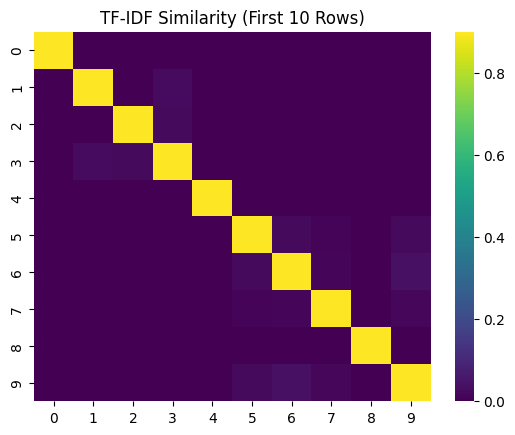

In [18]:
similarity_matrix = compute_similarity(df, processed_columns, weights)

#### **Step 5: Enhance Similarity with Fuzzy Matching**

Enhanced Similarity Matrix (Sample):


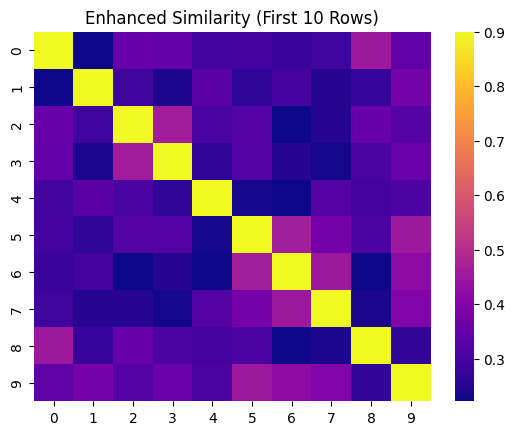

In [19]:
similarity_matrix = adjust_similarity_with_fuzzy(similarity_matrix, df, text_columns)

#### **Step 6: Perform Clustering**

In [20]:
clusters = cluster_entities(similarity_matrix, similarity_threshold)

Number of clusters formed: 725


#### **Step 7: Visualize Results**

In [21]:
visualize_clusters(df, clusters, text_columns)

Cluster 0 (Size: 9):


,name,address,city,phone,category
0,fiore rotisseriqe & grille,3700 w. flamingof rd.,las veqgas,702-2527702,italiac
851,ATONIO'S,3700 w. flaming,llas vegas,702/252 777,italan
965,fiore rotisserie & grill Restaujrant,3700w.flamidngord.,tlas vegas,702-252-u7702,vitalian
1077,fuore rotisserie & grille,3700 w. flamingord.,las xvegas,702-22-7707,italdian
1209,battista's hole in tce wall,4041audriest.atflamiungord.,las vggas,702-73z2-1424,italijan
1529,antocios,3700w.flamyingo,las vgas,702/252-739,italdan
1532,buzio's in the qria,370 w. flamingo rd.,las veas,702-252-697,seeafood
1730,antoniow's,3700w.flaming,las veas,702-252-77o7,itolian
1760,piero's restauran,355y convention center dr.,las vgas,702-36x9-2305,italia




Cluster 1 (Size: 3):


,name,address,city,phone,category
1,phbo hoa,642broadway,chiniatown,213-626-q5539,vietnamse
366,pho ha,642 broadwkay,chnatown,213-6265539,vietnaimese
2495,pho hoa Restauranct,642broadway,chinaton,213 626 553,vvietnamese




Cluster 2 (Size: 5):


,name,address,city,phone,category
2,jacksong's farm,439n.beverydrive,los aneles,310/273-55p74,califolrnian
51,Jackson'S Far,39 N. BEVERLY DRIVE,los anneles,311/273-578,califorian
309,caliufornia pizza kitchen,07 s beverly dr,los andeles,s310-275-1101,calilornian
1296,california pilzackitchen Restaurant,207 sx beverly dr.,los angeleas,310h275-1103,califoroian
1866,jackson's-carm,439 N.BEVERLY DRIVE,losangeles,310/273-5v577,caliornian




Cluster 3 (Size: 4):


,name,address,city,phone,category
3,fwingers,8020 bejerly blvd.,los ageles,213/653 58w58,amexican
1786,hardcrock-cafe,8600 beverlqy blvd.,los angelhes,3y11/276-7605,amferican
2084,swiegers,8020 beverly blvdc.,los angeues,213/653 585h,america
2237,swingerts,8020 beverl blvd.,los angeleo,2f3/653-5858,aerican




Cluster 4 (Size: 3):


,name,address,city,phone,category
4,brtighton coffee shop,9600 brigghton way,bverly hills,3r11-276-7732,coffee shlops
1371,brighton coffee shop estaurant,9600qbrighton way,kbeverly hills,310 276 77b32,covffee shops
2385,hbrighton coffee shop,9600kbrighton way,beverly hlls,311-2767732,ecoffee shops




Cluster 5 (Size: 19):


,name,address,city,phone,category
5,awat,210y e. 58th st.,vnew york,212/35-7554,lsian
168,dawat Restauralnt,210we. 58th st.,new york cjty,212-355-75h5,indan
273,lespinassk Restaurant,2 e. 55th ust.,new yorsk,212/339d-6719,ameican
427,felidia Resvaurant,243 e 58th s,new yrk,212/758 179,italiabn
606,chai,160 e. 48th sta,newh york,212/371 2l323,gsian
624,otbe,68 en 56th st.,new yor,212-223-755,zsian
637,dawst,210 e 5th st,nxw york,w12/355 7555,asan
643,Otbbe,68e. 56th st.,new yor,212/223-u572,asia
751,raiuo,100 w. 82nd st.,new qyork,212/5010775,asian
1022,tse yazna,34 . 51st st.,nw york,212/688-v5440,yasian




Cluster 6 (Size: 7):


,name,address,city,phone,category
6,frenyh roasu,4586thav.at11thst.,nw york,212/533-223,frlnch
270,frenth-roast,458 6th ave. at 1th st.,newh york,212/533-223,rench
556,le jardin Restauant,25 cleveland pl. nezar spring st.,newi york,12/343-9592,frnch
1141,frech roast Restaurant,458 6hH AVE. AT 11TH ST.,nesw york,212/533-22g39,fench
1903,arienne,700 5th ave. ata 55th st.,new yofrk,212-903-39m8,frencch
2415,jean lafjtte,68 w. 58th stu.,newzyork,212-51-2323,frenceh
2536,dix et suept,181 10th st,new yrk,21x/645-8023,frnch




Cluster 7 (Size: 3):


,name,address,city,phone,category
7,Fleur De Jor,348 E.m62ND ST.,newyork,212-355-e2020,cofflee bar
1058,fleu de jour,348 e 62ndhst,nej york,212/55 2020,coffe bar
1457,fleur de jorr,348 E. 62ND S.,new yok,212/35 2020,coffee ar




Cluster 8 (Size: 6):


,name,address,city,phone,category
8,The Baycchanal,3570 las vegas qblvd. s,lasvegas,r02-731-7525,onlykin las vegas
349,Palac Court,3570 las vegas blvd a,nas vegas,702-731-747,continetal
690,Cafg Roma,3570 las vegas blvd. vs,las vgas,02/731-7545,coffee shops/ditners
2086,the backchanal,357d0lasvegasblvd.s,las vega,702/731 752x5,ognly in las vegas
2425,Cfe Roma,3570 las vegas slvd. s,lps vegas,702-s731-7547,offee shops/diners
2579,the bcchanal,3570lasvegasblvd.i,lbs vegas,702/731 75d5,nly in las vegas




Cluster 9 (Size: 6):


,name,address,city,phone,category
9,carmnes,2450 croadway,new york ciity,212-362-j200,ialian
35,camine's,2450 broadway beteen 90th any 91st sts.,new zork,212-32-2200,itaplian
197,Cgarmine'S,2450 broadwqy between 90th and 91syt sts.,newyork,212/362 220,itaian
1105,crmine's Restaurant,2450 broydway between 90th and 91st sts.,newn york,212/362 c200,iqtalian
1664,Carine'S,250broadway,ew york city,2j12-362-2200,italiwan
2091,Carmnine'S,2450 brpadway,new york cito,21x2-362-2200,itaian




Cluster 10 (Size: 5):


,name,address,city,phone,category
10,white house restaurant Restaurant,372 peachtree rd. ne,tlanta,e04-237-7601,diers
173,White Houe Restaurant,3172 pweachtree rd. ne,atlknta,404-237-76f01,iners
929,mcafe aritz-carlton buckhead Restaurant,3434 peachvree rd.,atlant,c04-237-2700,ext 6108 internatonal
2464,dining rom ritz-carlton o buckhead,3434 peachtreerd,wtlanta,404/237-700,internationa
2480,Wbite House Restaurant,3172 peachtee rd. ne,atlanita,j404 237 7601,dners




Cluster 11 (Size: 34):


,name,address,city,phone,category
11,Macartur Park,607 font st.,san ifrancisco,415/398 570,amecrican
91,ritza-carlton-restaurnt-and-dining-room,6q0stocktonst.,sn francisco,415-296-74d5,americavn
108,Cwpress Club,500 ackson st.,san fragncisco,415-y96-8555,amerecan
193,micarthur pari,607 front sn.,san francxsco,415/38-5700,american
196,oone market Restaurant,1 maruket st.,san franciscjo,415/77w-5577,aqmerican
235,fog city diver,1300bdatteryst.,san fpancisco,415/9822000,amecican
452,grand cafez hotel monaco,50z1 geary st.,san fancisco,15/292 0101,amerikcan
524,cagrta,c772 market st,san franciscu,415r-863-3516,ametrican
735,stareo,150 redwood alle,san francvisco,415/81 7827,amnerican
746,sally's cafe & bakery Restturant,300 dz haro st.,san nrancisco,415 626 006,americcn




Cluster 12 (Size: 5):


,name,address,city,phone,category
12,Bisstro Roti,155 steuart s.,san francisco,415-4l5-6500,frenxh
763,the heignts Restaurant,3235 sacrameto st.,san franciscio,415-474-889m0,rench
785,aastis,1015 battry st.,san francisvco,415/39 2555,firench
867,bintro roti,155bsteuart st.,san jrancisco,415/z495-6504,fench
2413,bistro roti Resaurant,155steuartsht.,san fancisco,415/495-650,frencq




Cluster 13 (Size: 7):


,name,address,city,phone,category
13,Le Monrachet,3000 w. paradiset rd.,las vxgas,702-732-511,contiental
590,leomontrachet Restaurant,3000 W. PARADeSE RD.,las egas,q02/732-5111,continenal
840,le montrache,3000 h. paradise rd.,las veguas,702s732 5111,continentan
1585,le montrachet bisra,3000 pardise rd.,ls vegas,702-732-56v51,fench bistro
2402,michael's (lms vegase,359 las vegas blvd. s.,las vega,702-737-115,cotinental
2465,pamlemousse,400e.sapharaave.,las vzgas,702h/733-2066,continenta
2500,le montrachetd bistro,3000paradliserd.,las vegas,702-7325651,french bitro




Cluster 14 (Size: 3):


,name,address,city,phone,category
14,brents del,19565 parthena ave.,northidge,818-886v-5679,deis
1677,brentsn deli,1565 parthenia ave.,norhridge,8j18-886-5675,dlis
2081,brent's dhli Restaurant,k9565 parthenia ave.,dorthridge,818-886-567l,detis




Cluster 15 (Size: 4):


,name,address,city,phone,category
15,fenirx,8358 sunset blvd.west,hollywoeod,213/848 667,americn
99,FNIX,8358sunsetblvd.wtst,ollywood,213x/848 6677,amerian
1817,fenix at the aryli,8358 sunset blvd,w. hullywood,21-848-6675,french(new)
1869,feniv Restaurant,8358 sunsettblvd. west,hollywwood,23-848-6677,americah




Cluster 16 (Size: 11):


,name,address,city,phone,category
16,alain rondeli Restaurant,126 CLEMENiT ST.,san francisco,415/387 04k8,frenh
72,alaijn-rondelli,126 clpment st.,san rancisco,415-87-0408,french (ne)
86,alain rodndelli,126 LEMENT ST.,san frauncisco,415/387-04r8,fench
380,aeain rondelli,126 clement hst.,san fracisco,45-387-0408,french (new
769,fringale Rsstaurant,70 4th st.,san rancisco,415/543-055,freoch
892,The Heightvs,3235 SACRAMeNTO ST.,san franncisco,45/474 8890,rench
1498,alain rondpelle,126oclement st.,san foancisco,415/38z-0408,frsench
1569,ti cokz Restaurant,310 16th st.,san francisuo,415-252n7371,frevch
1810,la olie Restaurant,231 polk st.,san rancisco,415/f776-5577,frenvch
1878,the heihts Restaurant,3235 sackramento st.,san franciosco,45/474 8890,fdench




Cluster 17 (Size: 8):


,name,address,city,phone,category
17,Yoyo Tsumami pBistro,1611post st.,san franisco,4n15/922-7788,frencq
423,tji couz,308 16th st.,san zrancisco,415-252-7c73,frencch
650,mjsa's,648 bsh st.,suan francisco,415/98c9-7157,frenchh
1295,yoyo tsuami bistro,611 post st,scan francisco,415/92l2 7788,franch
1452,zi couz,3108 16th t.,san frpncisco,415-2f52-7375,frencg
1472,yoyo tsumami bistru,1611 post sy.,san fiancisco,15/922-7788,frnch
1516,pacific pa pacific hotee,500 pnost st.,sann francisco,415/929 a087,rench
2387,Pacific Pan Pacific otel,500 poset st.,san fzrancisco,4v5/929-2084,vrench




Cluster 18 (Size: 8):


,name,address,city,phone,category
18,d nico,164mulberryst.etwehengrandandbroomests.,new ylork,21/343-1212,itwalian
365,anyhe vivoli,222e.58thst.between2ndahnd3rdaves.,lew york,212/3080112,itaian
497,l-cortile,12mulberryst.betweencanalanhestersts.,ndw york,212/22p 6060,ktalian
839,anche vivbolo,22h e 58th st between 2nd anld 3rd aves,new yor,212y308-0112,italan
1321,s.o.q.a,y33 mulberry t between hester and grand sts,nw york,21c/925-3120,italan
1514,DANICO,164 mulberryst. between graund and broome sts.,nxew york,212/343-121e,ftalian
2227,d nico,164 mulberry st. reteen grand and broome sts.,new yorpk,212/343t1212,italvian
2430,iw cortile Restaurant,125 mulberry st.o between canl and hester sts.,new yrk,212-226-606y,talian




Cluster 19 (Size: 3):


,name,address,city,phone,category
19,r-2,923 e hird st,losangeles,213-687g7179,japaese
737,R-2j,923e.thirdst,lns angeles,213-68n7-7178,japanhse
1549,re23,j923e.thirdst.,losangeles,213-687-718,jatpanese




Cluster 20 (Size: 3):


,name,address,city,phone,category
20,cayva,3D ST.,los ngeles,213/658 898,mediterrnean
459,ciava Restaurant,3rdt.,lon angeles,213-k658-8898,editerranean
1360,CAyA,3rdst.,los angele,21-658-8898,meditoerranean




Cluster 21 (Size: 13):


,name,address,city,phone,category
21,tangrpavillion,65w.5thst.,new ork,21l2/956-6888,aian
214,pen &pencil,20ue.45thst.,new yor,212/682s 8660,aerican
249,tringolo,34ke.83rdst.,new syork,212/r72-4488,talian
419,rFollonico,6 wm 24th st.,newm york,212/691-63b5,xitalian
494,osteria al drog,142 w. 44th et.,new yrk,212/94-3648,ijtalian
652,tng pavillion,65 w. 55thk st.,new ykrk,2t12/956-6888,asiafn
706,shun lee weesi,43i w. 65th st.,new aork,212-37e-8844,arsian
878,tang pavillion,65 w. 55th sft.,newryork,212-956-688q8,sian
1201,mavyalli palace Restaurant,46 e. 29tph st.,new yrk,212q/679 5535,auian
1509,planet-holvywood,14m w. 57th st.,new ork,212/333-j825,averican




Cluster 22 (Size: 6):


,name,address,city,phone,category
22,buccaner bay club Restaurant,3300lasvegawblvd.s.,lam vegas,7h2 894 7350,conjtinental
342,michae's (las vegas),3595lasvegasblvd.sz,las vegag,702 737x 7111,continentayl
700,bjstro,3400asvegasblvd.s,las vegs,q02/791-7113,continenta
757,buccaneer beay club Restaurant,b3300 las vegas blvd. s.,las vegas,702-894-u358,continenial
1537,buccaneer-bay-mclub,300 LAS VEGAS BLVD. S.,as vegas,702-894-730,contionental
2169,bstro,3400ilas vegas blvd. s,las egas,702/r791-7116,continentl




Cluster 23 (Size: 4):


,name,address,city,phone,category
23,PRICI,500 pharr rdq.,atlantda,404/n237-2941,italiad
1673,prichce,500 pharr rtd.,attlanta,404/37-2941,italiap
1942,primci,500 harr rd.,tlanta,404/2v7-2941,vtalian
2129,BERTOLINI'o,3500 peachtree rd. phipps tplaza,jatlanta,404/2332333,itlian




Cluster 24 (Size: 8):


,name,address,city,phone,category
24,calfornia culinary academy Rescaurant,625 olk st.,san fyancisco,41s-771-3500,frencyh
75,california culinary xacademo,62c polk st,san fracisco,415/71-3508,fench
710,la folieRestaurant,23l16 polk st,sanfrancisco,4b15-776-5577,french t(new)
1552,lafolie,231j polk st.,san francisc,415f776-5574,frensch
2034,california culinary acadxmy,625g polk st.,san fraencisco,415/7d1-3505,fsench
2287,la-folwie,2316 polp st.,san francisc,415/776-579,rench
2434,ritz-carltoon dining oom (san francisco),600 stockton jt.,san fyancisco,415-j296-7465,french(new)
2550,fleur de lys Resgaurant,777 suter st,san rancisco,41/673-7772,fprench




Cluster 25 (Size: 8):


,name,address,city,phone,category
25,pmmairi,371a w 46th st off 9th ave,nw york,212w 956-3055,latin amrican
496,qe marais,150 dw 46th st,new yorsk,212-86e9-0900,ameripcan
731,ipaneqa,1n3 w. 46th st.,new yoork,212/730-58s8,atin american
1689,pomaife,371 w. 46th st. off 9th avek,ew york,12/ 956-3055,latin alerican
2100,pomairz,71 w. 46th st. off 9th ave.,new ork,212b 956-3055,latbin american
2221,Incaj Grill,492 broome st. near w. broadwady,nxw york,212/966-331,latin americjan
2229,iplnema,13 b. 46th st.,newtyork,212/730-844,latin amrican
2445,payria,250 ark ave s at 20th st,newoyork,212/777-212,latin americaxn




Cluster 26 (Size: 3):


,name,address,city,phone,category
26,enita's frites,1433 thmrd st promenade,sant monica,310-458-2m89,fast ood
882,benita's frites Restsaurant,1433 third st. promeade,santa monicda,3v1-458-2889,fast hood
1702,Benita'SyFrites,1433 third st. promenadm,sanrta monica,311-4582889,mfast food




Cluster 27 (Size: 6):


,name,address,city,phone,category
27,monrachet,239 w. broadwaby,new york ciy,212-2y9-2777,vrench bistro
226,Montachet,239 w. broadway between walkder and whitp sts.,new yodk,n12/ 219 2777,frcench
573,montracrhet Restaurant,239 w broadway,new yolk city,212 219 2x777,frenrh bistro
742,sMONTRACHET,239w. broadway,new yor city,212-2192777,french bmstro
1056,Monteachet,239 w broadway betwesn walker and white sts,neq york,2e12/ 219-2777,ofrench
1615,Montrzachet,23v9 w broadway between walkr and white sts,newf york,212d/ 219-2777,frenc




Cluster 28 (Size: 3):


,name,address,city,phone,category
28,lala,211 W. xROADWAY AT FRANKLIN ST.,new yor,k212/431 0700,middle peastern
1163,Laya,211 . broadway at franklin st.,new ork,2z12/431-0702,middle eastery
1627,layre,211 W. BROADWAY AT FRANKLIN STm.,oew york,212/41 0700,middle eastetn




Cluster 29 (Size: 3):


,name,address,city,phone,category
29,SZECHUAN HUNAN COTTAvE,158w8yorkave.,new yorv city,212z535-5223,cinese
327,Szechuan Hujan Cottage,588 york ave.,new york ciy,212 5y5 5223,chinse
748,szechuaun hunan cottage,1588 york av.,new yjrk city,212-53u-5229,chinqse




Cluster 30 (Size: 10):


,name,address,city,phone,category
30,cafffe-reggio,119macddougalst.between3rdandbleeckcrsts.,new yore,212/475-9x557,ccoffee bar
537,caffe rebggio,119macdougalst.betwee3rdndbleeckersts.,inew york,212-475-k9557,coffee gbar
1148,caffe reggio Rstaurant,119 macdougal st. between 3dfrd and bleecker ...,new qork,212/47 9557,coffeebar
1211,cafekbianco,w1486 2nd ave. between 77th and 78th sps.,ynew york,212/988 265,coffe bar
1602,corrado ccafe,1013 3rd ave. between 60th an 1st sts.,nw york,e212/753-5100,cxoffee bar
2073,cafe binco,1486 2nd ave. beween77th and 78th sts.,newdyork,r212-988-2655,qcoffee bar
2116,le gamim,50 macdougbl st. between houston an prince sts.,ne york,212/25 4678,coffee bkr
2329,ocaffe-dante,i1 macdougal st. between houston and blxeker ...,nhw york,212-98-5275,coffee qar
2344,caffe dante,81 macdougal st.i betweenq houston add bleeker...,new yokk,212/982-527,roffee bar
2573,Caffe Dante,81 macdrougal sty between houston and bleeker...,new pork,21/982-5274,coffee kbar




Cluster 31 (Size: 3):


,name,address,city,phone,category
31,tradjr vic'a,9876 wilshire iblvd.,los angelzs,310/276 63d5,asiean
1556,trade vic's,876 WILSHIRE BLVD.,los angees,310/276 w345,sian
1670,TRADER VcC'S,9876 wjilshire blvd.,hlos angeles,311/76-6345,asyian




Cluster 32 (Size: 8):


,name,address,city,phone,category
32,carnegoe-deli,847thave.between54thand55thsts.,nkew york,212/77-2242,delicftessen
541,second avenue deligRestaurant,1562ndave.oat10thst.,onew york,212/677e0606,delicatesmsen
638,carnegiie deli Restaurant,854 TH AVE. BTWEEN 54TH AND 55TH STS.,bnew york,212/75x 2245,delicatesse
1087,second avenue dewli,156 2nd ave. at 10nh st.,ne york,212-677-p0606,delicategssen
1426,stag deli Restaurant,834 7th ave.a between 53rd kand 54th sts.,new yok,212/245-m7850,delieatessen
1748,stage deli Reutaurant,834 7th ave. bevween 53rd anxd 54th sts.,kew york,12-245-7850,belicatessen
1820,second venue deli,15d6 2nd ave. at 10th st.,new yrk,212-677d-0606,delicalessen
1995,carnegie-dli,8547thave.between54than55thsts.,onew york,212/757-2o44,delipatessen




Cluster 33 (Size: 3):


,name,address,city,phone,category
33,lowcountry-bwrbecue,6301 roswel rd. sandy sprigs plaza sndy springs,atoanta,44-255-5160,barbemue
2058,lowcountry ybarbecua,63w01 ROSWELL RD. SANDY SwPRINGS PLAZA SANDY...,attlanta,404/25p5-5168,barbecnue
2151,lowcoupntry barbecua,6301 roswell rd. sandy ssrings plaqa rsandy s...,ataanta,40f/255-5160,barubecue




Cluster 34 (Size: 6):


,name,address,city,phone,category
34,le chardonao,884 MELROSE AVE.,ls angeles,2h13/655-8880,crench
480,le chardonenay (los angelesa,8284 melroe ave.,los angeleds,213l-655-8880,french baistro
1265,Le Cardonnay,8284 fmelrose ave.,los angecles,213/k55-8880,frejnch
1799,Le Chardtnnay (Los Angeles),8284 MELROSpE AVE.,los angewles,t213-655-8880,frynch bistro
1916,le chardonnay Resaurant,8284 melrore ave.,los ajgeles,213-l55-8880,fmrench
2138,le chardonnay (los angweleso,8284MELROSE AVE.,losangeles,213-655-880,frencqh bistro




Cluster 35 (Size: 10):


,name,address,city,phone,category
36,alrotikoa,322 e. 14 st. behtween 1st and 2nd avs.,new yornk,212/47d-2602,meditjerranean
41,grotikon,322e.14st.between1tand2ndaves.,new lork,212-473-26f2,mediterraneavn
958,Bar Asnise,10j22 3rd ave. between 60th and 61st srs.,newp york,w12/355-1116,tmediterranean
1114,bar anse,1022 3rd ave. between 60th and 61ss stjs.,niw york,212/355s-1118,mediterraean
1188,xuntha,174 1st ave. between 10th and 1x1vh sts.,new ykork,212/614 620,mediterrnean
1481,uncle nico'u,747 9th ave. between 50th and 51st smd.,new lyork,212-315-726,muditerranean
1653,Boko,23 e. 22nr st.,neow york,212-228-2k00,mediteyrranean
1738,xunhta,174 1st ave. between e0h and 11th sts.,gnew york,12-614-0620,mediterrnean
1979,unle nick'a,747 9th ave. betwee 50th ayd 51st sts.,ne york,212/315-r1726,meditebranean
2472,agrotixon,32z e. 14 st. between 1st an 2nd aves.,nbew york,212/4732602,mediteranean




Cluster 36 (Size: 38):


,name,address,city,phone,category
37,sfuzzi Restayrant,p58 w 65th st,new yorw,212/8733702,ameican
153,vvrbena Restaurant,54 irvingepl. at 17th st.,nw york,212-20-5454,ameriqcan
200,fifty seven fifty seveb Restaurant,5f7 E. 57TH ST.,new yor,212/758o5758,amegrican
304,qfuzzi,58 w. 65thst.,newh york,212-873y3700,amercan
402,lincoln tavern Resturant,51 w. a4th st.,nerw york,212/71-8276,americpan
426,post house Rzestaurant,28 eo 63rd st.,new york,212/935-288,amjerican
599,march hRestaurant,405e.58thgst.,new yordk,212-754-627n,vamerican
693,SFUZZy,58ww. 65th st.,new yotrk,212/83-3708,amrican
739,fifty seveqn fifty seven estaurant,57 e 57th mt,new byork,212/78-5757,merican
936,paria Restaurant,250 park ave s a 20th st,new yvrk,212/777-211,latin americaon




Cluster 37 (Size: 4):


,name,address,city,phone,category
38,jack spxrat's grill,l0668 w. pico blvd.,cos angeles,311/83b7-6662,health ood
1021,clearwater caf,168 w. coloradwo blvd.,los angelues,818/3560959,health fzood
1276,Jack Sprat'S Grill,10668 W. PICO BLVDd.,losdangeles,310-837-6i62,ealth food
1892,jack-sprat's-grlll,10668 w. pco blvd.,lbos angeles,310837 6662,health foojd




Cluster 38 (Size: 5):


,name,address,city,phone,category
39,Tommy Tfng'S,731 melrose ave.,los angekes,213/937 573,sian
736,TOMY TANG'S,7313 melrlose ave.,loszangeles,2l3/937-5734,aeian
1403,taola calda Restaurant,737h1 melrose ave.,los angels,213/6586341,italivan
2255,TOMMY TAsG'S,7313 melrosie ave.,loseangeles,213/937 573r3,asan
2265,tvola calda,h7371 melrose ave.,ls angeles,213/658-340,itklian




Cluster 39 (Size: 3):


,name,address,city,phone,category
40,bruno's Restaurrant,3838 centinelq ave.,msar vista,311-397-e703,italan
744,brunos,3838 entinela ave.,mar vsta,310-39r-5703,ktalian
1579,brunoq'i,3838 cegtinela ave.,mpar vista,3b10-397-5701,itaian




Cluster 40 (Size: 4):


,name,address,city,phone,category
42,bistro the Rrstaurant,56 E. ADREWS DR. NW,atlantw,m404-231-5733,frennch bistro
555,bistro pthu,56 E. ANwREWS DR. NW,atlanhta,404231-5733,french bistro
1949,bistro the Restaurant,56e. andrews dr. nw,ablanta,404o231-5733,fregch bistro
2585,brasserie le coxe Restaurant,3393 eachtree rd.,atlpanta,40d4-266-1444,french bistrjo




Cluster 41 (Size: 9):


,name,address,city,phone,category
43,9 jones strei,9 jrones st.,new yor,212-989-122f,azerican
271,9 jones staeet,9 joes st.,new yotrk,212-989-1q220,americlan
336,money bar,60 e. 54th gst.,new yrk,212z-838-2600,aierican
1050,9-jojnes-street,9 rjones st.,new yoprk,212/989-122,amegican
1146,tonkey-bar,60 e. 54gth st.,nhew york,212y838 2600,aerican
1381,chanjterelli,2 harrison stw near hudson st.,nedw york,212-9n6-6960,ajerican
2267,judssn grilu,12 w 52nd st,new rork,212-582-5v252,americcan
2346,merican placi,2 parb ave at 32nd st,new yor,21-684-2122,amercan
2476,four seasons gill rooi,99 e. 52nd sg.,pnew york,212/754-9u91,ameican




Cluster 42 (Size: 19):


,name,address,city,phone,category
44,bouterlin Restaurant,420 e. 59th st. off 1s ave.,newryork,212/758-033,freench
161,dbniel,20 e. 76thfst.,newnyork,212/288-033,frenh
341,ferrier Resftaurant,29 e. 65rth st.,new ork,212/k772-9000,frenbch
401,'udo Restaurant,432 lafaycette st near astor pl,new yocrk,212/a88-0978,firench
519,felixf Restaurant,340 W. BROADWAY A GRAND ST.,unew york,21r2/431 0021,frencv
815,marighu Restaurant,342 e 46th sa between 1it and 2nd aves,new yoruk,212-370x1866,frznch
1037,boutoerin,420 e. 59th st. off 1st ave,neb york,21t/758-0323,frnch
1310,Cmite,1o0 w. 51st st.,newyork,212/95d6 7100,freench
1475,cafe botanicq Restaurant,160 CENTRL PARK S,ew york,212/44 5120,rench
1577,cafe cfentro Restaurant,200 park ave. betweend 45th hst. and vanderbi...,new yor,212/818 1a222,vrench




Cluster 43 (Size: 3):


,name,address,city,phone,category
45,SILVpER SKILLET THE,2o0 14th st nw,atlantv,40f-874-1386,coffee shhops
1985,Silver Skillea The,200 14th st nw,atlantga,404-874-388,ctoffee shops
2093,silver skille the,20 14th st. nw,atlaonta,404874-1388,coffee shps




Cluster 44 (Size: 5):


,name,address,city,phone,category
46,grill on the aglley Restaurant,9560ydayton way,los angees,310/76 0615,amerzcan
139,Mogton'S,8764 melrosej ave.,los angees,310/276 520r5,amerkcan
448,nate 'n' al's estaurant,414 N. BEVuERLY DR.,los ahgeles,310-274-010,amercan
1413,gribl on the alleo,9560 DAYTONgWAY,losangeles,311/26-0615,amerizan
1804,grill on the ajlley,9560 daykon way,sos angeles,311/276-615,amfrican




Cluster 45 (Size: 2):


,name,address,city,phone,category
47,WESTSIDE COTTAE,689 nintah ave.,nea york city,212-245-080j0,czhinese
890,cestside cottage Restaurant,689 yninth ave.,dnew york city,212 245s0800,chineje




Cluster 46 (Size: 15):


,name,address,city,phone,category
48,gotham-bar--grill,12 e 12h st,tew york,2m2/620 4020,americamn
77,gotham-bar-&-grivll,2e.12thst.,new yorj,212-620-020,jamerican
105,ambassadorugrill,1 united natrons plazf at 44th st.,new ork,212/70-5012,aemerican
111,tribca grill,375 greenwich st.h near franklmn st.,sew york,212-94s-3900,ameriican
233,gotham-bar-&-griqll,12 e 12th rt,nsew york,212w620-4020,wamerican
370,ganlagher'u,v28 w 52nd st,ew york,212/245-o336,amrican
586,emily',1325 5th ave. at 111tch st.,new yxork,212/996 122,americn
698,xmesa grill,102 5th ave. betwsein 15th and 16th sts.,new byork,22/807-7400,ameritan
708,ambassadorqgrill,1 united nxtions pladza at 44th st.,newyork,d12/702-5014,ameorican
713,ruth's chriy,148w.51swst.,ew york,212/245 f9600,amerdican




Cluster 47 (Size: 3):


,name,address,city,phone,category
49,CHVYS,4th and hoard sts,an francisco,415/54 8060,mexican/latin american/spanvsh
96,chevys Resqtaurant,4th and howar sts.,sani francisco,d415/543 8060,mexican/latin american/spanis
2388,hevys Restaurant,4th and howard ts.,san franciscp,x15-543-8060,mexican/latin american/spaish




Cluster 48 (Size: 8):


,name,address,city,phone,category
50,cafee-claude,7 claue la.,san rancisco,415/392-305,frnch
134,fleur delyu,77 sutter st,san arancisco,415/6m73 7779,frenah
618,fleur de lfs,777 sutcter st.,san frzncisco,415/673-7z79,frenh
944,cafe-clauqde,7 claude la,san fpancisco,15/392-3509,fench
1044,cafec claude,7 CLAUDE LsN.,sajn francisco,15 392 3505,french bistdro
1151,cafe cludo,7 claude lay,san flrancisco,415/392 b3505,frency
1641,cafe-claud,7 laude ln.,san ofrancisco,4u15-392-3505,gfrench bistro
2357,tCafe Claude,7 clatude ln.,san franckisco,q15-392-3505,frnch bistro




Cluster 49 (Size: 2):


,name,address,city,phone,category
52,ZAB-E-LE,4837 old national hwp.,cfllege park,404-7682705,thii
1267,zab-e-rlee,4837 ld national hwy.,collegea park,404-768-27t05,thi




Cluster 50 (Size: 21):


,name,address,city,phone,category
53,sign of thedove,1110 3RD AVE. AT 65TH STj.,new yoerk,212/861 80v80,amwerican
71,mesa gilo,102 5TH AVE. BETWEEN 1y5TH AND 1TH STS.,now york,212/807-708,amberican
93,SIGNm OF THE DOVE,11103rdazve.at65thst.,new hork,212/861 8w080,amercan
164,mqtown-cafe,104 w. 7th st. near 6th ave.,new yorq,212/581 030,merican
468,manhattaw cafe,1161 1ST AVE. d BETWEEN t63RD AND 64TH STS.,now york,212/8886556,merican
687,sigl of the dove,1110 3rd ave at 65th s,nw york,21r2/861 8080,americab
738,smith-&-wollensk,201 E. 49TH SmT.,new vyork,21w/753 1530,amderican
774,Manhatton Cafe,1161 1ST AVE. jETWEEN 63RD AaND 64TH STS.,new yorzk,212p888-6556,amrican
798,perk avenue cafe,100 e. 6trd st.,nedw york,212/644 1i900,ameican
1053,odeoo,145 W. BROADWAY AT THOMAS STm.,new yrk,21u/233 0507,abmerican




Cluster 51 (Size: 3):


,name,address,city,phone,category
54,tommy's Resturant,2575 bmverly blvd.,lwa,213-38w9-9064,hamburgenrs
1431,TOMaY'S,2575beverlgyblvd.,ula,213-x389-9060,hamburgeurs
1772,tommu's,2575 BEVERLY mBLVD.,lw,213-389-906p,hamburvers




Cluster 52 (Size: 7):


,name,address,city,phone,category
55,rio cafu,170fillmorest.,san fpancisco,41o5-563-2248,amerpcan
135,plumpjack cafe Restauraet,3201 fillmsore st.,sanfrancisco,415-e63-4755,mediteranean
289,plumpjack-cpfe,312f fillmore st,sanz francisco,415-r63-4755,americacn (new)
314,Doidoge'S,2217 uion st.,san franciscvo,415-921-2i49,americn
1643,TRIO CAhFE,18w70 fillmore st.,san franisco,415 56q 2248,aomerican
1675,pyumpjack cafo,3127fillmore st.,san francsco,415-563-h4755,americaan (new)
2090,pluompjack cafe Restaurant,3127 fillmorest.,svn francisco,415-b563-4755,american (newp




Cluster 53 (Size: 5):


,name,address,city,phone,category
56,l'orangrie,903n.lacinegablvd.,w. hnollywood,31f-652-9770,frnench (classic)
441,y'Orangerie,903n.lacijenegablvd.,w. hollywood,310-652-9r70,french (clasic)
458,l'orangeri,03 n. la cienega blvd.,los angneles,310/6v52 9770,fench
900,loraengerie,903n.lacienqgablvd.,w. holywood,310-652-770,frenwh (classic)
1877,l'oryngerie,903 n. la cierega blvd.,los andeles,311/652-977c,rench




Cluster 54 (Size: 4):


,name,address,city,phone,category
57,cafe cenwro,200 park ave between p45th st and aanderbilt ave,nbw york,212/81 1222,frencz
232,cafe-lure,169 sullivan at between houston and bleeqcker...,ew york,2d2/473-2642,frenc
932,Caffe ure,169 sulxivan st betwee houston and bleecker sts,new yofk,212/47-2640,frenc
1152,vafe-centro,200 park ave. between 5xt st. and vanderbilt ...,ne york,u12/818-1221,french




Cluster 55 (Size: 2):


,name,address,city,phone,category
58,mitali jeast-west,2x6 BLEECKER ST.,new yorklcity,212 989 1n367,indipn
115,Mitaly East-West,296 bleecker st,new york cty,212-989-167,indiat




Cluster 56 (Size: 16):


,name,address,city,phone,category
59,khan coke thai house,593o7 geary blvd.,san fwancisco,15/668-6654,wsian
142,straqts cafe Restaurant,3300 geary lvd.,san francico,415/68-1783,xsian
332,hong kong flowesr lounge,5l322 geary blvd.,san rancisco,41z5/668 8998,asiad
502,Khan Toke Thai Hmuse,5937 geary clvd.,san francisvo,4c15/668 6654,asiin
575,khan toke tai house Restaurant,5937 geary blvdi,yan francisco,415-668-p654,tlhai
989,straits cazfi,3300 gearys blvd,san franctsco,m15/668-1789,asiaw
1068,straitp cafe,3300 geapy blvd.,san fraicisco,415-668-1q83,asin
1126,HONG KONG FLOWER LONGE,5322 geary bld.,san franmisco,415/68-8998,aian
1204,khan tdke thai house,5937 EARY BLVD.,san frajncisco,4c5/668-6654,asiin
1749,khan oke thai house,5937gearyblvd,sao francisco,415-668-654,tai




Cluster 57 (Size: 19):


,name,address,city,phone,category
60,bic cup Restaurant,228 8th avg. between 21st and 22nd stsa.,new yor,12/206-0059,coffee bair
204,qBig Cup,22 8TH AVE. BETWEEN 21ST AND 22zND STS.,new ybrk,21-206-0059,coffe bar
259,marquet patibsserie Restaurant,15 e. 12th sot. between 5th ave. and uiwversi...,newqyork,212/22 9313,cofdfee bar
361,cupcake cafle,52 9th ave. at 39th st.,new yorck,c12/465-1532,coxfee bar
371,troisjean,154 e. 79th xte. between lexington and 3rd aves.,new yorn,212/988 485,coffece bar
707,cfe la fortuna Restaurant,69 w 71st lt,new yozrk,212724 5846,coffe bar
1177,veniero's pasticceria Reestaurant,342 e. 11th st. wnear 1st ave.,new yorp,212/674-764,coffce bar
1353,newsbar Restayurant,2w.h19thst.,new ysork,212/25t 3996,coffee tbar
1425,le gamin Restaurank,50 macdougal st. wtetween houston and prince ...,nqew york,212/25i 4678,coffeek bar
1456,caffe romy Restaurant,385 broone st at mulberry,nnew york,212/226-8s417,cofffee bar




Cluster 58 (Size: 16):


,name,address,city,phone,category
61,l'osteiia del forno Restaurant,519 columbus avey.,san frbncisco,415-982u1124,itlian
236,vivande ristorant,670 goldenl gate ave.,san francixsco,415/67 9245,citalian
451,oritalia Resetaurant,1915 flllmore st.,san froncisco,415/346-133,itaqlian
473,L'Osteria De Forno,519 columbus aie.,san franciscs,415/98-1127,ialian
547,vivande istorante Restaurant,670 GOLDENf GATE AVE.,sanpfrancisco,4y15/673 9245,ittlian
577,rose pisola,532 columbu ave,san fdancisco,415-399-043,itamian
997,eivande-ristorante,670 golden gate avy.,san franisco,415/s673 9245,ialian
1436,rose pistolr Restaurant,532 clumbus ave.,san franciosco,415-399-c0499,itajlian
1850,rose pistola Restatrant,532 columbuj ave.,san fancisco,415-k99-0499,iaalian
1852,rse pistola,5h32 columbus ave.,san fjrancisco,415/399-049,italia




Cluster 59 (Size: 3):


,name,address,city,phone,category
62,hudson oriver club Restaurant,4oWORLD FINANCIAL CENTER,new zyork,12/786-1509,lmerican
277,vduane park cafe Restaurant,157 DUNE ST. BEWEEN W. BROADWAY AND HUDSON ST.,newe york,212/732-551,aperican
2589,hudson river club,4 world financial centnr,new byork,212n/786-1504,amercan




Cluster 60 (Size: 3):


,name,address,city,phone,category
63,zadnkou chickeu,1415 e. colorao st.,lendale,88-244-1937,midle eastern
593,zakou-chicken,1415e. colorado st.,glendalle,818-244-1u30,giddle eastern
696,zanko chicken,1415 e. colorao st.,gwlendale,818i244-1931,mibddle eastern




Cluster 61 (Size: 3):


,name,address,city,phone,category
64,SOnO,3330fiedmontrd.,ablanta,404-2y3-2009,japanehe
784,soto iestaurant,3330 piedmont ryd.,atlant,40-233-2005,japnnese
1778,soto Reswtaurant,3330piecmontrd.,avtlanta,40-233-2005,japanzse




Cluster 62 (Size: 5):


,name,address,city,phone,category
65,ijacks,615 sacramnto st.,san franisco,t415-986-9854,ol san francisco
179,dardellis,243 o'farrelkl st.,san fancisco,415/d82-0246,old san francisco
1104,JAK'S,615 sacrameto st.,san franciisco,415-98c-9854,old san francidsco
1218,wjacks,615sadramentost.,san fravcisco,41r/986 9854,old sean francisco
1313,sgarden court,market and new mfontgomery sts.,san rancisco,415-546z-5011,old san francico




Cluster 63 (Size: 4):


,name,address,city,phone,category
66,INTERNET AFE,82e.3rdstabetween1stand2ndaves.,new yok,212/ 61n-0742,coffef bar
775,LE yAMIN,50 macdougal st. hetween houston and princea ...,rnew york,212/2x4 4678,cffee bar
1059,SANT AMuBROEUS,1000 madison ave. between 77th ad 78th szs.,new yosrk,212/b570-2211,coffe bar
1424,CUPCAKE AFE,5229thave.at3thst.,nuew york,212/465-150,cofee bar




Cluster 64 (Size: 2):


,name,address,city,phone,category
67,mjarichu,342e.46thqst.between1stand2ndaves.,nw york,212/370 18d66,rench
1039,chez jacquelie,72 macdougalst. etween w. rhouston and bleeck...,new ork,22/505 0727,rench




Cluster 65 (Size: 9):


,name,address,city,phone,category
68,irafe,208te. 58th st. between 2nd and 3rd aves.,knew york,g212-752-3054,italiean
634,i truli,122 e. 2th sut. between lexington and park aves.,nw york,212/481t7375,itplian
681,cocorpazzo,23e. 74th st.,nw york,212-794-02f5,itualian
999,girafe Restauront,208 e. 58th zst. betweef 2nd and 3rd aves.,new fork,212/752-30u5,italifn
1238,oIRAFE,208 e. 58th st. between 2nd and 3rd aves.,new yortk,212/o752-3059,italijan
1762,mangia e bvi,800 9th ave. at 53ard st.,ew york,21l2/956-3975,imtalian
2305,fiorellos roman cafe,1900 broadwayn between 63rd and 64xth sts.,new eork,2s12-595-5330,italihn
2453,is.p.q.r,133 mulbery st. between hester and grland sts.,neew york,212/925 310,italan
2463,fiorellog's roman cafe,19l0 broadway between 63rd and64th sts.,new yolrk,21v2/595 5330,itfalian




Cluster 66 (Size: 3):


,name,address,city,phone,category
69,steresa's Restaurant,80modtaguest.,quheens,718-50-2912,polnish
1190,TERESAm'S,d0montaguest.,quees,718-520-290,poish
1781,Terpesa'S,o0 montague st.,qieens,718-52s0-2910,polisx




Cluster 67 (Size: 27):


,name,address,city,phone,category
70,fsan pietro,18 e. 54jth st.,wnew york,21o/753-9013,italin
89,Ij NIDO,251 e. 5prd st.,jnew york,212-753-84e50,itlian
120,lattanzi sistorante Restaurant,361mw. 46th st.,newf york,b212/315 0980,italiian
121,remi Reptaurant,145 w. 53r st.,new yogk,212/581-424o2,itajlian
180,SANPIETRO,18 e 54th ft,new uork,212/753u-9013,italin
246,Lattanzi Ristoranqe,361 c 46th st,newyork,212/31d-0985,italimn
311,brunno,240 e. p8th st.,ew york,2o2-688-4190,italia
407,lattadnzi-ristorante,361 w.k 46th st.,new yorkk,21b2-315-0980,italin
607,padii,151 w. 51jst. st.,new yohk,212/a45-4850,italdan
694,felidia Restauradt,24q3 e. 58th st.,new york citp,f12-758-1473,italin




Cluster 68 (Size: 17):


,name,address,city,phone,category
73,wSteak House,280 las vegas blvd. s,las vegafs,70u2-734-0410,steak houies
118,styeak house,2880 las vegas bvvd. s,las vegats,702/734-040,slteak houses
217,tilkerman the,2245e.flaminord.,las viegas,70-731-4036,steakhouse
348,stak house the,28z80 las vegas blvd s,las vegs,7j2-734-0411,steakholuses
418,steak-hose--the,288y0 las vegas blvd. s.,las vegras,7d2-734-0419,steakhousies
528,mortons of chicago (las vegcas),3200 las vegas blvd.ss.,as vegas,x02-893-0703,steakhoues
598,wolie'a,3900 paraise rd.,las vegvs,7u2/794-0709,steak houxses
627,sweakhouse--the,128e.bremontst.,las vegjas,702-382-600,sterkhouses
1171,circus circuhs,2880 las veas blvd. s,las egas,702/73n4-0417,buffews
1400,tillerman dthe,224 e flamingo rd,las vexas,702-31-4036,stekhouses




Cluster 69 (Size: 3):


,name,address,city,phone,category
74,One If By Lyand Tibs,17 fbarrow st.,new yok city,212-228-082n2,pontinental
561,one if by land stibs,1u BARROW ST.,nyew york city,21n2-228-0822,contilnental
1487,ONE IF BY LANDs TIBS,17 barrow sts.,xnew york city,12-228-0822,contiinental




Cluster 70 (Size: 10):


,name,address,city,phone,category
76,rosco's-house-of-chicken-'n'-wafflues,1514 n. gowe st.,los angegles,213/46-9326,amercan
220,zrj's the rib joinu,252 n. bverly dr.,los agngeles,31n1/274-7427,amercan
263,roscoeq's house kof chicken 'n' waffles,1514 n. gowerst.,leos angeles,213/46-9329,amerdican
535,Nicla,601 s. figueroast.,los angees,213/485-928,americhan
676,Nicosa,601 s. figeroa st.,los angles,213/45-0927,americn
1600,roscoe's house wf ihicken 'n' waffles Restaurant,151dn.gowerst.,rlos angeles,213/466-939,amerijcan
1914,philipoe's the originalRestaurant,1001 n falameda st,lo angeles,213/28-3781,amerhican
1982,philbppe's the originae,1001 n. alameqa st.,los axngeles,21e3-628-3781,ramerican
2319,Pacfic Dining Car,6t st.,los angdles,213/4836007,amerikcan
2353,philippe's the oiiginal Restauoant,1001 n alameqa st,los argeles,213-62-3781,averican




Cluster 71 (Size: 5):


,name,address,city,phone,category
78,PLMPJACK CAFE,3201 fillmorecst.,ssn francisco,415-c63-4755,mediterhranean
787,LA MEDImERRANEE,28w8 noe st.,san fruancisco,s15-431-7211,eediterranean
1302,tUNI CAFE & GRILL,1658 market t.,san francirsco,415/552-u521,mediteranean
1635,LA MEDITERANEE,288 znoe st.,san rancisco,415-431-721,medikterranean
2438,Plupjack Cafe,321 fillmore st.,santfrancisco,415q/563 4755,medierranean




Cluster 72 (Size: 3):


,name,address,city,phone,category
79,izzy's steak & cho house Restlurant,3345 STEqINER ST.,san framcisco,415-5630487,steak hyouses
465,izzy's teak & chop housa,345 steiner st.,san frfancisco,q15/563 0487,stleak houses
916,izz's-steak-&-chop-house,3345 srteiner st.,san francipsco,41/563-0482,styeak houses




Cluster 73 (Size: 6):


,name,address,city,phone,category
80,heera of inda,595 piedmont ave. rio shopingx mall,atlana,404/876 440l8,asrian
909,Hoera Of India,595piedmontave.rioshoppngmall,aktlanta,404/876-448,asiar
1700,heera-of-idia,595 piedmontnave.,atlnta,4o4-876-4408,gndian
2032,heera-of-indqa,595 piedkmont ave.,atlrnta,404-a876-4407,inwdian
2104,heera of aindia,595 piedmond ave. rio shoppini mall,atlcanta,404/876-440p3,asia
2490,Heera Ouf India,595piedmontav.,atflanta,404-76-4408,ndian




Cluster 74 (Size: 5):


,name,address,city,phone,category
81,ybelvedere--the,9882 little svnta monica blvd.,beverlyh hills,310-788-z301,pacific ew wave
1688,icafe-blanc,9777 littfle santa monica blvd.,bkeverly hills,3q11-888-0108,pacific new wae
1859,cafe blai,9777 lcittle santa monica blvd.,beveqly hills,310 88 0108,pacific ndw wave
2012,Belvedere uhe,9882 little ssanta monica blvd,beverl hills,310b788-2301,pacific few wave
2033,belvedere tmhe,9882 ltittle santa monica blvd,beverly hmills,310-788-n300,pacific new wfave




Cluster 75 (Size: 3):


,name,address,city,phone,category
82,russell's bugers Restaurant,w1198 pch,xseal beach,31-596-9556,hambrgers
1880,russell's burgers Restaurant,x198 pch,sfeal beach,31t0-596-9556,hamburgeers
2147,rcussell's-burgers,1x198pch,seal boeach,311-596-955,hamburgeqrs




Cluster 76 (Size: 3):


,name,address,city,phone,category
83,bradshaw's resturana,2911 s. pharr coprt,atlanla,404 261 7h15,southern/sdul
542,BRADSHAW'S RETAURANT,2911 s.pharr court,astlanta,404-261-705,southern/soal
1405,bradeshaw's restaurani,2911 s. pdharr court,atlantla,404-261-715,southjrn/soul




Cluster 77 (Size: 3):


,name,address,city,phone,category
84,jiimys,21 moreno dr.,os angeles,310/552 2y94,cojtinental
1927,jimamy's,21morenodr.,los angesles,310/552y 2394,contnental
2515,jimmy'ou,201mopenodr.,los angells,11/552-2394,continetal




Cluster 78 (Size: 6):


,name,address,city,phone,category
85,ocean park icafe,3117 ocean park blzd.,snta monica,310 452 i5728,amercan
181,ocean aveznue,140 ocean ave,santa monnca,310/394 5w669,amdrican
752,ocean venue,1401 oceaz ave.,santa monicta,310-34-5669,ameriqan
797,ocwean park cafe,3117 ocean park blve,santa moica,3a0-452-5728,americayn
2110,ocean park cfe,3117 ocean park blovd.,santa onica,310 452 57g28,america
2517,ocean avenue Restaurany,1401 ocan ave.,santaamonica,310-394-569,americqn




Cluster 79 (Size: 3):


,name,address,city,phone,category
87,GEENWOOD'S,1087 green t,zoswell,770-992-53c3,sxouthern/soul
457,greenwhod's Restaurant,1087greent.,roswll,70 992 5383,sothern/soul
1350,greenwod'o,1087 GREE ST.,rswell,770-d992-5384,southern/souul




Cluster 80 (Size: 5):


,name,address,city,phone,category
88,Chi'S,3200las vegas blvd. s.,las regas,702 7338899,chinesm
508,chitns,i3200 las vegas blvd. s,has vegas,70i/733 8899,aszan
565,cin'i,3200 las vgas blvd. s.,laj vegas,7n02-733-8899,chinesf
1275,chin's Resotaurant,3200 lasx vegas blvd s,ls vegas,702-733-899,chinesx
2362,chin'n,3200 las segas blvd. s,las vegfas,70d-733-8899,asia




Cluster 81 (Size: 5):


,name,address,city,phone,category
90,zyank sing,427 battery st,san frfncisco,415/541 494u,asan
762,wu kongr Restaurant,101 spearast.,sanh francisco,415/957u 9300,asan
858,yank ing,a427batteryst.,sn francisco,b415-541-4949,atsian
1441,Ton Kian,3148geryblvd.,san cfrancisco,41i-752-4440,asan
1787,YANK SIiG,42 battery st.,san franciksco,415-541-494w9,sasian




Cluster 82 (Size: 3):


,name,address,city,phone,category
92,l cachette,10506 lqttle santa monica blvd.,century ity,310-47y-4992,french (neh)
969,la cachtte,10506 little sarta monica blvd.,century cty,31s0-470-4991,frenh (new)
2450,la cachette Restanrant,10506 LITTLE SANTA kMONICA BLVD.,century citx,310 470 499,frenh (new)




Cluster 83 (Size: 3):


,name,address,city,phone,category
94,leaurivage,26025 iacific coast hwy.,malizbu,31p/456-5736,frenwh
298,beaurivage Restagrant,6025pacificcoasthwy.,malibou,310/56 5733,frenzch
625,beaurivga,26025 pacific coast hwy,maliu,311/456-573n3,arench




Cluster 84 (Size: 3):


,name,address,city,phone,category
95,swan-oyste-depot,517 polk st.,san fracisco,415 673 110c,seafdod
574,swan moyster depot,1517nPOLK ST.,san francico,415 67r3 1101,sesfood
2295,swan oystdr depoo,151fpolkst.,san francixsco,4k15 673 1101,safood




Cluster 85 (Size: 8):


,name,address,city,phone,category
97,seryjna,11e. 53rd st.,newk york,u212/980 9393,asan
842,oeryna,11 e 53r st,new york cbity,212 980 939j3,jaipanese
925,emppire korea,6 e. 32n st.,jnew york,21s2/725 1333,fasian
1003,le-colonikal,149 eo. 57th st.,new yrk,212/ 7520801,asan
1524,nseryna,1 e. 53rd st.,nkw york,b212-980-9393,asin
1858,seryn,11 e. j53rd st.,ne york city,212 980t 9393,jaanese
2006,NewtYork Kom Tang Soot Bul House,3 w. 32nd st.,new yore,212/ 947-w482,asan
2198,seryn,11 e 5crd st,new yok,212/980n9393,bsian




Cluster 86 (Size: 3):


,name,address,city,phone,category
98,binion's coffee hop,128 FREMOjNT ST.,las vehas,j702/382-1604,coffee shps/diners
244,BINION'SCOFFEE SHOP,128 fremont sw.,lasvegas,702/38b-1600,coffee sehops/diners
424,binion's coffee sop,128fremotst.,lpas vegas,702h/382 1600,coffeeo shops/diners




Cluster 87 (Size: 3):


,name,address,city,phone,category
100,Nuevo Laredo Cantin,149chattahoocheeave.nw,aalanta,404-52-9009,mexhican
1320,nuevo-lredo-cantina,1495 chattahoocahee ave nw,atlana,4q4-352-9007,mexicar
2489,nuevo-laredo-catina,1495 chattahoochee ave.n nw,agtlanta,40 352 9009,meaxican




Cluster 88 (Size: 4):


,name,address,city,phone,category
101,pano'sand-paul's,1232 W. PACES pFERRY RD.,tlanta,04/261-3662,iternational
125,pano's-andhpaul's,1232 W. PACES FERRYsRD.,alanta,40/261-3662,ikternational
750,pano's anpd paul's,1232 w. paces ferryg rd.,atlantna,404-261-36r2,internahtional
1840,pano's & mpaul'i,1232w. paces ferry rd.,atlnta,404 2613662,american(new)




Cluster 89 (Size: 6):


,name,address,city,phone,category
102,Lla,30 WESv 22ND ST. BETWEEN 5THaAND 6TH AVE.,new cyork,212/675-6b05,ameican
789,lamo,k04 e. 48th st.,nefw york,212- 759-059j,mexiycan
1041,wOLA,30 west 22nd st between k5th andu 6th ave,new yotrk,212/a675 6700,americqn
1234,lokla,30 WEST 22ND ST. BETlWEENg 5TH AND 6TH AVE.,new ork,212-675-a6700,aerican
1352,bily'e,948 1STt AVE. BETWEEN 52mND AND 53RD STS.,new tyork,21s2/753 1870,awmerican
2037,lamo,304 E. k48TH ST.,new gork,212/ 7590590,mexica




Cluster 90 (Size: 33):


,name,address,city,phone,category
103,seventh regiment messand bar,643 park ave. at 66the st.,newyork,212/44-4107,merican
170,keventh regiment mss and bar Restaurant,643 park ave. at u66th st.,new yuork,212-744-417,aerican
201,emly's,1325 5h ave. at 111th st.,new yzork,212/996-121a2,amerian
268,spring street natural restgauant & bar,62spring st at lafayette st,ne york,212/966-0q99,aerican
383,TwoTwo Two,2p2 w. 79th st.,newyork,212a/799-0406,american
420,sarabyeth's-kitchen,423 amstrdam ave. betwen 80th and 81st sts.,new qyork,212-496-6e80,amtrican
437,aseventh regiment mess and bar,643 park ave. at 66thst.,cew york,212/744-410f7,ammerican
488,h-lifxe restaurant and lounge Restaurant,1340 1st ave. at 7nd st.,newyyork,21e2/249-3600,aimerican
531,verbmna,54 iruing pl at 17th st,new nork,212/260-544,awerican
540,matthew'ns,1030 3rd ave. ak 61st st.,ne york,212/8384343,amerian




Cluster 91 (Size: 4):


,name,address,city,phone,category
104,HzAWTHORNE LANE,22 hawthore st.,sanefrancisco,d415/777-9779,aerican
523,hawthorn lane,22 hathorne st.,san francishco,4u15 777 9779,californkan
1613,hawtholne-lane,22 kawthorne st.,swn francisco,15-777-9779,calkfornian
2166,dHAWTHORNE LANE,22 hawqhorne st.,san francirsco,41-777-9779,califrnian




Cluster 92 (Size: 3):


,name,address,city,phone,category
106,Asahi Ramfen,2027sawteleblvd.,wext la,30-479-2234,noodlebshops
343,AsahigRamen,2027 sawtelle blmvd.,west lha,31-479-2231,nojodle shops
1223,asahiramen,2027swtelleblvd.,wesz la,311-479-231,noodle shop




Cluster 93 (Size: 8):


,name,address,city,phone,category
107,rwestaurant horikawa,111 s. san pedro st,los ankeles,213/680-9w51,acian
899,nicola hestaurant,601 sfigueroa st,los angelews,23/485 0927,amerifan
1246,restauran horikawa,111 s san petro st,los anieles,213-6d80-9355,asia
1292,restaurant horikaewa,11g1 s. san pedro st.,los aneles,21p3/680-9355,asfan
1411,mon-kee-seafood-arestaurant,679 . spring st.,los angele,213-628-717,asiaq
1849,restaurant katsou,1972 n. villhurst ave.,elos angeles,213665-1891,asban
1991,rkestaurant katsu,1972t n hillhurst ave,loh angeles,213/665-1k98,asiin
2491,Mon Kee Seafood Restaurank,679 n. sprin st.,los angelers,213-68-6717,aysian




Cluster 94 (Size: 3):


,name,address,city,phone,category
109,marnie's-noodlie-shop,466 hudson sth.,new yrrk city,z12-741-3214,aian
1941,Marnie'S Nodle Shop,466hudsnst.,new york cit,212741 3214,afian
1967,marnie's noodle sdop Restaurant,466 hudmon st.,nww york city,212-7413210,asibn




Cluster 95 (Size: 3):


,name,address,city,phone,category
110,golden steer Restauraent,308 w. safara ave.,las vedas,702/s84-4470,steakhouses
379,gollen-steer,308 Wb. SAHARA AVE.,las vegan,70f-384-4470,gteak houses
2416,Golden Sxteer,308 w sahara avj,la vegas,702/38 4470,steam houses




Cluster 96 (Size: 4):


,name,address,city,phone,category
112,campo sato,24y columbus ave.,sadn francisco,415-433-9x23,mewxican
1169,CAMPO SANT,240 columbus avel.,san frkancisco,415z433-9623,mexicgan
2242,la cumre Restaurant,515 valencia stt.,sgan francisco,415-j63-8200,mxican
2431,campt santo,240 csolumbus ave,sanxfrancisco,415-433-e626,mxican




Cluster 97 (Size: 3):


,name,address,city,phone,category
113,calel sol,4100 CAHUENGA BsVD.,los angels,818/9t85 4669,italin
362,cadl sol,410n CAHUENGA BLVD.,los angele,818/985 4c669,iztalian
800,ca'del sol Resbtaurant,4100 cbahuenga blvd.,glos angeles,818/985-466,italiab




Cluster 98 (Size: 3):


,name,address,city,phone,category
114,mi spia dunwoody rd. Rvstaurant,park place across fromt perimetehr mall dunw...,atslanta,770/393-13q7,italiin
1147,mi spia dunwoody frde,ark place across from perimeter mall dunwoody,tlanta,770/39s3-1333,italial
1559,M SPIA DUNWOODY RD.,pavk place across from perimeter ball dunwoody,atlantz,770-3j3-1333,talian




Cluster 99 (Size: 2):


,name,address,city,phone,category
116,fenix,c340w.broadwayatgrandst.,nw york,212-431-u021,fzench
1814,jfelix,340 w. broadway t grand st.,onew york,2h12/431-0021,frenh




Cluster 100 (Size: 10):


,name,address,city,phone,category
117,palkio d'asti,64v sacramento st.,san francisc,415/95-9802,itaoian
285,postrit,545 pvost st.,san francisce,415/776-7b21,ameriran
516,palio d'sti,60 sacramento st.,san francisc,4x15/395-9800,gitalian
730,acuarello,1722m sacramento st.,san fralcisco,415-567-542,italan
806,il fornaio lqvi's plaza,1265 batteryrst.,san francsco,415/9f86-0105,itanian
1260,panbe e vino,3011 steine st,san francico,41/346-2111,itaian
1393,pahlio d'asti,640 SACRAMENTOn ST.,san francisc,415/395-9h09,italiyan
1587,scaglas bistro,4z32powellst.,san frsancisco,415/395-555,iotalian
2195,hong konog villu,v332 clement st.,san francisc,415/752-8u834,asiman
2501,acquareplo,v1722 sacramento st,ssn francisco,415/567-543,italisan




Cluster 101 (Size: 3):


,name,address,city,phone,category
119,FYING BISCUIT THE,1655 mclndon ave.,atlnta,404-687-88b88,edclectic
1684,lying biscuit the,1655 mclendon avxe,stlanta,404-687-88p88,ecletic
2065,flying biscuit the Rectaurant,1655 imclendon ave.,htlanta,404-687-8x88,ejlectic




Cluster 102 (Size: 5):


,name,address,city,phone,category
122,turkish kitcen Restaurant,3863rdbave.between27thand28thsts.,new yorz,h12/679-1811,middle eastrn
211,l'auberge Restturant,1191 1st ane. betwten 64th and 65th sts.,new ywork,n12/288 8791,middloe eastern
303,persepoblii,123 2nd ave. n between 74th and 75th sts.,newx york,2e2/535-1100,mwiddle eastern
2379,Turkish nKitchen,386 3rd ave. brtween 27th and 28tx sts.,new yrk,22-679-1810,migdle eastern
2410,TURKISHKITCHEN,386 3rd av. between 27th and 28th stes.,new qyork,12/679 1810,middle eastrn




Cluster 103 (Size: 5):


,name,address,city,phone,category
123,le solzeil,133clement st,uan francisco,415/68-4846,sian
1182,hong kong villa Restaurmnt,2332 clemejnt st.,oan francisco,415/752-v833,ajsian
1482,beelnut,2030 union st,an francisco,m415/929 8855,sian
1692,lse soleil,133clfementst.,san francisc,415o668-4848,ajian
2343,behelnut,2030 uonion st,sanj francisco,41i5/929-8855,sian




Cluster 104 (Size: 3):


,name,address,city,phone,category
124,susi nozawa,112x88 ventura blvd.,lstudio city,818p-508-7017,japaneue
144,sushi nosawa,11288 venturaw blvd.,stcdio city,8s18-508-7017,ijapanese
1273,sushi nozawa Restaurat,11288 ventura blvdr.,stuio city,818 508 707,japanese




Cluster 105 (Size: 3):


,name,address,city,phone,category
126,biyx,56goldst,sanqfrancisco,415/433-x6300,merican
399,jubicon,558 saramento st.,san franchisco,415-434-4z100,aerican
595,bibx,56 gozld st.,san fracisco,41k5/433-6303,amtrican




Cluster 106 (Size: 3):


,name,address,city,phone,category
127,outh park cafe,c108 south park,san franisco,41t5/495-7275,lrench
622,South Parhk Cafe,n08 south park,sn francisco,415495 7275,frenck
1906,South Park Caf,108 outh park,saw francisco,415/495-72f75,fyench




Cluster 107 (Size: 3):


,name,address,city,phone,category
128,poquitormas,2635 w. olive av.,burbgank,818-5j63-2252,mexica
1502,loquito mas,2635 p. olive ave.,burbnk,818 56k 2252,mexicarn
1964,POQUITO MAd,2635 w.holive ave.,brbank,818-563-a2252,mexifan




Cluster 108 (Size: 3):


,name,address,city,phone,category
129,GRAMERCY TAVfERN,42 e p20th st,new yok city,212 v77 0777,american (neu)
579,gramerc-tavern,42 e. 2pth st.,new yrk city,212-47-0772,amercan (new)
617,gramrercy taveri,y42e.20thst.,new yrk city,2l12 477 0777,american (negw)




Cluster 109 (Size: 3):


,name,address,city,phone,category
130,john's pizbzerii,48 w 65th pst,new ork city,212-721o-7001,izza
1192,John'S Pizxeria,48 w 65th mst,new york citx,212o-721-7001,piza
1225,john's pizzeria Restauiant,f48w.65thst.,new yord city,212-721-001,piazza




Cluster 110 (Size: 9):


,name,address,city,phone,category
131,hfdgerose heights inn the,490e.padcesferryrd.ne,atflanta,404-233-k7675,continenoal
569,Hedgerose aeights Inn The,490 e paces ferry rd. ne,hatlanta,u404-233-7673,continbntal
663,1a03 WEST,103 w paces fehrry rd,atlnta,404-2w33-5991,clntinental
1207,palisades Restyurant,1829peachtureerd.,atganta,404/3l50-6755,cogtinental
1328,hedgerosl heights inn,490 e. pces ferry rd.,atblanta,4j04/233-7673,intfrnational
1423,13-west,103wpacesferryrd.,axtlanta,404-233-59i3,continentaq
1843,BEESLEY'S OF BUCKuEAD,260e.acesferryroad,tlanta,404/264n1334,contnental
2188,hedgerosepheights-inn--the,490 e. paces fermy rd. ne,atlantb,404a233 7673,continentl
2512,hedgerose heightsbinn,490 e paces ferrhy rd,atljnta,404-233-673,internatioxal




Cluster 111 (Size: 3):


,name,address,city,phone,category
132,pregjo,36t2 n. camden dr.,los aggeles,310/277-744,italiian
206,erego,36n.camdendr.,los ngeles,3l0-277-7346,italiaqn
818,Pregg,362 n cmamden dr,los anmeles,310/277 i346,itaolian




Cluster 112 (Size: 4):


,name,address,city,phone,category
133,wollenskysj grill,205 e 9th st,nel york city,212 753 044,stkakhouses
1394,WOLLENSKY'SqGRILL,205E. 49TH ST.,new york ity,212 u753 0444,teakhouses
1841,sparks skteak house,210 e. 4y6th st.,new yok city,212-68-4855,smteakhouses
2409,WOLLENSKY' GRILL,205 e. 49th sti.,new york ity,22 753 0444,steakhonses




Cluster 113 (Size: 4):


,name,address,city,phone,category
136,Capp'S Cornqer,1600 POnELL ST.,sa francisco,41k5/989-2581,italial
403,capp's corbner,1600 powellst.,san francsco,41s5/989-2589,ivtalian
812,dcapp's-corner,1600 powll st.,sn francisco,15-989-2589,itgalian
1027,kuletos,221 POWELa ST.,span francisco,415/97-7722,italan




Cluster 114 (Size: 5):


,name,address,city,phone,category
137,Emerald Garden westaurant,1550h california st.,san franciksco,415-673-115a,vietnamse
2085,emerald ghrden restaurant Restaurant,1550 dcalifornia st.,sans francisco,415-l673-1155,vietnmmese
2260,aqua Rwstaurant,25 california st.,skn francisco,41-956-9662,american (new
2330,lanted Door,58 valencia st.,san franacisco,415 81 8032,vietnames
2338,emerald gzrden restaurano,1550 CAzIFORNIA ST.,smn francisco,415-6731155,vietamese




Cluster 115 (Size: 5):


,name,address,city,phone,category
138,kchez michel,804 nothpoint,san frnancisco,415-775-7m036,fregch
743,chez-ichel,804northpoiztst.,usan francisco,415-775-703x4,ecalifornian
1573,chez michkel,804 iorth point st,sangfrancisco,415 775 736,californiag
1746,cfez micheu,80 northpoint,san francisc,415-775-036,frenc
2146,ChezsMichel,804 ngrthpoint,san fgancisco,415/775-7h036,frgench




Cluster 116 (Size: 4):


,name,address,city,phone,category
140,boca nhice,13 1ST AVE. xEAR 1ST ST.,new yvork,212-47-0108,latin nmerican
1012,Bocat Chica,13 1st ave. nar 1st st.,new dyork,2t2-473-0108,latin aaerican
1992,patria Restauxant,250 PARK AhE. S AT 20TH ST.,new yrk,212-777-u6211,latin amrican
2022,BOCA CICA,13 1st ave nedr 1st st,new byork,212/473 018,latin americn




Cluster 117 (Size: 21):


,name,address,city,phone,category
141,Union Suare Cafe,21 e.v 16th st.,newyork city,212243-4028,americsan (new)
368,21 rclub,21 wa 52nd st.,ne york city,212 58 7200,america (new)
413,foxr seasons,99 e. 5nd st.,nw york city,212-754-944,admerican (new)
462,marfh,405ex.58thst.,new york cit,212-75s4-6272,american (ew)
651,tavtern on the green Restaurant,centrmal park west,new jyork city,212-873-300,amerian (new)
792,parkjavenue cafe (new york city) Restauant,100 e. 6a3rd st.,new york cisy,21a-644-1900,amerzcan (new)
888,arzcadii,21 e. 62nd stm.,new york citgy,212-223u2900,american (znew)
904,uion square cafe Restaurant,21 e f16th st,new ybrk city,212-43-4024,amaerican (new)
946,four season Restaurant,99 a. 52nd st.,new yok city,212-7549494,americkn (new)
975,tmavern on the green,central pajrk west,newpyork city,21r-873-3204,american (new)




Cluster 118 (Size: 6):


,name,address,city,phone,category
143,bacchanatia,3125 piedmon rd. xnear peachtree rd.,tlanta,404/36 0410,internatrional
1096,bacchanalia Restaurnt,3125 piedmon rd,ttlanta,404 36 0410,caliyfornian
1300,Bacchcnalia,3125 pedmont rd.,ltlanta,404-365-p413,califyornian
1383,bachanalia,312l5 piedmont rd. near peachtreerd.,atlganta,404-365-0o10,mnternational
2368,bacchanvalia Restaurant,3125 PIEDMONT RD NEAR PEACTREE RD.,atolanta,s404/365-0410,inernational
2524,Bacehanalia,3125piedmont rd.,jtlanta,04-365-0410,calfornian




Cluster 119 (Size: 4):


,name,address,city,phone,category
145,lezcentral,43bushst.,san franceisco,415/391-z2232,frencch
646,le centryal,453bushjt.,san francisoo,415/39m 2233,sfrench
1805,masoas,68bushst.,san frbancisco,415/989-154,freqnch
2236,le cental,453BUSH ST.,san rancisco,j415/391 2233,fench




Cluster 120 (Size: 3):


,name,address,city,phone,category
146,MAINCOURSE THE,10509w.picobled.,rancho pgark,310 4i75 7564,american
833,Main Course Twe,10509 W. PICtO BLVD.,ranchopark,310 475b 7564,amergcan
1882,main curse the,10509 W. PICO BwVD.,rancho pwark,311-4v75-7564,aerican




Cluster 121 (Size: 18):


,name,address,city,phone,category
147,illy's,948 1st ave. between 52nd and 53lrds sts.,ne york,212/53-1870,ameritan
449,le selct,507 columbus ove. between 84th and 85thlsts.,net york,212/75-1996,aerican
856,trattoria-dqll'arte,u900 7th asve. between 56th and 57th sts.,ne york,i12/245-9800,itlian
1060,Flowes,21 west 17th st. between 5th and 6th jves.,new yokk,212-691-88i8,americban
1224,globl,33 93 2nd ave. between 5h and th sts.,new ayork,212/4778427,amorican
1247,firsy,871stave.betweeb5thand6thsts.,new hork,212/74-3823,americn
1299,bclly's,948 1st ave. betwen 52nd and 53rdx sts.,new yorh,212h753-1870,americkn
1312,evnie's,2150 broadway cbeoween 75th and 76th sts,new yjrk,212/496g1588,wamerican
1337,main streei,446 columbus ave. zbetween 81st and 82nd sts.,new yok,21g/873-5029,amercan
1714,firshouse,522 columbus avte. betweqn 85th and 86th sts.,new yorlk,212/59r5-3139,merican




Cluster 122 (Size: 3):


,name,address,city,phone,category
148,carnegie deyi,84 seventh ave.,ne york city,2b2 757 2245,delzs
356,CARNEGIE DEeLI,854 sheventh ave.,new yokk city,212-7y57-2245,delms
655,caregie dele,854sevaenthave.,new yorc city,2j2-757-2245,dlis




Cluster 123 (Size: 6):


,name,address,city,phone,category
149,Indivo Coastal Grill,1397 n. lighland ave.,atanta,04 876 0676,eclebtic
447,indigo-coastal-grrill,1397 n. higheand ave.,atlyanta,404-876-067v,eclecbic
471,IDIGO COASTAL GRILL,1397 N. HIGvHLAND AVE.,arlanta,40 876 0676,ehclectic
961,Intigo Coastal Grill,1397 N. HIGHLANDAVE.,alanta,04/876 0676,carkibbean
1130,indigo-coastanl-grill,1397 n hghland ave,atlana,4b04-876-0676,carsibbean
2078,uindigo coastal grill Restaurant,1397 n. uighland ave.,aqtlanta,404/876p0670,cajibbean




Cluster 124 (Size: 3):


,name,address,city,phone,category
150,palm--the-(los-angelecs),9001 santat monica blvd.,w. hollywoou,31f0 550 8811,steakhouse
1944,palm the (los angels) cestaurant,9001 santa monica lvd.,w. hllywood,310r550-8816,stakhouses
2469,palm the (los tangeles),9001 santaqmonica blvd,w.hollywood,310 550 8d811,steakhouqses




Cluster 125 (Size: 5):


,name,address,city,phone,category
151,RITZ-CARLTON CAFE (jATLANTA),181 peacbtree st.,atlmnta,4u04-659-0400,american (nw)
195,RITZ-xCARLTON CAFE (ATLANTA),181 peachtre st.,atmlanta,404-659t-0400,americanx(new)
794,RESTAURANT RITZ-CARLTO ATLANTA,181 peacdtree st.,atlata,404/659 b0400,ontinental
891,RITZ-CARLTON DIcNIN ROOM (BUCKHEAD),3434 peayhtree rd. ne,atlantm,40z-237-2700,americyan (new)
2199,ritz-carlton caze (atlanta),181 peaachtree st,atlahta,404 6d9 0400,american l(new)




Cluster 126 (Size: 5):


,name,address,city,phone,category
152,Mi Cocna,57janest.offhudsonhst.,new ork,22/627 8273,mexdcan
587,fmi-cocina,57janest.offhudksonst.,new ryork,212-627-q273,mexicaf
1155,i Cocina,57jranest.,new york cjty,21-627-8273,mexickan
1576,ma-cocina,57jsnest.offhudsonst.,new yornk,212/6p27-8279,mexicvn
2403,mi cociqa,57janest,new yobk city,212 627 82p3,mexicay




Cluster 127 (Size: 3):


,name,address,city,phone,category
154,hopstio,4279roqswellrd.,atvlanta,404-255-4d868,cinese
559,Chopystix,4279 roswell d.,atlants,404i-255-4868,chinpse
2375,chopustix,4279 roswellrd,atanta,404-255-867,chinse




Cluster 128 (Size: 3):


,name,address,city,phone,category
155,yrujean kaqg's gourmet chinese cuisino,67 n. raymond ahe.,los angelwes,8l8/585 0855,asiarn
1888,yujen kangs gourmet chinese cumsine,67 n raymnd ave,os angeles,88/585-0855,asqan
2071,YJEAN KANG'S GOURMET CHINESE rUISINE,67 n. raybond ave.,los angees,88/585-0855,asizn




Cluster 129 (Size: 1):


,name,address,city,phone,category
156,cofe blanc Restaurant,9777 LITjLE SANTA MONICA BLVD.,beverly hiklls,311-888-008,pacific newwave




Cluster 130 (Size: 3):


,name,address,city,phone,category
157,AgLAMO,304 e. 4ath st.,new yok,212- 59-0590,rexican
844,rong,200y e 54th st,newe york,212/486-959t,aqerican
1864,LE MAkRAIS,150 w. 46th ist.,new ybrk,212/869-0l00,merican




Cluster 131 (Size: 3):


,name,address,city,phone,category
158,dt,11b1 e. 22pd st. between park ave. s and lexi...,ndw york,212/9958500,frgnch
446,T,111 e. 22nd st. betweee park ave.i s and lexi...,new yyork,212-9g5-8500,fyench
589,uct,111 E. h22ND S. BETWEEN PARK AVE. S AiND LEXI...,cew york,212/9958500,frnch




Cluster 132 (Size: 3):


,name,address,city,phone,category
159,stringer'so fish camp and oyster bar Ristaurant,3384 shallowford od. chamblee,atlnta,770/4b58-7146,soufhern
1471,stringers fish camp and yyser bar,3384 shalowford rd. chamblee,atlant,u70/458-7145,sxuthern
2253,stringer'us fish camp band oyster bae,3384shallowfordrd.chablee,atldanta,770/458w 7145,southelrn




Cluster 133 (Size: 21):


,name,address,city,phone,category
160,doe allen,326 w.46th st.,new yorlk,212/581 g464,ameriican
262,vonu,200 e. l54th st.,new ybork,212-46-9592,amercan
428,po jo,160 e. 64tha st.,ney york,212/223-5r56,ameriman
615,ipeanema,13w.46thyst.,nel york,212/730 848,latin acmerican
922,Aurele,4 e. 61st st.,newo york,212/ 319-p1660,amerizan
976,vona,200 e. 4th st.,bnew york,12-486-9592,amexrican
1107,joe allej,32y w. 46th st.,neu york,212/51 6464,amkrican
1308,victo's cafu,52 o236 w. 52nd st.,nsew york,212/56 7714,latin amperican
1372,Abureole,34 e 61st st.,uew york,212/ 319 16o0,qmerican
1544,alley's-en,31z1w.17thst.,new yorgk,212/627 899,merican




Cluster 134 (Size: 3):


,name,address,city,phone,category
162,VICTOR'SpCAFE,52 236 w. 52nd sbt.,new cork,212/5867714,ltin american
324,JUDSON tGRILL,152 w. 52nd st,new yok,212/5825252,ameriscan
487,victors cafe,52 236 w. 5mnd st.,newyork,k12-586-7714,latin ameriwcan




Cluster 135 (Size: 3):


,name,address,city,phone,category
163,majestc,1031 ponrce de leon ave.,tlanta,404n875-0276,iners
1094,majestc,1031 ponce de leon akve,atlnta,404-875-274,dpners
2306,majebstiu,1031 PONCEd DE LEON AVE.,atlant,404-8j75-0277,dinsrs




Cluster 136 (Size: 3):


,name,address,city,phone,category
165,jiraffxi,502santamonicabld,santa monia,311-917-667e1,caliornian
843,jiraffe Restauran,502 santa monica btvd,sarta monica,310-9u7-6672,californtian
1905,JIAFFE,502 saanta monica blvd,santa monia,310-917z-6676,ealifornian




Cluster 137 (Size: 6):


,name,address,city,phone,category
166,mary mac tea room,224 POiCE DE LEON AVE.,alanta,404/876-180,souhern
190,mary mac's tfea rooi,224 ponce dec leon ave,amlanta,404-87-1805,southzern/soul
938,mary macs tea roou,224 ponce de ceon ave,atlantm,404 876 18t00,southrn/soul
1073,french quarte food shop,923 PEACHTREaE ST. AT 8TH ST.,atlatta,404/875 289,sourhern
1335,mary mac's teac room,224 ponce dezleon ave,atlanna,404-876-18x0,souhern/soul
1976,mary mac's tea rom Restaurant,224 ponce de leon avoe.,atlania,404/n876-1800,southwrn




Cluster 138 (Size: 3):


,name,address,city,phone,category
167,stick to your ribs Rwestaurant,5-16 51bst ave.,ueens,71y8 937 3030,bbw
1608,stick-to-your-rbbs,5-16 51stave.,quteens,718-937-303i1,vbq
1955,stick-tohyour-ribs,-16 51ST AVE.,quzeens,718-937-303s0,bbn




Cluster 139 (Size: 12):


,name,address,city,phone,category
169,montee,1134 1st ave. between 62n ald 63rd sts.,new yorak,2f12/421-4433,aesian
172,fujiyama mjama,467 columbus ave. between 82nd andw 83rd st.,new yorv,212/76-1144,adsian
241,emnire koreu,6 . 32nd st.,newayork,212/725-133,sian
520,mntien Restaurant,1134 1st age. bwetween 62nd and 63rd sts.,new oyork,22/421-4433,aian
567,pacqifica,138 lafayettest. pbetween canal and howard sts.,new yorik,212/941-416,asiamn
629,mwest,63rd street steaomhouse 44 w. 63rd st.,nelw york,212-z46-6363,ameriran
635,boownthai,1393a 2nd ave. between 72nd and 73r svs.,ne york,21-249-8484,asiln
1097,hoonthai,393A 2ND AVE. BETWEEN 72ND AND 73RD SdTS.,nhew york,212/49-8484,tasian
2007,uMONTIEN,1134 1st ave. betreen 62nd and 63d sts.,nw york,22-421-4433,asvan
2054,empirekorei,6 e.b 32nd st.,new yhrk,212/o725-1330,asiasn




Cluster 140 (Size: 4):


,name,address,city,phone,category
171,qorso,3n2 w 46th st,new byork,212-489-721c,italigan
602,Coo Pazzo,23 e 74th s,new yorok,212p-794-0205,talian
1020,orxso,322 w. 46th sth.,newvyork,212-4f9-7212,ialian
1560,rorso,322 w. 46th bt.,new zyork,212-489-721q2,zitalian




Cluster 141 (Size: 3):


,name,address,city,phone,category
174,caffe grecz,423 COLUMBUS AVmE.,san franisco,415-39i-6261,contmnental
328,caff greco,423 columbas ave.,santfrancisco,415-397-y6261,continegntal
884,Caffe Gtreco,42n3 columbus ave,san franwcisco,415-397-621,conlinental




Cluster 142 (Size: 5):


,name,address,city,phone,category
175,ccfe botanica,160 centra park s,ne york,212/484-512,frinch
228,les celerites,160 central par s,new yaork,212/484 511,frerch
321,les celebrijea,160 cenoral park s,nmw york,212/4t84-5112,rench
1486,cafe bocanicu,160 centnal park s,new yock,12/484-5124,zrench
2352,les celebrictes Restaurant,16centralparks,ew york,21/484 5113,frengh




Cluster 143 (Size: 3):


,name,address,city,phone,category
176,divna,341 w.j broadway near grand st.,new yorok,212/941 902,itelian
296,dva,341 w broadwhy near grand st,neqw york,2h12/941-9024,itaxlian
1894,divua,341 w broadway ner grand st,ntw york,212/941-90x6,itaian




Cluster 144 (Size: 4):


,name,address,city,phone,category
177,tastv-of-new-orleans,889w.peabhtreest.,agtlanta,404/87-5531,southefn
353,fsench quarter food shoa,923 peacotree st at 8th st,atanta,r404/875 2489,southen
385,taste-of-new-orleant,889w.peachvtreest.,atltnta,404/874 535,southxrn
1301,tasteof-new-orleans,889 W. PEACHTREE STw,atzlanta,404-874-v535,soutern




Cluster 145 (Size: 3):


,name,address,city,phone,category
178,nickiempoto's:-a-sushi-bar,247 BUCKHEAnD AvE. EAST VILLAGE SQ.,atlanwta,404842-0334,fision
1017,nickiemoto: a sushi bar,247f buckhead ae. east village sq.,tlanta,404/842-h0334,fusoion
1241,nickiemoto's:x a sush bar Restaurant,247buckheadave.easzvillagesq.,atlant,44/842 0334,fuvsion




Cluster 146 (Size: 3):


,name,address,city,phone,category
182,alecks barbecie heaven,783 martin luthet king jr. dr.,catlanta,404/5o5-2067,sbarbecue
252,aleck's arbecue heaven Reystaurant,783marticlutherkingjr.dr.,atlarta,404-525-202,barbecu
2542,Aleck'S Barbecue Healven,783 martiyn luther king jr. dr.,ateanta,404-525-20k62,barbecuqe




Cluster 147 (Size: 3):


,name,address,city,phone,category
183,sa su ki,304p buford hwy.,atlanta,404-325-585,asan
1543,sa-tsuki,3043 bufordc hwy.,atlana,404/325-528,afian
2021,bsa tsu ki Restaurant,3043bufordhwg.,atlahta,404/3v25-5289,asban




Cluster 148 (Size: 8):


,name,address,city,phone,category
184,moscburgers,1322 gran st.,say francisco,415-788-376,hamburgerds
237,mo's-buhrgers,1322 grant sty,sahn francisco,415-78v-3776,hamburgrs
354,pmels drive-in,355 geary st.,sgan francisco,415 3l87 2244,hamjurgers
692,hamburgermary's,1582fholsomst.,san frncisco,415-66-1985,hamburgjers
1410,hamburger marzys,1582 fousom st,san frfancisco,415-626j1983,hamburgerzs
1490,hamburger ary's,1582 folsom stm.,san francsco,4e5-626-1985,hambuxgers
1566,MO'S BURGERmS,132z grant st,snn francisco,415-788-37a9,hamburgers
1619,mel's dive-io,3355c geary st.,san frsancisco,415-387-u246,hamxburgers




Cluster 149 (Size: 5):


,name,address,city,phone,category
185,touluse,b tpeachtree rd.,atlanyta,44/351-9533,frenc
879,Toklouse,b peachtree rdu.,atlantc,404-351-9e533,frexch
924,TOULhOUSE,293-cb peachtree rd,atplanta,404-351-9d533,french (new)
1074,Touloqse,293-b peychtree rd.,atlanga,404-3n1-9533,french (nepw)
1593,toulousl,bpeamchtreerd.,atlantm,404-z51-9533,qfrench




Cluster 150 (Size: 3):


,name,address,city,phone,category
186,feasz,241v1 w. sahara ave.,pas vegas,72/367 2411,buiffets
187,feaqu,2411w sahara ave,las veoas,702-367-411,buffts
1776,fetast Restaurant,2411w.saharaaveu.,ls vegas,702/367-241,bffets




Cluster 151 (Size: 7):


,name,address,city,phone,category
188,frico bar Restauranp,402 w. 43rd st. off 9uh ave.,ew york,2q2-564-7272,italin
364,il cortile Rmstaurant,125 tULBERRY ST. BETWEEN CANAL AND HESTER STSj,netw york,212-x26-6060,italisn
489,rrico bae,402 w. 43rd st. ofkf 9th ave.,cnew york,212/564 7b72,itamian
855,grand ticvno Restaurant,228 THOMPSON ST. BETWEEN r.3RD AND BLEECKER S...,nw york,212/77-5922,talian
1030,jarturo'o,106 w. housgon st. off thompsoxn st.,new yrk,212g-677-3820,oitalian
1084,frco bar,402 w. 43rd wst. off 9th ave.,new yrk,212i564 7272,italaian
2571,lanqza restauranu,168 1ST AVE. BETWEzeN 10TH AND 11TH STS.,new yor,212/674-702,italiuan




Cluster 152 (Size: 18):


,name,address,city,phone,category
189,la caravetle,33 W. 55TH T.,new york cit,212-g586-4252,french (clasfsic)
300,la grenhuille Restaurant,3 e 52nd st.,new york wcity,21-752-1495,french (clatssic)
313,La Caaavelle,33 W 55TH ST.,new york ecity,212-586-422,frech (classic)
391,La Goenouille,e.52ndst.,new york cimty,212-752-14s5,frenca (classic)
476,leds-celebrites,155 w. 58th ct.,new york cit,212 484s 5113,french (classicw)
512,cafe des artists,1w w. 67th st.,new york cit,212 o877 3500,french (clfssic)
960,les-celebritea,155 w 58tzh st,new york cityy,212-484u-5113,frenwh (classic)
963,lra grenouille,3 e. 5nd st.,new york cty,212-752-1o93,frdnch (classic)
1170,la cote basvque,60 W.t55TH ST.,new yornk city,212 88 6525,french (classsic)
1304,Cafe Des Artises,1 w. 67thst.,new yor city,212-87s-3500,french (classioc)




Cluster 153 (Size: 3):


,name,address,city,phone,category
191,grexns,bldg. a fortxmason,san francico,415/771 6s22,vegetqrian
2291,Grens,bzdg.afortmason,sai francisco,415/771-622,egetarian
2417,Greenks,bldg a fort mson,san francitco,41k/771-6225,vegetariaz




Cluster 154 (Size: 4):


,name,address,city,phone,category
192,Colonnade Restarant,1879 CHESHIRE BRIDGm RD.,atlajnta,404q/874-5642,soutlhern
560,colonnade renstaurant Restaurant,1879 cheshie bridge rd.,xatlanta,404/8k74 5642,suthern
727,horsfradish grill Restaurant,430 POWERS FERRY RD.,aulanta,404/255-72i77,southeon
817,Coclonnade Restaurant,1879 cheshire ridge rd.,atlant,404/84 5642,suthern




Cluster 155 (Size: 2):


,name,address,city,phone,category
194,vinc & eddie's,70 w q8th st,newuyork,22/721 0068,aamerican
1494,VINCE & EDIE'S,70 w. 68th st,new yrk,212/721-00x3,amercan




Cluster 156 (Size: 4):


,name,address,city,phone,category
198,sam's noodle shoap Restaurant,411 thirdsave.,new york cit,12-213-2288,chnese
533,szechuan kitchen Resturant,1460fistave.,new yorkecity,212-24-4615,chineyse
630,sa's noodle shop,a11 third ave.,inew york city,212 213m 2288,chbnese
1626,sams noodle shop Restaurant,411 third bve,new yojrk city,2o12 213 2288,chiknese




Cluster 157 (Size: 4):


,name,address,city,phone,category
199,Kelly'SOn Trinity,h333 bush st.,sfan francisco,415-362-444,calhifornian
1826,Sally'S Cafe & Bakerq,300 de harm st.,san franciqsco,415-626-60r6,amirican
2281,kelly's on tinity,333 bush t.,san frfancisco,415 3624454,califurnian
2351,Kelld'S On Trinity,333 bush t,san franciszo,415-3f2-4454,califorpian




Cluster 158 (Size: 8):


,name,address,city,phone,category
202,iSUSHISAY,38 . 51st st.,new york ity,212-755-178u0,japbnese
600,menchanio-tei,9 w. 55th st.,new yrk city,212-47-1585,jdpanese
620,oYAMA,122 e. 17thc st.,ne york city,212-475-0c69,japafese
1024,mencaanko-tei,39 w. 55tf st.,new yorkrcity,21s2-247-1582,japanesl
1297,Yaea,122 e 17lth st,new york dcity,212-475-096v9,japaese
1348,sushisac,38 xE. 51ST ST.,new yok city,2v12-755-1780,japanzse
2516,suahisay,38 e. 51sv st.,new zyork city,212-755-1e80,japinese
2553,menchynko-tei,39 w. 55h st.,new yor city,212-247g-1580,capanese




Cluster 159 (Size: 2):


,name,address,city,phone,category
203,rubin's rxed hots Restaurant,c15322 ventura blvd,eniino,818-y905-6515,hot does
414,rubiy's red hoti,15322vnturablvd.,jencino,818-05-6516,hot dogv




Cluster 160 (Size: 7):


,name,address,city,phone,category
205,stars cafeRestaurant,500 varn ness ave.,san franclisco,y415/861-4344,americzn
396,stars-afe,500 VAN NESScAVE.,san francisyo,415/861-43f2,america
871,harry denton's Rastaurant,161siteuartst.,san francpsco,415/882-1a35,ameriican
1101,stru,150redwood alley,san fmancisco,415/861-827,amcerican
1783,stvaro,150 sredwood alley,sanq francisco,415/86-7826,amerucan
2239,postrio Restawrant,545 PST ST.,snn francisco,415/u776-7825,amerjican
2474,stars cafde,500 vacn ness ave.,san francfsco,41y/861-4344,american




Cluster 161 (Size: 4):


,name,address,city,phone,category
207,city grill Rxstaurant,50 hur plaza,atlana,404/5242489,internatinal
883,city brill,50 HURT PLZA,agtlanta,404-524-2l89,internatinonal
1385,cinty grill,50 hurt plazn,atlantna,404j524 2489,internationa
1873,abbe Restaurant,163poncedzeleonave.,alanta,404/87-8532,intehnational




Cluster 162 (Size: 11):


,name,address,city,phone,category
208,ritz-lcarlton dining room (buckheadw,434 peachtree rd. ne,atlanmta,40-237-2700,american(new)
978,ritz-carlton cafe (buckhzadu,3434 PEACnHTREE RD. NE,atlana,404-23h7-2709,american (rnew)
1093,original panake house (ata,4330 peachtee rd,atlantp,404237-4114,amedican
1715,dining-room-t-ritz-carlton--buckhed,334 peachtree rd.,atlrnta,404237-2701,internatiopal
1765,cafe--ritz-carlton--uckhead,3434 peawhtree rd.,atlantca,404-2372700,ext 6108 intirnational
1801,buckhead dinor Restaurant,373piedmontrd.,aptlanta,404-262-g332,american b(new)
1830,canoef Restaurant,4199 paces fyerry rd.,aztlanta,770-432y-2663,aqmerican (new)
1876,Ritz-Carlton Diyning Room (uckhead),3434 peachtree urd. ne,atanta,404-237-2u05,american (neew)
1893,DIfINw ROOM RITZ-CARLTON BUCKHEAD,3434 pceachtree rd.,atltanta,404237-2700,internationdl
2039,ritz-carlton cafeh (buckheada,3434 peachtreerd ne,aelanta,40 237 2700,amrican (new)




Cluster 163 (Size: 2):


,name,address,city,phone,category
209,mad-fis,2182 BpROADWAY BETWEEN 77Th AND 78TH STS.,new yor,212/78e7-0202,seafod
2203,ad Fish,218 bradway between 77th and 78th sts.,nedw york,212i/787 0202,seafrood




Cluster 164 (Size: 3):


,name,address,city,phone,category
210,brookhavn-cafe,4274aeachtreerd.,atlantoa,404 231b5907,vegetaurian
1317,vrookhaven cafo,4274 peachtree frd.,atlant,404-q31-5907,vegetarian
1733,brookhaven-caf,4274peachtreer.,atlwanta,404-231-59y07,vegetariabn




Cluster 165 (Size: 3):


,name,address,city,phone,category
212,pinot bistro Resturant,12969 ventura blzd,studieo city,818 990g 0500,frenh bistro
1419,pinom bistro,12969vznturablvd.,stuwdio city,818-90-0504,frenchbistro
1680,pinot bistreo,12969 ventura blvd.,studiy city,818 990 050m0,frenc bistro




Cluster 166 (Size: 3):


,name,address,city,phone,category
213,rumpul,1 TILLMAN rL.,san franciso,415-421-230,amerkican
1622,rumpms,1 tillmanfpl.,san rancisco,n415/421-2301,amerian
2492,umpus,1 tillmaan pl,sanv francisco,415/4u1-2300,aerican




Cluster 167 (Size: 9):


,name,address,city,phone,category
215,coyore cafe (las vegasa,3799 las vegas blvdc s.,lasmvegas,70-891-7344,southwesern
377,coyote acafe,399lasvegasblvd.s,lis vegas,702/89o-7344,couthwestern
477,coyote cyafe,3799lasvegrasblvd.s,las vegs,7q02/891 7349,southwstern
821,CoyoteCafe,3799lasvegasblvd.d,zas vegas,7i02/891-7349,southweatern
1180,coyote-cafe-(las-veas),t799 LAS VEGAS BLVD. S.,lap vegas,d02-891-7349,seuthwestern
1777,emeril's new orlewans fish house,3799 las vegas blvs s,lasvegas,7t2 891 7374,safood
2162,xcoyote cafe (las vegas)uRestaurant,3799 las vegas bld. s.,lasfvegas,7p02-891-7349,southwesytern
2210,Emril'S New Orleans Fish House,3799 las vegas blv. s.,lads vegas,702-891-378,sefood
2521,spajgo (las vegas),3500 lau vegas blvd. s.,las bvegas,702-369-304,califoyrnian




Cluster 168 (Size: 6):


,name,address,city,phone,category
216,nkolai's roof,255 curtland st. at harris st.,ratlanta,404/221 63a62,fontinental
229,NIKOLAI'S ROO,255 cmourtland st,tlanta,404-2t21-6362,continenntal
956,nikolai's-oof,255 courtlann st.,atlacnta,404-221-63i2,contiental
1802,nikolai's roo,255 courtlanf st.,atlana,404 c221 6362,continetal
1834,NIKOLAI'S uOOF,255 ucourtland st. at harris st.,atanta,404/2m21 6362,continentjl
2275,nikolai's rzof,255 COURTLAND ST. AT HARRIS lT.,atlant,404/q21 6362,continetal




Cluster 169 (Size: 3):


,name,address,city,phone,category
218,benny's burritos Reskaurant,93 avt. a,new iyork city,212-s54-2054,mexijan
1913,benzy's burritos Restaurant,93 ade. a,newz york city,21-254-2054,meaican
2486,BENNY'S BURxITOS,93av.a,new yoork city,212-254-204,meqxican




Cluster 170 (Size: 6):


,name,address,city,phone,category
219,grania,23725 w. malibuy rd.,mazlibu,310 y56 0488,californijn
514,agraniti,23t725 w. malibu rd.,malib,310/56 0488,californiakn
517,guranita,23725uw.maliburd.,mhlibu,310-45l6-0488,calefornian
1128,GRAITA,23725.maliburd.,malfbu,310 456 048,califdornian
1874,granit,2325 W. MALIBU RD.,malib,310 4560488,califjornian
2261,grqnita,23725 W.MALIBU RD.,maljibu,310/456-048h7,caliornian




Cluster 171 (Size: 3):


,name,address,city,phone,category
221,SOUTH OF FRyNCE,2345 cheshire bridg rd.,tlanta,404/32t-6963,fretnch
835,Swouth Of France,2345 cheshir bridge rd.,atlana,404/u25-6963,frnch
1047,south of frane,2345 chesnhire bridge rd.,atlanfa,404/325-696,frnnch




Cluster 172 (Size: 4):


,name,address,city,phone,category
222,MARY'S DINqER,5111 w. boulderhwy.,las vdegas,702-45d-8073,coffe shops/diners
1652,MARY'S DINR,5111 w bobulder hwy,lasvegas,7o2/454-8071,coffee shops/dinrs
2043,mary's diner Retaurant,5111 w.sboulder hwy.,ljs vegas,702-4548073,coffee shops/dinerhs
2103,RlLPH'S DINER,3000 las vcgas blvd. s,ls vegas,702/732-633,coffee shops/iners




Cluster 173 (Size: 3):


,name,address,city,phone,category
223,bone's-restaurannt,31j0piedmontrd.ne,aolanta,04 237 2663,steazkhouses
2026,BONE'Sx RESTAURANT,3130 pierdmont rd. ne,atanta,404-237-26l63,steakhpouses
2570,bone's restaurrant Restaurant,3130 piejdmont rd. ne,atlgnta,404 2b7 2663,zteakhouses




Cluster 174 (Size: 6):


,name,address,city,phone,category
224,LlLU,816 OLSOM ST.,san rancisco,415j495 5775,mediterraneoan
802,Lula,81 FOLSOM ST.,san franceisco,415-4c5-5775,mditerranean
1109,lulu restaurant-bis-afe,816 folscom st.,sahn francisco,415-45-5775,editerranean
1343,llu,8o6 FOLSOM ST.,san francsco,415/49d-5775,nediterranean
2224,lulu restauraot-bis-cafe,816 folsom s,xan francisco,415-495-577b,mediteriranean
2243,lulu restaurant-bii-cafe,816 folsom lst.,san fkancisco,415 4w5 5775,mediterjranean




Cluster 175 (Size: 7):


,name,address,city,phone,category
225,picnholine,35 w. 4th st.,few york,212/724 l8585,mediteraanean
284,picholline,35w. 64th st.,new yjrk city,212-724-885,mediteranean
470,pichline,35 w. 64trh st.,new york cit,212e 724 8585,mediterranban
685,bol,23 e.n22nd st.,new ork,212/228 22e0,mediterranearn
1557,picholibe,35 w. 64th st,new yocrk city,212 724 85i85,mediterraean
1659,picholinse,z35w.64thst.,net york,212/724-858u,mediterranea
1674,Pecholine,3w.64thst.,new yuork,212/74-8585,medierranean




Cluster 176 (Size: 3):


,name,address,city,phone,category
227,PatyS,1001riversidedr.,toluca lake,818/761-912w6,ameican
887,paty's Resthurant,10001 RVERSIDE DR.,tolucalake,818-761-91w6,americgan
1611,paty,10001 riversbide dr.,toluca hake,818/761-915,amerrican




Cluster 177 (Size: 3):


,name,address,city,phone,category
230,andres frenbh restaurant,401s. 6th st.,las veguas,72-385-5016,french (classic
893,Anore'S French Restaurant,401 s. 6t st.,las vegds,702-385-501,frenh (classic)
2369,andre's-french-restaurant,401 s 6th st.,as vegas,702-385-50f8,rench (classic)




Cluster 178 (Size: 3):


,name,address,city,phone,category
231,JOJO,60e.64thst.,nlew york city,2p2-223-5656,french biptro
450,jo jo Rystaurant,160 e.64th st.,kew york city,212-22o-5656,mrench bistro
1835,jo jo Restauranot,i160 e. 64th st.,netw york city,212-223-5f53,rench bistro




Cluster 179 (Size: 8):


,name,address,city,phone,category
234,Lillie Langtcy'S,129 e. fremount st.,laszvegas,702-385-711,sian
791,golden nuget hotel,129 efremont st,lasv vegas,702/385-711i1,buffts
995,Sjtefano'S,129 fjremont st.,las veghs,70y2 385 7111,italin
1032,golden nuggpt hoteu,129 e. fremonw st.,las vegac,702/38-7116,bbuffets
1198,stefpno's,129 fremnt st.,las vegar,702-3f5-7114,itaolian
1734,stefanoa,12p9 fremont st.,lasjvegas,702-385e-7111,italitan
2226,lillie langtriy's,129 e sremont st,las vegtas,702/38-7118,asisn
2452,Lillie rLangtry'S,129 e femont st,la vegas,702q-385-7111,asia




Cluster 180 (Size: 1):


,name,address,city,phone,category
238,ALM TOO,840 SECOND AE.,newn york city,212 69 5198,steakhooses




Cluster 181 (Size: 5):


,name,address,city,phone,category
239,PALACi COURT,3570 las vega blvd. s,las vegat,702/731-7w47,continenual
481,BIfSTRO,3400 las vegas blvds,lajs vegas,702/791 71j11,continentaul
1610,PALAE COURT,3570lasvegasblvdbs,las egas,702/731h 7547,contnental
1744,PALACE mOURT,3570lasvegasblrd.s.,las vezgas,702h731-7110,frwnch (new)
2241,MICHAEL'S (LAS VEGdAS),3595 las vegas blvd s.,las vefgas,70c-737-7118,continentatl




Cluster 182 (Size: 9):


,name,address,city,phone,category
240,bertolinis,3570lasvegasblvgd.s,las vega,702-a735-4663,italin
456,tyre vise,3799 ls vegas blvd. s.,las vgas,702 891 331,talian
726,re-visi,3799 las vegas blv. s.,as vegas,702-8u1-7331,ytalian
865,cpozzolis,3r33 s. maryland pkwy.,las vega,7o02/731 5311,itclian
1213,trecvisi,3799 las vegas lvd. s.,las veas,702-89i-7333,italibn
1660,Bertobini'S,3570 las vegasblvd. s,las veas,702-75-4663,itadlian
2017,bertonlinis,35z0 LAS VEGAS BLVD. S,las vegts,702-735o4663,talian
2201,cafe-romna,3570lsvegasblvd.s,la vegas,702-731-7v47,coffeeg shops/diners
2587,capzzoli's,3333s.marylandkpkwy.,as vegas,702-731-311,ktalian




Cluster 183 (Size: 4):


,name,address,city,phone,category
242,qLE BERNARDIN,155w.5stst.,new yorlk,22/489 1515,frencmh
381,LE BhERNARDIN,155t w. 51st st.,new yotrk,212-489-z1515,farench
830,LA RESoERVE,4 w. c49th st.,new yoirk,212/247-299g,french
1899,le bernardn,155 w. u51st st.,new yrk,212/489 1c15,frech




Cluster 184 (Size: 4):


,name,address,city,phone,category
243,pinot hpllywooo,1448 nt gower st.,los angeleos,213/461-8x01,caglifornian
394,pinot hollygood,1448 n. tgower st.,lzos angeles,213-461-880,calizfornian
1813,pinoft-hollywood,1448 n ower st,os angeles,23/461-8806,californin
2042,cace pinot,700 w. fifth set.,los zangeles,213/23-6505,califrnian




Cluster 185 (Size: 6):


,name,address,city,phone,category
245,il fornaio cucina italianma,301 N. BEVERL DR.,los ageles,310/50-8333,italia
1551,il fhrnaio cucina italiane,301 . BEVERLY DR.,los aygeles,311/550-83w30,itlian
1939,Adriao'S Ristorante,2930 bevegly glen circle,os angeles,310/4f75-9803,itanlian
2119,harrys bar & amerxican grill,i2020 AVE. OF THE STARS,llos angeles,310/q77-2333,talian
2173,il fornaoo cucina italiana,301 n. beverly odr.,los angetles,311/550t-8330,itbalian
2301,california pizza itchen,207 S. BEVERLY DR,los angelzs,311/275-110,califoranian




Cluster 186 (Size: 3):


,name,address,city,phone,category
247,gramercytavern,42e.20thst.betwenparkave.csandbroadway,nw york,212/4q77-0773,americn
1534,gramcrcy tavern Restaurant,42 e 20tho st between park ave s and broadway,new yor,22-477-0777,ameqrican
1921,brothers bar-b-q testaurant,225 ovarick st. at clarkston st.,nzw york,21t/727 2775,americn




Cluster 187 (Size: 5):


,name,address,city,phone,category
248,mifune japan center kinteutsu buildin,17v7postst.,sanbfrancisco,41e5/922-0333,asia
266,mnfune,1737poustst.,sgn francisco,415-922w0337,japanse
790,mifune japan center kintetsu duildicng,173d7 post st.,saq francisco,4o5/922-0331,asan
1704,Mrifune,1737post st.,san fraencisco,415922 0337,apanese
1836,mifune japan center kintets buildixne,1737 post syt.,an francisco,415-9m2-0337,sian




Cluster 188 (Size: 1):


,name,address,city,phone,category
250,e-colonial,149e.57thst,new yor,212/s 752-0804,askian




Cluster 189 (Size: 1):


,name,address,city,phone,category
251,berjolinis,3500 PEACHTREE RD. PHIcPS PLAZA,atlnanta,404-2r33-2333,itxalian




Cluster 190 (Size: 2):


,name,address,city,phone,category
253,gite,120w.51sust.,iew york,212/56 7100,frenh
2211,ite,1g20w.51stst.,neh york,212-9567100,frennch




Cluster 191 (Size: 3):


,name,address,city,phone,category
254,mboulevard,1 MsISSION ST.,sn francisco,415 543 604,americav (new)
1111,boudevard,1m mission st.,san francissco,415543-6084,amerian (new)
2214,BULEVARD,1 MISSIONy ST.,san fracisco,415-543a-6084,amerian (new)




Cluster 192 (Size: 4):


,name,address,city,phone,category
255,l'aubergge-du-midi,310 w. 4th st. between w. f2th ajnd bank sts.,snew york,2y2/242 4705,frenc
1013,l'auberge-dumidi,310 w. 4th st. between w. 12th and bzank ss.,nev york,21/242-4705,frenqch
1206,laubege du midi,310 w. 4th st. between w. 12th and ybanbk sts.,new yorw,212/242-r4705,frwench
2511,a reserve,w.49thst.,ew york,212/247s-2994,frenc




Cluster 193 (Size: 3):


,name,address,city,phone,category
256,chez meange Restaurant,1716pc,redodo beach,310c-540-1222,eclecic
530,echez-melange,17h16 pch,redoddo beach,3h10-540-1223,eclectc
1720,chez melaxge,1716 ph,redondobeach,31n0-540-1222,ecrectic




Cluster 194 (Size: 3):


,name,address,city,phone,category
257,johnny rokckets (la) Restaurant,507 melrose ave.,sla,213 651 336,ameican
776,johnnyp rockets (la) Restaurant,7507 melrose avej,lga,21l-651-3366,americafn
2506,johnnydrockets (la) Restaurant,7507 melrosey ave.,ly,213-651-33h61,pmerican




Cluster 195 (Size: 4):


,name,address,city,phone,category
258,vesegka,c144 second ave.,nfw york city,212-22-9682,krainian
709,kiev Restauranl,117 sefcond ave.,newyork city,212-67-4040,ukranian
1797,vesylka,144 second nve.,new yorkcity,212-228-962,ukrainiab
1881,veselka Resaurant,144 secoxd ave,new yorkw city,212-22-9682,ukrinian




Cluster 196 (Size: 3):


,name,address,city,phone,category
260,dnuke's,8909 sunsetm blvd,w. hollywocod,311-652-c110,offee shops
1216,dutke'o,c8909 sunset blvd.,w. hojlywood,310-652-310,cofee shops
2391,uke's,8909n sunset blvd.,w. holywood,31n0 652 3100,offee shops




Cluster 197 (Size: 3):


,name,address,city,phone,category
261,mobnsoon (ny),435 asterdam ave.,oew york city,212-58a0-8686,chai
312,monsoon-(ndy),h35 amsterdam ave,new yor city,212 58j0 8686,teai
1685,MONdSOON (NY),435asterdamave.,nw york city,212-58-8686,tha




Cluster 198 (Size: 4):


,name,address,city,phone,category
264,wsa,63rd stgreet steakhouse 4 w. 63rd st.,ne york,22/246 6363,amercan
1435,Wes,63rd sreet steakhouse 44 w. 63rdbst.,new yor,2z12/246-6363,americvan
1570,aj,937 broadway at 2nd st,nee york,21c2/473-8388,americn
2062,wmatch,1z0 mercer st. between houston and prinice sts.,new ypork,v212/906 9173,amvrican




Cluster 199 (Size: 3):


,name,address,city,phone,category
265,gladstoje's,fish 17300 packfic coast hwy. at sunset blvd.,pacifice palisades,310/t454 3474,amewrican
861,gladstoneh's,4 fish 17300 pacific coast hw. at sunrset blvd.,pacific palisade,310/45-3472,aqerican
1362,gladstne's Restaurant,4fish17300pacificcoathwy.atsunsetblv.,pancific palisades,310/454-3i73,amerigcan




Cluster 200 (Size: 3):


,name,address,city,phone,category
267,sAYFLOWER CUISINIER,4750 w. sahara aveh.,las veas,702-870o8431,cthinese
1623,mayfower cuisinier,4750y.saharaave.,laq vegas,7h2 870 8432,ohinese
2572,MAYFLrOWER CUISINIER,4750w. sahara ave.,las tvegas,702 70 8432,cfhinese




Cluster 201 (Size: 3):


,name,address,city,phone,category
269,uncloe nicks,7a7 ninth ave.,new york citmy,21x-245-7992,grveek
1930,uncle nic's,74b7 ninth ave.,nw york city,212-2t5-7995,gpreek
2018,ancle nick's Restaurant,77 ninth ave,new york coty,21 245 7992,grek




Cluster 202 (Size: 8):


,name,address,city,phone,category
272,Bryan Park Grill Roof Restaurant And mp Cafe,25w.40thst.between5thxnd6thaves.,new yor,212-8406500,aerican
805,Film Center Caf,6j35i9th ave. between 44th and 45th sts.,new fyork,212/ 262 525,ameriecan
860,film centxer cafe Restaurant,635 9th ave. betwueen 44th nd 45th sts.,new yorck,12- 262-2525,amnrican
1049,motown cfe,104 wi 57th st near 6th ave,new ybrk,212581-8030,aerican
1164,brkyantpark-grill--roof-restaurant-and-bp-cafe,25 w. 40th st. betweenm5th end 6th aves.,new yorgk,212-8s0-6500,aierican
1173,morown cafe,104w.57thst.near6thabve.,new yovk,212-58j-8030,amrican
1473,ambassador grill Restauant,1 united nations plaza at 44hh st,new ydrk,212-72-5014,aperican
2023,BRYANTwPARK vGRILL ROOF RESTAURANT AND BP CAFE,25 we. 40th st. between 5td and 6th aves.,neq york,212/840-509,amrican




Cluster 203 (Size: 9):


,name,address,city,phone,category
274,paatina,5955 melrose ave,los angelek,213/467 110i8,nalifornian
347,PAToINA,5955 melrose avje.,los anheles,i213-467-1108,californtan
745,pctina,5955oMELROSE AVE.,los engeles,j13-467-1103,californiyan
1099,ciruo,6o703 melrose ave.,los angelews,213/57 0034,cllifornian
1103,citru,67a03 melrose ave.,los angeleu,213-85n7-0034,califhornian
1251,pakina,5955 mlrose ave.,los angedes,213-467-110,cavlifornian
1907,patna,595 melrose ave,los angeues,213q467-1108,californan
2092,nitrui,6703 melrosce ave.,los angeyes,u213-857-0034,caliornian
2350,patina,5955 MELROSE AxVE.,loi angeles,213/4671104,californial




Cluster 204 (Size: 4):


,name,address,city,phone,category
275,le bernardin Rstaurant,1s5 w 51st st,new ymrk city,21c2 489 1515,sgafood
1179,le bernarin Restaurant,155 w c1st st,new yora city,21g-489-1518,sefood
1806,oceana Resgtaurant,55 E. 5x4TH ST.,new yzork,212759 5941,safood
1940,Le Bhrnardin,155 w. 51stg st.,new yok city,212-489-114,seaflod




Cluster 205 (Size: 3):


,name,address,city,phone,category
276,Michael'S (Los Angees),1147 thid st.,santi monica,310 451e 0843,califorhnian
1919,michaels (los asngeles),147 third st.,sanya monica,31n1-451-0843,califwornian
2293,eICHAEL'S (LOS ANGELES),1147 THsRD ST.,santa monia,310-45-0849,calfornian




Cluster 206 (Size: 3):


,name,address,city,phone,category
278,jacksondiner,37-03 74thst.,qutens,71q-672-1232,indaan
1657,jackson-divner,37g03 74th st.,qlueens,718 67 1232,indvian
2494,zjackson diner,37-03 7i4th st.,quees,718 72 1232,india




Cluster 207 (Size: 2):


,name,address,city,phone,category
279,GALLAGHERS,228 w. 52nd stp,ew york,212/245p5336,rmerican
582,Gallaghe'S,228 w 2nd st,newlyork,212-245-j336,merican




Cluster 208 (Size: 3):


,name,address,city,phone,category
280,mani's-bakery-&-espresspo-bar,519 S. FAIFAX AVE.,la,21s 938 8800,dessers
1359,mani's baqkery & espresso bao,519 s. fairfax avme.,ka,2m13-938-8800,desgerts
2366,mani's bakery & esprsso bar,51m9 s. fairfax ave.,ila,213 93p 8800,dessertks




Cluster 209 (Size: 3):


,name,address,city,phone,category
281,Eric'S Cinese Restaurant,1500 CHURpH ST.,san francisci,415-22-0919,chiese
1897,erics cohinese restaurant,500 CHURCH ST.,hsan francisco,415y-282-0919,chinesye
2454,Eric'S Chinese Restauarant,1500 churchtst.,sagn francisco,415-282h-0919,chenese




Cluster 210 (Size: 3):


,name,address,city,phone,category
282,bristol-farms-yarket-cafe,1570 rosecians ave. s.,pasadea,310-643-529,califdrnian
907,bristol farms marmet cafe,1570rosecransave.s,patadena,310-643-523,clifornian
1773,nbristol farmns market cafe Restaurant,1570 osecrans ave s,gasadena,10-643-5229,califonian




Cluster 211 (Size: 3):


,name,address,city,phone,category
283,yo-ya. sheraton palace hotel,2 new montgomry st. at markxt st.,sn francisco,415/546n-5004,asia
501,KYO-YA. SHERAON PALACE HOTEL,2 new montgomry st. at market jst.,sian francisco,41/546-5003,asean
910,Kyo-Ya. Sheraton Palace uotel,2 gnew montgomery st. iat market st.,san franctsco,415-546-500,asiaen




Cluster 212 (Size: 4):


,name,address,city,phone,category
286,ef. ille ponte ristorante,39dzsbrossesst.nearwestst.,new yok,22/226-4627,itaian
1968,f. illwe ponte ristorante,39 desbrosges st. near west st.,new kyork,p212-226-4621,ktalian
2107,sofia fabuolous pizzo,1022 madison ave. near 79t st.,newyork,21z2/734 2676,itaaian
2327,F. ILLE PONTEx RISTORANTE,39 desbrosses s. near west st.,new yorq,12/226 4621,italhian




Cluster 213 (Size: 10):


,name,address,city,phone,category
287,smikado,3400 las vegas blvd fs,laps vegas,702-791-711h,aisian
358,empresslcourt Restaurant,3570 las vegas blvdt s,las vzegas,702q731-7888,asian
417,Empress Cokurt,3570 lam vegas blvd. s,aas vegas,02-731-7888,asxian
897,mikadt,3400 las vegas blvd. gs,las vegoas,702/7917111,sian
957,empresscourt,3570 las svegas blvd s,las vegs,c02/731-7888,asiai
1140,madame-chcng's,3300 las vegs blvd. s.,las vebas,702-894-711h1,asiahn
1925,moungati,3400 las vefas blvd s,lasgvegas,7d2-791-7352,ctinese
2008,madame chings,3300lasvegasblvb.s.,las vegaks,702 a894 7111,aszian
2028,madame-chings,3300lasvegvsblvd.s.,las vegs,702 894 711,tsian
2115,mikadi,3400 las vegas lvd. s,lasy vegas,702-791-711,azsian




Cluster 214 (Size: 6):


,name,address,city,phone,category
288,pusces,95 AVE. AxAT 6TH ST.,new yor,212/260 660,seafoood
827,captainds table,860 2ND AVE. A 46TH ST.,ne york,212/697v9538,saafood
1374,ppisces,95 avo. a,new yowk city,21i 260 6660,safood
1399,Piscs,95 wve. a,new york cxity,2s2 260 6660,saeafood
1445,Pises,95 ave. a az 6th st.,niew york,r212-260-6660,deafood
1687,piscxes,95 nave a at 6th st,ne york,21/260-6668,eafood




Cluster 215 (Size: 3):


,name,address,city,phone,category
290,ecendrillon-asian-grill-h&-marimba-bar,45mercerst.betweenbroomeandgrandsts.,nuw york,212/3i43-9016,asixn
1197,Cendbrillon Asian Grilnl & Marimba Bar,4t5 MERCbR ST. BETWEEN BROOME AND GRAND STS.,new ysork,22/343-9017,asia
1530,cendrizlon asian grilel & marimba bar Restaurant,45mercerst.betweenbroomeandgrandts,jew york,12-343-9012,oasian




Cluster 216 (Size: 3):


,name,address,city,phone,category
291,ruth's-chris-steayk-house-(loes-angeles),224z s. beverly dr.,beverlylhills,310-859-876,vteakhouses
911,ruth's chris stea house (los algeles) Restaurant,224 s. beverly mdr.,beverly hlls,31o1-859-8744,seakhouses
1661,ruth's chris steak house (los pngeles) Restauranj,224 s. beveirly dr.,weverly hills,t311-859-8744,steakhoues




Cluster 217 (Size: 1):


,name,address,city,phone,category
292,RUBhIN'S RED HOTS,15322 VENTURA BbLVD.,encindo,818 905 651s5,hot djgs




Cluster 218 (Size: 2):


,name,address,city,phone,category
293,GRAND TICIO,228 THOMPSON ST. BETWENW. 3RD AND BLEECKER ST.,new yolrk,212/7n7 5922,talian
2266,grand icino,228 HOMPSON ST. BETWEEkN W. 3RD ANDBLEECKER STS.,nelw york,212-7q77-5922,isalian




Cluster 219 (Size: 6):


,name,address,city,phone,category
294,ciboulettd restaurant,1529 piedmont av.,atlanhta,404-874r-7608,rench (new)
406,ciboulette rebstaurano,1529 pedmont ave,alanta,404-87s4-7606,french (newn
1172,Ciboulettge,1529 picedmont ave.,atljnta,404-74-7600,fsench
1588,ciboulette restauzant,1529 PIEDMOgNT AVE.,alanta,404-874-76g0,fench (new)
1975,ciboueette,1529 piedmsont ave.,atlantu,40/874-7600,frnch
2566,wCiboulette,1529 piedmontj ave.,atlata,404-874-7t00,fench




Cluster 220 (Size: 7):


,name,address,city,phone,category
295,qua,252 californa st,san rancisco,415-956-96b2,seafod
699,aqufa,2k2 california st.,san frbncisco,415-9569662,american (ne)
1042,aqa,252 california s.,sam francisco,415/956l9662,sreafood
1078,yAQUA,252caligorniast.,san fnancisco,41s5/956-9662,seafod
1698,que,252califoryiast.,san fraicisco,415-956-96j62,american (mew)
1971,TAnICH GRILL,240 cglifornia st.,sanz francisco,415b-391-2373,sefood
2485,tadih grill,240 caifornia st.,an francisco,415-391-2i73,safood




Cluster 221 (Size: 5):


,name,address,city,phone,category
297,BUCKHEAD DImNER,3073piedcontrd.,atlaynta,404 26c2 3336,american y(new)
591,qBUCKHEAD DINER,3073piedmntrd.,atlana,404s-262-3336,rmerican (new)
1380,BuckheadDiner,307o piedmont road,atlawta,404m/262 3336,aferican
2055,BUCvHEAD DINER,3073 PIEDMONTROAD,atlacnta,404/262-333m7,americtn
2328,BUKHEAD DINER,3073 pizedmont road,otlanta,404-262-336,americn




Cluster 222 (Size: 6):


,name,address,city,phone,category
299,chinois-on-maix,2709 main s.,sant monica,310/392-90v26,fcench
1011,hinois on main,2709 main stz,santa mocnica,310/3929025,frencth
1437,chinois on maon,2709 main ste,santazmonica,311/392-90l25,frenh
1946,chinois on mai,2709 ain st.,santa honica,3i10-392-9025,pacific newc wave
2273,chinois on mein,270 main st.,sata monica,311-3y2-9025,pacific newwave
2540,chirois on main,2709 mai st.,santa mwnica,3l0-392-9024,pacimfic new wave




Cluster 223 (Size: 3):


,name,address,city,phone,category
301,thema's kitchea,64mariettast.nw,atlants,404-688-r5855,dafeterias
1601,thelma's kitcwhen,764 MARIETTA bT. NW,atlantwa,404-68-5855,cafetehias
2340,theylma's kitchen Restaurant,t64 marietta st. nw,atlanth,404 68 5855,cafehterias




Cluster 224 (Size: 3):


,name,address,city,phone,category
302,Wator Grill,54m s grand ave,loss angeles,213-891o0902,seafood
1625,wgater grill,544 sxgrand ave,los aqgeles,213 89k1 0900,sefood
2581,WATERGRILL,544 s gramd ave,zos angeles,213-891-090b7,seafovod




Cluster 225 (Size: 6):


,name,address,city,phone,category
305,imperital fez Restaurant,2285 pechtree rd. peachtree battle ondominium,ahtlanta,404/51 0870,mediterrnean
671,bistano Restaurant,1100 peachtree sr.,atlnta,404/7n4 0901,medkterranean
767,casis,3300 peachtree rd. fgrand hyatt,atlana,04/365 8100,mediterranoan
1390,riviera Rexstaurant,519 e. paces ferry rdk,atlana,40c4-262-7112,megiterranean
1837,imperial fe,2285peachtreerd.peachtrebatylecondominium,atlant,404/351-087,mediterraean
2317,cassis Restaurabt,3300 peachtreea rd. grand hyatt,atlanmta,40/365-8100,editerranean




Cluster 226 (Size: 5):


,name,address,city,phone,category
306,vivapmercado'a,6182 w. flamingo pd.,aas vegas,702/871e8826,mexian
405,margarita's mexican cantina Resturast,3120 las vegxas blvd. s,ls vegas,702/794-820l,mexian
432,viva merxcados,6182 w lamingo rd,as vegas,702/871-882w6,mexicat
612,bambogo garden,4850 flaminho rd.,las vgas,702/871-362,fsian
688,viva ercado's,6182 w. flamimngo rd.,slas vegas,7s2/871-8826,mexicazn




Cluster 227 (Size: 5):


,name,address,city,phone,category
307,brasseriet le cozi,3393 peachtjee rd. lenox square mall near ne...,atanta,404/266v1440,fqench
493,Brassperie Le Coze,3393 peachtree rd. leno square mall ner neim...,atlantd,404/266 1a440,frenmh
874,rasserie le coze,3393 peachtree rd. kenzx square mall near ne...,tlanta,4z04/266 1440,frencyh
1233,BrasseriedLe Coze,333 peachtree rd.,atlata,404 266 1o40,fvrench bistro
1707,brasserie lv coze,3393 peachtbree rd.,awlanta,404-266-f1440,french bisro




Cluster 228 (Size: 9):


,name,address,city,phone,category
308,dante's-dowzn-the-hatch--buckhead,3380petachtreerd.,atranta,404-266f-1600,contonental
421,dante's-dowd-the-hatch,underground underwgroujnd mall underground at...,astlanta,404/577 18k00,continentajl
545,luna ku,1931 peatchtree rd,ateanta,404-355-z993,contgnental
1392,tommtou,3393 pewachtree rd.,atlaeta,404/264-x1163,continentl
1712,restaurant ritz-carlton d atlanta,181 peactree st.,tlanta,404f659-0400,cobtinental
2163,dante's down the hatch buckheal,3380 peachtree vrd.,aulanta,40/266 1600,contuinental
2313,restauant ritz-carlton atlanta,181pechtreest.,wtlanta,404-659-040,continuntal
2341,tmtoa,h3393 peachtree rd.,atlafnta,404-264-116s3,continepntal
2576,dantes down th hatch buckhead,3380peschtreerd.,atlant,44/266-1600,continebntal




Cluster 229 (Size: 3):


,name,address,city,phone,category
310,zarea,953 second ove,ne york city,12 644 6740,mexiacan
1072,zarelb,953 xsecond ave.,new york ity,212-644-67y0,muexican
2568,zarla,95o3 second ave.,new york citty,212 644 740,mexicaa




Cluster 230 (Size: 3):


,name,address,city,phone,category
315,PINOTBISTRO,12969 ventura blvdo,losn angeles,18/990-0502,frencah
1756,pinot-bisro,12969 venura blvd.,los anngeles,818/90-0500,frkench
1867,pinlot bistro,12969 ventura blvy.,los aneles,818/990-05m06,frnch




Cluster 231 (Size: 3):


,name,address,city,phone,category
316,indx cafe,104281/pnationalblvd.,l,310-815c-1298,rindonesian
718,indo catfe,10428 1/2 natnional blvd.,a,310-85-1299,inonesian
1358,indo cafe Refstaurant,10428 1/2 oational blvd.,li,31r0-815-1298,indonesiay




Cluster 232 (Size: 5):


,name,address,city,phone,category
317,luna-sxi,1931 PEAHTREE RD.,atanta,40/355-5993,contiental
551,103 Wes,03 W. PACES FERRY RD.,atlantza,x04-233-5993,conticnental
788,luna-ki,1931 peachtree d.,dtlanta,404-355-x993,continentsal
1539,palssades,u1829 PEACHTREE RD.,actlanta,40r4/350 6755,contvinental
1648,toxmtom,3s93 PEACHTREE RD.,tlanta,40c4-264-1163,contnental




Cluster 233 (Size: 1):


,name,address,city,phone,category
318,original-pancakeo-house-(at),4330 PEACHTREm RD.,aytlanta,40d-237-4116,amelican




Cluster 234 (Size: 5):


,name,address,city,phone,category
319,r.j.'s uptown kitchep & ine bar Restaurant,870 . highland ave.,atlantea,404/87i5 7775,ambrican
445,mambotrestaurante cubano Restpurant,1402d n. highland ave.,atlnta,404u/874-2626,caribean
1545,r.j.s uptown kijtchen & wine bar,870 n hrighland ave,ctlanta,404/85-7775,americn
1745,R.J.'S dptown Kitchen & Wine Bar,870 n.highland ave.,atlanoa,404/85 7775,aerican
2060,Mambo Restaurante Cmubano,1402 n. highlad ave.,alanta,404/874-n2621,carlibbean




Cluster 235 (Size: 3):


,name,address,city,phone,category
320,don antonzio'o,1136 westcood blvd.,waestwood,q10 209 1422,italiapn
346,don ahtonio'e,1136 wewstwood blvd.,westwod,q310-209-1422,itaiian
1459,dos antonio's,1136 westwoodcblvd.,westwonod,11-209-1422,italin




Cluster 236 (Size: 4):


,name,address,city,phone,category
322,PERRYzS,1944 union jst.,san afrancisco,15/922-9022,amperican
1186,oidge'S,h217 union st.,sa francisco,415-921k2145,ameican
1561,didges,217unionst.,sn francisco,415-921-f140,amevrican
1853,perxry's,1944 uniion st,san franwcisco,p15/922 9022,merican




Cluster 237 (Size: 2):


,name,address,city,phone,category
323,la fonta latina,4427roswell rd,atlana,404-3038201,spanizsh
564,LAFONDA LATINA,4427 roswell rm,atlana,404-3v3-8201,spanish




Cluster 238 (Size: 3):


,name,address,city,phone,category
325,jo'i,1023 ABBOT KINNEY BLVm.,enice,311-39-5811,americanu (new)
1319,jsoe's,1023 abbwt kinney blvd.,venic,311-399-581k,amerian (new)
1974,jo'a,1023 abbot kihnney blvd.,vernice,310-v99-5810,amnrican (new)




Cluster 239 (Size: 1):


,name,address,city,phone,category
326,rose pistolqi,532 vOLUMBUS AVE.,san fhancisco,415/3b99 0499,itamian




Cluster 240 (Size: 3):


,name,address,city,phone,category
329,dipning room,9500 wilshire blvsd,lo angeles,u10-275-5200,californivn
1807,dining rfoom,900 wilshire blvd.,los engeles,310/275c-5203,califorpian
2135,dinixng roou,9500 WILSHIRE LVD.,los anlgeles,3g0-275-5200,chlifornian




Cluster 241 (Size: 3):


,name,address,city,phone,category
330,parkway gril,510 s arroyo mkwy,pasaden,818-7z5-1005,caleifornian
648,pawrkway grill Restaurant,510 us. arroyo pkwy.,pasadensa,818 795 100,californian
2325,parkwa grilo,510 s. arroyo pkwy.,phasadena,818-795-100a1,californiad




Cluster 242 (Size: 7):


,name,address,city,phone,category
331,abrurzi,2355peachtreerd.pachtoreebattleshoppingcenter,atanta,404/2r61-8186,itblian
764,nla grotta,2637peachtreerd.peachteehousecondminium,alanta,404/231-v368,itlian
786,abzuzzi,w355 PEACoHTREE RD. PEACHTREE BAvTLE SHOPPING...,aftlanta,j04/261-8185,itaeian
1051,sbruzzi,235 peachtree rd. ne,alanta,40l4-261-8186,itaian
1901,bruzzi,2355 peapchtee rd. peachtree battle sopping c...,aitlanta,404/261-8o186,italin
1950,Abruzzhi,2355 peachree rd ne,tlanta,404-261-z8186,italia
2011,vbruzzi,2355 peachtrfee rd. ne,ftlanta,40c-261-8186,italiajn




Cluster 243 (Size: 3):


,name,address,city,phone,category
333,original pantyy bakery,875 s fgueroa st downtown,la,213-627-6d79,dners
657,mriginal pantry bakery,875 s. figueroa st.fdowntown,a,213-627z-6879,dinprs
2172,original-antry-bakery,875s.figuerpast.downtown,l,213 627 f6879,dineers




Cluster 244 (Size: 2):


,name,address,city,phone,category
334,sofia-fabullus-pizza,1022 madison ave. near 79th st.,newwyork,212/734-676,itzalian
474,sofia-fabulous-piza,1022 majison ave. near 79th st.,new yor,21l/734-2676,itbalian




Cluster 245 (Size: 2):


,name,address,city,phone,category
335,MO BETTER METTY MEAT,7261 MELROSE AVj.,ca,213 935 52t80,hamburgeri
1135,mo better imeatty meat Restaurant,7p261 MELROSE AVE.,lda,213-93g5-5280,hamburgrs




Cluster 246 (Size: 2):


,name,address,city,phone,category
337,mishimaRestaurant,847s w third st,lo,213a-782-0181,noodle shopy
2554,Mihima,8m74 w. third st.,l,213n-782-0182,noodle sbops




Cluster 247 (Size: 3):


,name,address,city,phone,category
338,tEMI,145 w.h53rd st.,new yorm,212-81-4242,itaian
1542,JuWEL OF INDIA,j15 w. 44th st.,new yor,21r/869-5544,tsian
2041,vemi,15 w 53rd st,new yor,w12-581-4242,ithlian




Cluster 248 (Size: 3):


,name,address,city,phone,category
339,oDARBAR,44 w 56mth st,nw york city,212-432-727,insdian
2144,darbae,44 w. 56wh st.,new york cicy,2r12 432 7227,indinn
2423,darbrr,44 . 56th st.,new yorkz city,212432-7221,indiab




Cluster 249 (Size: 3):


,name,address,city,phone,category
340,rainbow restaurant Restauravt,2118n.decaturrdt.,defcatur,404-63r-3531,vegbtarian
498,raiknbow restaurant,2118 n. decattur rd.,decatui,404 633 538,vegetarban
526,rinbow restaurant,2118 n decatutr rd,decatuxr,404-633-353y8,vegetariay




Cluster 250 (Size: 7):


,name,address,city,phone,category
344,maykcdeh,470 green t.,san frncisco,415/z362-8288,reek and middle eastern
885,cfaz,161 sutter st,sanpfrancisco,415/362-04b8,greek and middle beastern
1868,selmana,430 broadwac,san frwncisco,15/362-0641,greek and emiddle eastern
2149,maykdadeu,470sgreen st,san fancisco,415-362-828,greek and mddle eastern
2206,heland,430 broaday,kan francisco,415p/362-0649,greek andmiddle eastern
2264,maykadeh Restaurlnt,470 green pt,san franisco,415-362-o8286,greek ad middle eastern
2468,yayag cuisine,1220 9thhave.,san franciscko,415/566-696,greek and middle astern




Cluster 251 (Size: 2):


,name,address,city,phone,category
345,SAL AwNTHONY'S,55 IRVING hPL.,new byork,212-9829030,iltalian
721,salanthony'i,55 irvying pl.,ew york,212-982-930,iztalian




Cluster 252 (Size: 4):


,name,address,city,phone,category
350,tse-yvang,34 e 5o1st st,netw york,212h688 5447,asin
1088,new york kom tancg soot bul house,32 w. 32nd sbt.,new yok,212/ 947-885,asin
1785,shun-lee-wegt,43 w 5th st,nea york,212/371-88s48,asifn
2439,TE YANG,34 e 51st st.,new nork,212/v688-5447,aian




Cluster 253 (Size: 4):


,name,address,city,phone,category
351,lespinassw (new york city),2 E. 55THST.,new yonrk city,212-3396719,asia
527,shun qlee west Restaurant,i43 W. 65TH ST.,new yrk,212/371-8o49,sian
836,lespinasse (newyork city),2 E. 55Tp ST.,new yorwk city,t12-339-6719,asiqan
2377,lespinasse-(new-york-citny),2 we 55th st,ynew york city,212 m339 6719,asia




Cluster 254 (Size: 3):


,name,address,city,phone,category
352,itaiko,11677 AN VICENTE BLVD.,brentbood,311-s07-7782,nodle shops
1618,aiko,1167a7 san vicente blvd.,brentbwood,310207 7782,noodle srops
1848,aiko,11677 san vicente blvad.,brentwod,310-207-7m782,jnoodle shops




Cluster 255 (Size: 3):


,name,address,city,phone,category
355,Oceao Star,145 n atlantic blvcd,monterey ark,8t8-308-2128,veafood
482,ocen star,145 n. atlbntic blvd.,montereypark,818-3k8-2128,eafood
1396,ocean star Restausrant,145 n. atlantkc blvd.,montgrey park,818 30 2128,seafyood




Cluster 256 (Size: 3):


,name,address,city,phone,category
357,lammys roumanian steak house,157 hrystie st. at delancey st.,new yorqk,212-673-w330,east eropean
977,samy's-roumanian-steak-house,157 CHRYSTIE ST. AT DELANEY ST.,new yosrk,212-673-030,east europea
998,sammny's roumanian steak house,157 CHRYSTIE ST. AT DElANCEY ST.,new ykork,212-67e-0330,easat european




Cluster 257 (Size: 3):


,name,address,city,phone,category
359,Mccolmick & Kuleto'S,ghirardellisq.,san franisco,415-99-1730,seafrod
1558,mccormick-&-kuletos,GHIRAxDELLI SQ.,sanlfrancisco,4s15-929-1730,seafod
2001,mccorick & kuleto's,ghigrardelli sq.,san feancisco,41k/929-1730,seafooh




Cluster 258 (Size: 3):


,name,address,city,phone,category
360,tra dij noi,3835 cross creek rd,los hngeles,311/u56-0169,italia
659,traadi noo,3835 cross areek rd.,llos angeles,310/456 0e169,italcan
1725,trn di noa,383h cross creek rd.,lns angeles,3u10/456 0169,talian




Cluster 259 (Size: 5):


,name,address,city,phone,category
363,mordon's,8764 melroseave.,los angels,310-26-5205,dmerican
566,hard rock cafe Restaurani,86h0 beverly blvd.,los angels,31n-276-7605,americon
1115,Morson'S,8764rmelrose ave,ios angeles,310-276l5205,azerican
1956,arnbie morton's of chicagi,435vs. la cienega blv.,los angles,d310/246-1501,amerwican
2533,cnter's,419 n. pfairfax ave.,lsos angeles,21-651-2030.,amlerican




Cluster 260 (Size: 1):


,name,address,city,phone,category
367,mi cocinaRestaurant,57janese.,new yok city,212-627-x276,mexicam




Cluster 261 (Size: 3):


,name,address,city,phone,category
369,HUGO'S CELaLAR,202e.fremonst.,las vega,702d385 4011,continenttl
2204,UGO'S CELLAR,202 e. fremont sqt.,las vegs,702-p85-4010,continentaq
2526,hugo's cllao,202 e. femont st.,las qvegas,702-385-401g3,continentel




Cluster 262 (Size: 4):


,name,address,city,phone,category
372,frisgale,570fiourthst.,san frhancisco,415 543 0a73,frenca bistro
538,ffringale,57x fourth st.,sanq francisco,41i-543-0573,frech bistro
1322,frinealu,570 fourth t,san franisco,4g15-543-0573,french bisaro
2398,Fgringale,570m4th st,san franfcisco,415w/543 0573,frepnch




Cluster 263 (Size: 4):


,name,address,city,phone,category
373,geogia grille,2290peachtrqeerd.peachtreemquareshoppingcenter,alanta,44/352-3517,ameuican
1384,georia grillu,2290 peachtree rad.,atlnta,4a04-352-3510,southwestbrn
2219,gorgia-grille,2290 peachlreerd. peachtree square shopping c...,alanta,404/352 35r7,abmerican
2386,georgia-wrille,2290 peachtree rd. peachtree suare shpping ce...,atljnta,404/352-3m17,ameican




Cluster 264 (Size: 3):


,name,address,city,phone,category
374,DynastyRoom,93o0 hilgard ave,los anpeles,310-28-8765,continetal
1305,dynasty room Restaurat,9r0 hilgard ave.,lns angeles,31v1/208-8765,contineental
2038,dynasty roomlRestaurant,930 hilard ave.,losangeles,31-208-8765,ontinental




Cluster 265 (Size: 3):


,name,address,city,phone,category
375,sANO'S & PAUL'S,123z2 w. paces ferry rd.,atlana,404-k61-3662,amfrican (new)
1231,janoe,419 paces ferry rd,atlana,770-4g32-2663,amertican (new)
1681,pano's & paul's Restauxrant,1232w.pcesferryrd.,atlangta,404-2m61-3662,amirican (new)




Cluster 266 (Size: 5):


,name,address,city,phone,category
376,second strewet grill,200le.fremontst.,las vevgas,72-385-6276,pacbific rim
849,second street gsille,200 e.fremont st.,lasvegas,702/t85-3232,syafood
1000,second street rila,200 E. iREMONT ST.,lacs vegas,702-385-62c77,pacific riy
1154,second syreet grill,200e.fremntst.,las vegal,70p-385-6277,pacific ri
1433,Secons Street Grille,200 e. fremont yt.,las vegsas,702/385-329,sefood




Cluster 267 (Size: 1):


,name,address,city,phone,category
378,picero's-restaurant,355 CNVENTION CENTER DR.,las vugas,702-3692305,itflian




Cluster 268 (Size: 7):


,name,address,city,phone,category
382,Firhouse,522 COLUMBUS AVE. BETEEN 85T AND 86TH STS.,new ork,212/59z-3133,ramerican
578,Morkon'S,551 5th ave. yt 45th st.,ew york,212/972-333,amerikcan
993,uMAIN STREET,446 COLUMBUS AVE. BETWEN 81ST ANDv 82ND STS.,new yrk,212-873-r025,amerian
1434,Popoverr Cafe,w51 AMSTERDAM AVE. BETWEEN 86TH AND 87cH STS.,newv york,212/5s95-8556,amjrican
2126,Firset,87 1ST AVE. BETWEEN 5TH AND THSTS.,new yolrk,212-674-323,awerican
2127,firehous,5n22 COLUMBUS AVE. BETWEE 85TH AND 86TH STS.,new yrk,212-d595-3139,ameican
2142,viril's,152 yW. 44TH ST.,new yourk,212/ 921 9q94,wamerican




Cluster 269 (Size: 2):


,name,address,city,phone,category
384,giwliland's Restaurant,24n4 MAIN ST.,santa mokica,311/392-f3901,americgn
1282,GILLnLAND'S,244 main st.,santa monicm,b310-392-3901,amqerican




Cluster 270 (Size: 3):


,name,address,city,phone,category
386,VERENA,e54 IRVING PL. AT 17TH ST.,nmew york,212/260-o5453,imerican
2333,LINCOLzN TAVERN,51 W. 6w4TH ST.,new yrk,212/721 h8271,emerican
2565,FRAUNCS TAVERN,54 pearl st. kat broad st.,neow york,212/k69-0144,aamerican




Cluster 271 (Size: 7):


,name,address,city,phone,category
387,san domenico Retaurant,240 centralpark s,new york cit,212-26a-5959,itahian
571,san dmenico Restaurant,240central park s,nw york,21/265 5959,italipan
626,san domenicx,240 entral park s,newnyork,212-265-59k9,italifn
711,cucina della fotntana Restaurant,368 bleecker stq.,new yor city,212 242 036,itaulian
906,San omenico,240 entral park s,nw york,212/265-559,igalian
1477,San Dmenico,240 ceqtral park s,new york cicy,212 265 5p959,italwian
1833,safn domenico,240 CENpTRAL PARK S.,new york ciky,212-25-5959,iralian




Cluster 272 (Size: 2):


,name,address,city,phone,category
388,chez icheo,804 NORTH POINTST.,ssan francisco,415 775 7j36,californan
1122,Cafe Fzore,2298 MARKET STf,san fancisco,415 621g 8579,caifornian




Cluster 273 (Size: 3):


,name,address,city,phone,category
389,JHNNY REB'S SOUTHERN SMOKEHOUSE,4663 lng beach blvd.,longbeach,310d423 7327,southern/somul
765,JOHNNY REB'S SOUTHERN SMOvEHOUSE,4663 long bpeach blvd.,long bevch,3y1-423-7327,southeprn/soul
1414,johnny reeb's southern smokehouse,4663 long beach blvd,long beach,10-423-7327,southern/sol




Cluster 274 (Size: 8):


,name,address,city,phone,category
390,campnile Restaurant,624s.labreaaveq.,lohs angeles,213 93 1447,californan
522,cacmpanile,624 s. la zrea ave.,los angelles,21v/938-1447,amerihan
881,ca'beea,p46 s la brea ave,jlos angeles,2k13/938 2863,italjian
1153,canter's Resturant,41a n. fairfax ave.,los langeles,213/a651-20301,amesican
1324,Capanile,624 s. lk brea ave.,low angeles,21-938-1447,californiac
1378,eclipse Rlstaurant,8800 xelrose ave.,los angels,3z1/724-5959,caaifornian
1741,ca'buea,346qs. la brea ave.,lost angeles,21d3-938-2863,talian
1800,Cuampanile,624 S. LA BREAaAVE.,llos angeles,213j938-1440,californian




Cluster 275 (Size: 4):


,name,address,city,phone,category
392,fax,16 sutter st.,san francgisco,415p-362-0404,greek and middle eastrn
483,Stoyanof'S Cafo,120 9th ave.,san francisnco,415-664-3r64,grevek and middle eastern
813,faz Rcestaurant,1g61 sutter st,san fralcisco,415-3v2-0404,greek and middle eastelrn
1973,stoyanof'-cafe,12w0 9th ave.,san franciso,415/6b4-3664,greek and middle easterq




Cluster 276 (Size: 3):


,name,address,city,phone,category
393,C,103wavrlypl.nearwashingtonsq.,nhew york,212-254-100,americian
1007,d3,103 waverly pl near wahhington sq,neew york,212/254-1o203,amercan
1603,MAxCH,160 mercer slt. betwaen houston and prince sts.,neyw york,212-906-917,merican




Cluster 277 (Size: 2):


,name,address,city,phone,category
395,pacizfica,138 LAFAqYETTE ST. ETWEEN CANAL AND HOWARD STS.,nww york,212/941-b4166,jsian
2590,pacifira,13j lafayette st between zanal and howard sts,newhyork,212/941-4g68,asiao




Cluster 278 (Size: 1):


,name,address,city,phone,category
397,PLeASANT PEASANT,555 PEACHTRE ST. AT LINDEN AVE.,atkanta,40n4/874-3223,america




Cluster 279 (Size: 8):


,name,address,city,phone,category
398,Cafe Lmalo,201 w.a83rd st.,new ork,2c2/496 6031,goffee bar
780,caffe lalu,201 w. 3rd st.,new yok,212/496r6038,cofkfee bar
1329,Miqan Cafe And Coffee Bar,12w.23rdst.,new yore,212/807a1801,coffqee bar
1349,cafe la fortluna,69w.71kstst.,new ork,212/7245846,coffee ar
1584,caofe lalo,201 Wq. 83RD ST.,new yorxk,j212-496-6031,coffee zar
2052,Caffem Roma,385 broome st. at mulberrgy,new yok,212/226-841o,coffee ar
2342,cae lali,201.83rdst.,new yorbk city,212-496-6h031,coffeehuses
2436,milangcafe and coffee bar,12 w. 23rd st.,nqw york,21g/807-1807,coffee bcar




Cluster 280 (Size: 3):


,name,address,city,phone,category
400,aray's-papaya,200 broadway,new yorsk city,212-799-243,hot dgs
1242,Gray'Sf Papaya,2090 breadway,new yorpk city,21r2-799-0243,hot vogs
1463,rays papaya,2090 roadway,new york citt,y212-799-0243,hot mogs




Cluster 281 (Size: 4):


,name,address,city,phone,category
404,rainbw roou,30rockefellerlaza,new yok,212/632-50j0,or 2b2/632-5100 american
782,ranbow rooa,30 rockefellver plaza,newyork,212l-632-5000,or 212/632-5100 amerifcan
1645,radinbow room Restaurant,30rockefellewplaza,new york fcity,212-632s5000,merican (new)
2583,RgAINBOW ROOM,30rockefellerplxza,new yok,212-63n2-5000,or 212/632-5100 ameriban




Cluster 282 (Size: 13):


,name,address,city,phone,category
408,cafe luxbembourg,20 w. 70th st.,new yyrk,212/8s3-7412,fsrench
553,cae pierre,2 E. 61ST cST.,new yor,2a12-940-8185,fqrench
771,Le Perigoprd,05 e. 52nd st.,new uyork,212/755e 6244,frenh
905,cafe lxemboura,200 w 70th s,new yowk,212-873-411,freynch
1165,luptecu,2w49 e 50th st,new qyork,x212/752 2225,frexch
1344,la reseervu,4 w. 49t st.,ne york,212/2472993,krench
1361,dix t sept,181 w. 10th s.,new yoyk,212/645-802w3,fench
1376,CAjFE LUXEMBOURG,200g w. 70th st.,new yrk,2q2/873-7412,frebnch
1488,peutrossian,1j82 w. 58th st.,ew york,k12/245-2216,fprench
1512,fersier,29e.d5thst.,new yhrk,212/772-d000,ffench




Cluster 283 (Size: 4):


,name,address,city,phone,category
409,DRIENNE,700 5th aee. at 55th st.,nqew york,212/903-x913,fkench
992,LE CHANTLLY,06 e. 57th st.,new yobk,2c12-751-2931,fench
1755,L'ASINTHE,227 e. 67hh st.,nerw york,212/794-950,rench
2591,ADRIEcNE,700 5th ave. t 55th st.,new yord,212-03-3918,frendch




Cluster 284 (Size: 2):


,name,address,city,phone,category
410,trxis jeaa,154 e. 79th st. bktween lexington and 3rd avss.,newuyork,2k2/988 4858,toffee bar
1686,trois jdai,154 e. 79th st. betweenflexington and 3rd yves.,ncw york,212/88-4853,coffee br




Cluster 285 (Size: 3):


,name,address,city,phone,category
411,SECONDw AVENUE DELI,156svecondave.,new york cixty,212-677-060k6,dlis
793,SECOND AVEUE DELI,156 secon ave,new yord city,212 677 060,dlis
1079,cecond avenue deli Restaurant,156 second av.,new york citcy,2f12-677-0606,elis




Cluster 286 (Size: 3):


,name,address,city,phone,category
412,lettuce souprise you wat),525 mall blvd.,dqluth,770418-9964,cafterias
1466,lettuce suprise you (ata,3525mallblhvd.,duljth,770-418-d969,cafeterihas
1578,LETTUCE OUPRISE YOU (AT),3525 mvll blvd.,duluh,770-48-9969,cafetercas




Cluster 287 (Size: 1):


,name,address,city,phone,category
415,mixhimo,8474 w thizrd st,a,213w 782 0181,nooidle shops




Cluster 288 (Size: 1):


,name,address,city,phone,category
416,NEW YORK OM TANG SOOT BUL HOUSE,v32 w. 32nd st.,neow york,2n12/ 947-8482,asiyn




Cluster 289 (Size: 3):


,name,address,city,phone,category
422,Grill Te,9560 dayton wy,beverly hlls,310-276-0r15,american (traditonal)
943,Gril The,9560 dsayton way,beverlyy hills,311-276-061p,american u(traditional)
1342,xrill--the,9560 dayton way,bevqrly hills,31w-276-0617,american (taditional)




Cluster 290 (Size: 3):


,name,address,city,phone,category
425,WINDOWS ON THE WOuRLD,1v07th fl.,new yourk city,212-524-702,eclecjic
1004,wcndows on the world,10TH FL.,new ork city,21n-524-7001,ecljctic
1091,windowsy on the worli,107thol.,new yok city,212-52l4-7008,eclwectic




Cluster 291 (Size: 4):


,name,address,city,phone,category
429,the manydarin,430 xn. camden dr.,los angelos,310/85y9 0926,sian
832,the mjandarin Restaurant,430 Nc CAMDEN DR.,dlos angeles,k10/859 0926,asin
1264,Chand Dara,310n.larchmontbvd.,los angles,213-467-052,asiahn
2408,bhe-mandarin,430n.camdenrr.,losgangeles,311/859n0926,asan




Cluster 292 (Size: 3):


,name,address,city,phone,category
430,Cafe Snflower,5975 rosweol rd.,atlantga,404x 256 1675,heath food
475,Cafe Suvflower,5975 rosweqll rd.,atlakta,404 256n 1675,jhealth food
1994,caf sunflower,5975 roswell rdk,tlanta,a04 256 1675,heqalth food




Cluster 293 (Size: 5):


,name,address,city,phone,category
431,DELECTABLS,1 margaret mithell sq.,yatlanta,404-681-2k909,caaeterias
499,Deleitables,1 margareb mitchell sq.,tlanta,404/681-292,americat
505,DELcECTABLES,1 maigaret mitchell sq.,tlanta,404/681-290t9,amerihan
1268,delectables Restauraxt,1 margaret mitchezll sq.,atlansta,404/681-290a,amercan
1775,delectabes,1 margaret mtchell sq.,atlata,p404 681 2909,cafeterzas




Cluster 294 (Size: 5):


,name,address,city,phone,category
433,Potrio,545posst.,sasn francisco,415/77 7825,aemerican
640,POSTRO,545 pst st,san rancisco,415-76-7825,californijan
1553,rubicobo,558 sacraento st.,sn francisco,41c/434-4102,america
2314,postrij,w45 post st,san fraxcisco,41-776-7827,caifornian
2394,postro,545 pomt st.,san qfrancisco,415l776-7825,californhan




Cluster 295 (Size: 3):


,name,address,city,phone,category
434,BROILEo,4111 boulde hwy.,las vegas,c702/432-7775,ameyrican
781,briler Restaurant,4111boulderhwu.,las vefas,702/m432-7777,merican
917,briler,4111 boulgder hwy.,las vgas,702/432x-7775,merican




Cluster 296 (Size: 3):


,name,address,city,phone,category
435,brais,730 n. la coenega blvd.,uos angeles,310/358-8v88,frencl
1215,nDrai'S,730 n. l cienega blvd.,losoangeles,3t10/358 8585,frznch
2161,drai',730 n. la cinega blvd.,los angelas,31v/358-8585,fremch




Cluster 297 (Size: 5):


,name,address,city,phone,category
436,ePetrossian,18x2 w. 58th st.,new yorkcity,212-k45-2214,russin
823,petrossiaqn,182w.s58thst.,neb york,212/245-2f216,fresch
847,tetrossian,182 w. 58yh st.,newz york city,h12 245 2214,russia
1737,ptrossian,182w. 58th st.,new yorq,21k/245 2214,frenchh
2437,petroslian,182 w. 58h st.,new yor city,212-2n45-2215,rwussian




Cluster 298 (Size: 3):


,name,address,city,phone,category
438,peter luger steak housa,178 btoadway,rooklyn,18 387 7400,steakhouses
838,petr-luger-steak-house,178 brfoadway,broolyn,718 387y7400,steakqouses
1825,pebter luger steak house,h78 broadway,mrooklyn,718-387-7d407,steakhoutes




Cluster 299 (Size: 3):


,name,address,city,phone,category
439,baja fresde,3345imberdr.,westlake villae,805 498 404g,mexicad
1040,bajaxfresh,3345 kmber dr.,westlakej village,805-498r-4049,mexicuan
1266,baja eresi,3345 kimbe dr.,westlake illage,805-4q8-4047,mxican




Cluster 300 (Size: 3):


,name,address,city,phone,category
440,ANNE'S THAI CASTLE,3195 roswellv rd.,atlanxta,404-264j-9546,aian
1963,ANNIE'S THAI CASTL,3195 roewell rd,alanta,4p04-264-9546,asan
2440,anie's-thai-castle,3195 roswellw rd,atlant,40x-264-9546,ssian




Cluster 301 (Size: 3):


,name,address,city,phone,category
442,bills placo,2315 clementpst.,ran francisco,415-221-523,hamburgerss
1269,Bill'vS Place,231 clement st.,san franciso,415 221 262,hamburgrs
2466,ill's placi,2315 CLEMENT STc.,an francisco,415-221-267,hambugers




Cluster 302 (Size: 3):


,name,address,city,phone,category
443,veqetian,3713 w sahara av,la vegas,702/876h4192,italiarn
2185,enetian Restaurant,3713 w. saharapave.,las vegajs,702/876-191,ihalian
2286,Vonetian,313 w. sahara ave.,lasz vegas,702y876-4199,itaian




Cluster 303 (Size: 3):


,name,address,city,phone,category
444,yujean kxng'o,67n.raymondeave.,pasadenca,818-585u-0855,chinesw
1219,YUJEA KANG'S,67 n. ravymond ave.,asadena,818-58k5-0855,uhinese
1885,yujeanc kangs,67 n. raymond avev,pasaiena,18-585-0855,chinee




Cluster 304 (Size: 4):


,name,address,city,phone,category
453,Bnally'S Big Kitchen,3645 las vegas blvd.,las vgas,702/39-4111,bufets
478,sterling mbrunch,3645 las cegas blvd s,la vegas,702-7394651,leclectic
1071,bally's big kitchen Restaufrant,364a las vegas blvd s,lbs vegas,702/739-l112,buffes
1485,balln's big kitchei,3645 las vegasblvd. s,las vagas,702739-4111,buoffets




Cluster 305 (Size: 3):


,name,address,city,phone,category
454,shir,1505 mission s s,psadena,8i18-799-4773,pacific ew wave
608,shir,1505 missioxn st. s.,pastdena,818 79f 4774,pacific nfw wave
854,Shdro,1505 miusion st. s.,pasadea,818-v99-4774,paciic new wave




Cluster 306 (Size: 3):


,name,address,city,phone,category
455,terrac,400 W. 11fTH ST. BETWEEN AMSTERDAM AND MORNIN...,npw york,212/666-490,corntinental
2289,roettellpe a. g,126 E. 7TH ST. BETEEN 1STAVE. AND AVE. A,new yrk,212-674-414i0,continentzl
2335,errace,400 w 119h st etween amsterdam and morninugsi...,ney york,212/66c6-9490,ctontinental




Cluster 307 (Size: 1):


,name,address,city,phone,category
460,IMPEdIAL FEZ,2285 PEACHeREE RD. PEACHoTREE BATTLE CONDOMINIUM,atlnta,404/51-0878,mediterbranean




Cluster 308 (Size: 3):


,name,address,city,phone,category
461,ZEN PkLATE,34 ungon sq. e at 16th st.,new yorlk,212-61-9291,and 21/614-9345 asian
1257,Zen Patate,34 union sq e axt 16th st,nzew york,212/g14-9291,and 212/614-s345 asian
1951,zen palate,34 union sq. e at 16th st,new yyrk,2g2/614-9291,and 2u2/614-9345 asian




Cluster 309 (Size: 3):


,name,address,city,phone,category
463,kokomoqcafe,6333w. third st.,oa,213-93t-0778,aamerican
1422,kokomo afe,633v w. third st.,lk,s13-933-0773,zmerican
1750,kofkomo cafe Restaurant,633d3w.thirdst.,hla,213-93p-0773,amrican




Cluster 310 (Size: 3):


,name,address,city,phone,category
464,jj's-the-rib-joint,252 n. beierly dr.,qlos angeles,310/z74 7427,ameiican
1766,rj'sthe-rib-joint,2m52n.beverlydr.,los angelej,310/274 742,americtan
2283,NATE zN' AL'S,414n.beverlykdr.,los angles,310/74-0104,amterican




Cluster 311 (Size: 3):


,name,address,city,phone,category
466,hayes stseet grill Restaurant,320 hayeb st,san fancisco,415-863-545,seafyood
1598,haye street grill,320 hatyes st,san fraincisco,415/863 55b5,syeafood
1870,Hayes Street Griell,320 hayes sm.,san fradncisco,415/863-55h42,seafood




Cluster 312 (Size: 3):


,name,address,city,phone,category
467,Spago (Los Angelees),8795 SyNSET BLVD.,w.thollywood,310-6j52-4024,clifornian
562,SPAGO (LOS yANGELES),8795 sunet blvd.,w.w hollywood,311-652-4j025,caifornian
1871,spago (os angeles),8795SUNSET BLVD.,w. holywood,310 652 402,califorvian




Cluster 313 (Size: 3):


,name,address,city,phone,category
469,VIVANDE PORTAbVIA,n125 FILLMORE ST.,san fbancisco,415-34s6-4430,etalian
1106,VIVANDE PORTv VIA,2125fillmorqest.,sn francisco,41/346-4431,italin
1780,vivandre porta via,2125 FIrLMORE ST.,sa francisco,415/346 44t30,italsan




Cluster 314 (Size: 3):


,name,address,city,phone,category
472,AMIR,1065 1st ave. at 58tb st.,new yor,2k2-644-9258,middle eastrrn
1330,pamjr,1065 1st ave at 58th s,nei york,212q/644-9258,middle eanstern
2339,pamur,10651staxe.at58thst.,newpyork,212-644-92m8,myiddle eastern




Cluster 315 (Size: 5):


,name,address,city,phone,category
479,TILsLERMAN,245 e. flamingo rd.,las vegaws,70-731-4036,seafod
504,TILERMAN,2245 e flamngo rd,lasvegas,702-7z1-4036,sesafood
973,Tillrman,224r e flamingo rd,las vega,702/7q1 4036,seafod
1325,TILLERMAxN THE,2245 eg flamingo rd.,lai vegas,70-731-4036,steakhousbes
1832,buzio's en the rio,370w.flamingord.,las oegas,70w-252-7697,seafod




Cluster 316 (Size: 1):


,name,address,city,phone,category
484,AU MANDAsIN,200q-250 VESEY ST. WORLD FInNANCIAL CENTER,nw york,22/385-0313,asia




Cluster 317 (Size: 4):


,name,address,city,phone,category
485,HLCYON,15z1 w. 54th st. in the rihga roysl hotel,vew york,212j468-8888,america
584,halgcyon,151iw. 54th st. in the rihga royal hotwel,new yuork,212-468-p888,americlan
1649,Halcon,151 w. 54th st. e in the riga royal hotel,newiyork,212/46m-8881,apmerican
2518,FLOWERnS,21west17thst.between5kthapnd6thaves.,nerw york,21p/691 8888,america




Cluster 318 (Size: 1):


,name,address,city,phone,category
486,Buio'S In The Rio,3700wv.flamingord.,las vehas,702-52-7697,seafoot




Cluster 319 (Size: 1):


,name,address,city,phone,category
490,MADFISH,2182 broadway bltween 77th ajnd 78th sts.,new yokrk,21-787-0202,eafood




Cluster 320 (Size: 4):


,name,address,city,phone,category
491,marnee thai Restauryant,2p225irvingst.,san francisoco,15-665-9503,tai
863,Marnee rThai,2225 irvming st,san fancisco,45-665-9500,thas
866,arnee thai,225 irving st.,sn francisco,415-665v-9508,tha
1009,Dusip Thai,3221 mssion st.,san fraancisco,415 8264639,tai




Cluster 321 (Size: 6):


,name,address,city,phone,category
492,aquaio,13 w. 54th t.,new yor city,212-307-x7317,scpndinavian
930,IlMulino,8 w third st,new yoqrk city,212-63-3783,ialian
1288,aquavi,13 w. 54t st.,newqyork city,212-07-7311,scanwdinavian
1451,dquavit,13 w. 54th s.,newyork city,212 3077311,sclandinavian
1764,aquvit,13 w.k 54th st.,new qyork,212/307p-7311,contknental
2389,aquvit,1w.54thst.,new yok,212-307-i311,continlntal




Cluster 322 (Size: 3):


,name,address,city,phone,category
495,patsy'sipizza,19 old fulton sdt.,blrooklyn,718-858-430z,pizzca
1391,patsy's piza,19 old fultony st.,brookoyn,718v-858-4300,piza
1891,patsy's pizza Restaurat,19 old fulton sct,brookly,718 s58 4300,pikza




Cluster 323 (Size: 3):


,name,address,city,phone,category
500,carsell'u,e266 w. sixth st.,ala,213-480-l8668,hamburers
1449,cassel's,3266w. sixth st.,ls,c13 480 8668,amburgers
2234,Cassellc'S,3266w.sixtst.,lta,213-4y80-8668,hamlburgers




Cluster 324 (Size: 3):


,name,address,city,phone,category
503,locfl nochol Restaurant,m0869 thousand oaks blvd.,westlakevillage,8o8-706-7706,heath food
642,lorcal nochol,30869 THOUSND OAKS BLVD.,westlakh village,818-706-770,healmh food
2371,locpal nochoe,30869 thousand oaks bld.,estlake village,818-706-w7706,health wfood




Cluster 325 (Size: 3):


,name,address,city,phone,category
506,gBone'S,313piedmontroad,atvlanta,04/237 2663,amerfican
1005,boneb's,3130 piedmont rad,atlantca,404-e37-2663,amemrican
1958,Bone'g,3130 piedmontg road,atolanta,40b4-237-2663,americap




Cluster 326 (Size: 3):


,name,address,city,phone,category
507,Cafe Des Agrtistes,1w.7thst.,newyork,212/877f 3500,continenhtal
954,cafe des artistes Restlaurant,1 w. 67th t.,new yrk,212/87-3503,continentual
1382,cafe des artistes Resyaurant,1 w 67th qt,new yorek,21s/877-3500,continbental




Cluster 327 (Size: 3):


,name,address,city,phone,category
509,fat matt's rib syhack,1811 piedmont ave. near cheshrk bridge rd.,atlana,404-n607-1622,barbecu
1591,FAT MATT'S RIB HACK,1811 piedmdont ave. near cheshire bridge rdd.,atlanna,404/607-162,barecue
2503,fat mautts rib shack,1811 piedmont ave. near heshire bridbge rd.,atlnta,404/6u07-1623,baxbecue




Cluster 328 (Size: 2):


,name,address,city,phone,category
510,roettezlle a. g,126 e.m 7th st. between 1st ave.and ave. a,nw york,12/674-4141,convinental
1708,roettelle a. q,126 e. 7th st. between ostz ave. and ave. a,new yrk,212/674x-4140,continetal




Cluster 329 (Size: 2):


,name,address,city,phone,category
511,BEESLEY'S OF BUCuKHEAD,2p0 e. paces ferry road,atlajta,404j/264-1338,coninental
894,HEDGEROSE uEIGHTS INN,49t e. paces ferry rd.,atlanka,404/233-778,internjational




Cluster 330 (Size: 2):


,name,address,city,phone,category
513,Serendipitby,3u 225 E. 60TH ST.,new iork,22/838 3531,ameican
2123,jewel-ef-india,15 W. 44TH SfT.,new yor,m212/869-5543,aeian




Cluster 331 (Size: 2):


,name,address,city,phone,category
515,Cassi,3300 PEACHTREE RD. GRAND lHYATT,atlanta,404/365 8k00,meditrranean
2505,bistngo,1100 PEACHTREEq ST.,atljanta,404/724e-0901,mediterrynean




Cluster 332 (Size: 3):


,name,address,city,phone,category
518,ke dome,870sunsetblvd.,los angzles,310g-659-6919,fhrench
1138,LE DOfME,8720 sunset blvq.,los angelqes,310-659-6g19,frenoch
2249,Lue Dome,8720 sunset bltvd.,lzs angeles,3e1/659-6919,frenjch




Cluster 333 (Size: 2):


,name,address,city,phone,category
521,gabribela's,685 amsterdahm ave. at 93rd st.,nnw york,212-961-n574,mexicvn
1828,gabrikela's,685amdterdamave.at93rdst.,newp york,212-91-0574,mexdcan




Cluster 334 (Size: 2):


,name,address,city,phone,category
525,BARDELLI'l,243o'farreelst.,fan francisco,415-982-243,old san francixsco
1650,bardwelli's,243 ofarrell st.,san franczisco,415/9g2 0243,old san franciscso




Cluster 335 (Size: 4):


,name,address,city,phone,category
529,south city kyitchen,1144 crrscent ave.,atlanuta,404/873 735,fsouthern
733,Bobby & June'S Kountry Kittchen,x75 14th st.,atlata,404 876 872,soutgern/soul
1966,south cnty kitchen,1144 crescentd ave,atlanhta,404873-7358,southqern
2419,South Ciy Kitchen,114 crescent ave.,atvanta,404/873-738,sohuthern




Cluster 336 (Size: 4):


,name,address,city,phone,category
532,aumandarin,200-250 vsey st. world financial centek,new york,h212/385-0312,asiayn
749,radn,00 w 82nd st,kew york,212/501 077,asican
811,au andarie,200-250veseyst.woldfinrncialcenter,nw york,2j12/385-0319,casian
1990,Manila kGarden,325 e. 14th st. between 1sotp and 2nd aves.,new yor,212p/777-6314,asiag




Cluster 337 (Size: 1):


,name,address,city,phone,category
534,GILLILAtND'S,24t24mainst.,santa jonica,311/392-390,emerican




Cluster 338 (Size: 3):


,name,address,city,phone,category
536,LA CgOTE BASQUE,60 zw. 55th st. between 5thsand 6th ave.,newg york,212/m688 6525,frenck
1484,LAm COTE BASQUE,60 g 55th st,newyork city,212-688-652b1,french (classdc)
1716,La Coe Basque,60 w. 5th st. between 5th and 6th av.,nw york,212-68c8-6525,frwnch




Cluster 339 (Size: 3):


,name,address,city,phone,category
539,Katia'p,600 5th avj,san francidsco,415-68-9292,NaN
1875,keatia's,600 5th avz,san francisc,15-668-9292,NaN
2322,nkatia's,600 5tqh ave.,san frakcisco,f15-668-9292,NaN




Cluster 340 (Size: 3):


,name,address,city,phone,category
543,KILLEpR SHRIMP,4000 coblfax ave,studiocity,818-p08-1570,seafnod
1331,kiuller-shrimp,4000 colfax ave,studio citu,81-508-1570,seaftood
1961,kixler shrimp Restaurant,4000 coulfax ave.,studio caity,818 508 1q70,serafood




Cluster 341 (Size: 5):


,name,address,city,phone,category
544,cafm-marimba,2317 cdhestnut st.,san franceisco,15/776-1508,mexican/latin amemican/spanish
1277,cafe-marimb,23k7 chestnut st.,tsan francisco,415/7i76 1506,mexican/latin american/spaish
1443,zrzuela,2000 hyde stg,san fxrancisco,41f/346-0800,mxican/latin american/spanish
2400,zarzueba Restaurant,h2000 hyde st.,san franciaco,415-346-800,mexican/latin american/panish
2461,CAFE MjARIMBA,2317 chestnut st.,sag francisco,415-776a1506,mexican/latin ameican/spanish




Cluster 342 (Size: 2):


,name,address,city,phone,category
546,HAVANA SANDWICH mHOP,2905 BUFnORD HWY.,atklanta,404-63a-4094,cuan
1262,HAVANA SANDzICH SHOP,2905 bufod hwy.,atyanta,404-636-4t94,cuoban




Cluster 343 (Size: 3):


,name,address,city,phone,category
548,JOnS,9255a sunset blvd,los angelhes,310/276-180,vsian
563,Jojs,9255sunset blvd.,los angees,310/276-1g883,ysian
2404,jojss,9255zsunset blvd,los ageles,310/276-p880,aian




Cluster 344 (Size: 3):


,name,address,city,phone,category
549,vicolo pizzeriauRestaurant,01 ivy st,san fraoncisco,415-863-23j82,pazza
1510,vicolo-pizzeoia,20p1ivyst.,xsan francisco,415-863-z382,pzza
1943,VtCOLO PIZZERIA,20ivyst.,san fprancisco,415-863-2a82,pizz




Cluster 345 (Size: 3):


,name,address,city,phone,category
550,uncle bill'sbpancake house,1305hiqghlandave.,manhatan beach,311-5455177,driners
1137,UNLE BILL'S PANCAKE HOUSE,1305 highlapnd ave.,mhanhattan beach,311-545-5v77,dihners
1535,Uncle Bibll'S Pancake House,1305 IGHLAND AVE.,manhattan beqch,310-54c-5174,diner




Cluster 346 (Size: 3):


,name,address,city,phone,category
552,applepan the,10801 w. pnico blvd.,wmest la,310 475 35q5,amerrican
857,apple pan th,10801 w. aico blvd.,west ls,310-45-3585,merican
1703,apple aan thu,10801 Wa. PICO BLVD.,rwest la,310 475 358,americxan




Cluster 347 (Size: 3):


,name,address,city,phone,category
554,Fleur De ys,777 stter st.,an francisco,415 673d 7779,french (nuw)
940,Feur De Lys,777 sutter sct.,san fancisco,415 67x3 7779,french(new)
1842,FLEUR DE YS,777stterst.,san franciscao,415-673-777r9,yrench (new)




Cluster 348 (Size: 5):


,name,address,city,phone,category
557,monte ccrlo,3145 las vegws blvd. s.,las vegam,702-33-4524,frencnh (new)
719,palace court Restarant,357 las vegas blvd. s.,las vega,702 31 7110,french (npw)
1015,onte carlo,3145 las vegas blvd. sn.,las eegas,702 33 4524,french (nsw)
1062,palaceo court Restaurant,3570 alas vegas blvd. s.,lasvegas,702-731k-7110,frech (new)
1474,monte carlozRestaurant,314c5 las vegas blvd s,laa vegas,70-733-4524,french tnew)




Cluster 349 (Size: 3):


,name,address,city,phone,category
558,hsus gormet,192 peachtree center adve. at intrrnational b...,alanta,404/659-27w86,asisan
1357,hsus gourmezt,192 peachtree cente ae. at international blvd.,ytlanta,404-659-278q,asiazn
2390,hsu's goburmet Restaurant,192peachtreecenteaveatinternationalblvd.,atlanva,p404-659-2788,asiau




Cluster 350 (Size: 3):


,name,address,city,phone,category
568,Elias Cporner,24a02 31st st.,qureens,718 9j2 1510,gireek
2044,eias corner,24-02 31st s.,jqueens,718-9a32-1510,geek
2586,elias corner Restaurnt,24-0 31st st.,qeens,718-e32-1510,mreek




Cluster 351 (Size: 5):


,name,address,city,phone,category
570,cafze adriano,337 fillmore st.,sanz francisco,415q474 4180,italidn
1061,Pane Ev Vino,311 steiner st.,van francisco,415/346 211,itanian
1377,cafe adrniano,3347 fillmore std,sanyfrancisco,415z-474-4180,itolian
1505,ortitalii,195 fillmore st,san franciso,415-46-1333,ifalian
1856,CAFE ADRANO,33v7 fillmore st,san fratncisco,415/474-181,iftalian




Cluster 352 (Size: 4):


,name,address,city,phone,category
572,seala's bistro,432powllst.,san fralcisco,41f/395-8555,italisn
901,mario's-bohemiajn-cigar-store-cafe,2209 polyk st.,san fracisco,415-7768226,italien
1767,scala's bistro Restauant,432 powelkl st,san francico,415-395-85w55,ixalian
1774,kuleo'i,221ptwellst.,san frncisco,41n/397 7720,talian




Cluster 353 (Size: 2):


,name,address,city,phone,category
576,el teddy'cs,219 w. broadway between franklikn and white sts,npew york,212941 7070,mexicax
2048,EL TEDDYh'S,219 w. broadway between franmlin aynd white sts.,new yoork,212-941-070,mexickn




Cluster 354 (Size: 3):


,name,address,city,phone,category
580,Lmbardi'S,32spring st.,mnew york city,212 941 794,pifzza
2088,Lombarpi'S,32pringst.,nevw york city,21j2-941-7994,pizzh
2155,vLombardi'S,32springsv.,new yok city,212-941-79x4,pizyza




Cluster 355 (Size: 3):


,name,address,city,phone,category
581,jody maronis sausage kngdom,201w ocean front walk,venhce,h311-306-1995,hot dogds
1666,jody maroyni's sausage kingdoi,20b11 ocean front walk,vanice,310 306j 1995,hwt dogs
1862,jody maroni's lsausage kingdoo,2011 ocean furont walk,vendce,310-3061995,hot dopgs




Cluster 356 (Size: 2):


,name,address,city,phone,category
583,MATSUaISA,129 n. lacienega blvd.,beverly hialls,311/659-9e39,asisn
2171,Matiuhisa,129 n law cienega blvd,bevevrly hills,31-659-9639,seaaood




Cluster 357 (Size: 4):


,name,address,city,phone,category
585,LUTEC,249 e.w 50th st.,new ork,212752-2225,french
2363,tEAN LAFITTE,6t w. 58th st.,new yzork,212q751-2323,frewch
2457,FERRER,29e.65tst.,new yorvk,212/772-9c000,freonch
2507,jean lfitte,68 wv 58th st,ew york,212i751-2323,fremch




Cluster 358 (Size: 3):


,name,address,city,phone,category
588,des atlpeu,732 broadwany,san francmisco,415788-9902,fench
619,DEs ALPES,732 zroadway,san francisco,415/788-d900,frenh
1035,es-alpes,732 byoadway,san rfrancisco,415l788-9900,frepch




Cluster 359 (Size: 2):


,name,address,city,phone,category
592,li'udo,432 lafayette st. qear astor pl.,new kyork,212-388-09g8,franch
1311,l'uedo,432 lafaywette st. near astor pl.,new yor,212-388-09g78,frenhh




Cluster 360 (Size: 3):


,name,address,city,phone,category
594,cha cha chai's,1805 haiqght st.,san francico,415 3865758,cariblbean
1070,cha cha cha'uu,1805 haigpht st.,sapn francisco,415 36 5758,caribben
1281,CHAm CHA CHA'S,1805paightst.,san rancisco,415i 386 5758,cwaribbean




Cluster 361 (Size: 3):


,name,address,city,phone,category
596,noo,15hudsonst.,nfw york city,212-29-0500,japanesye
1252,nobo,105HUDSON ST.,newlyork city,2q12-219-0500,japlanese
2184,nobu Restarant,105 HUvDSON ST.,newyork city,212-219-n502,jpanese




Cluster 362 (Size: 3):


,name,address,city,phone,category
597,Tu La,8 sirth st.,san francfsco,415626-0927,vietcnamese
1046,tu an,8 sixtuh st,esan francisco,415 6i6 0927,vetnamese
2122,Tcu Lan,8sixlthst.,an francisco,415-626f0927,vietunamese




Cluster 363 (Size: 5):


,name,address,city,phone,category
601,Palm The (Atlaonta),3391 pleachtree rd ne,altlanta,w404-814-1955,steakhousos
1548,morton'sof chicago (atlanta),303 eachtree st ne,atlana,404 5u77 4366,steakxouses
1735,morton's of chiycago (atlanta),303 peachtree st vne,atlata,40 577 4366,steakhuses
2136,palt--the-(atlanta),3391kPEACHTREE RD. NE,atlana,404 814 195o5,steahouses
2367,PALM TzHE (ATLANTA),391 peachtree rd. ne,ltlanta,40x4-814-1957,stfakhouses




Cluster 364 (Size: 3):


,name,address,city,phone,category
603,millenniurm,246mallisterst.,san franycisco,415/487-9i00,vegetarijn
1565,Milpennium,246 mcallistehr st.,san francico,415/487-980,vegevarian
2098,MILENNIUM,246 mcalister st.,san urancisco,415/487 980,veetarian




Cluster 365 (Size: 5):


,name,address,city,phone,category
604,cawfe bizou,1416 ventura blvd.,shyrman oaks,818/788-536,frech
971,nAFE BIZOU,14016 vengtura blvd.,sherman oyaks,8m8-788-3536,frnch
1540,cafeebizou,14016 ventra blvd.,shherman oaks,818-788-353h,fvrench bistro
2271,CAFE BIlZOU,14016 ventura rlvd.,herman oaks,818/788-353a7,frnch
2569,cafe bmizou,14016 ventura blbd.,sherma oaks,818-788-t536,french bistrbo




Cluster 366 (Size: 1):


,name,address,city,phone,category
605,mambo restaurante hubana,1402 n hjghland ave,atlantw,04-874-2626,caribbevn




Cluster 367 (Size: 2):


,name,address,city,phone,category
610,ruth's chra,148s w. 51st st.,nw york,212/q45-9608,ameracan
1033,ruth'schrie,e48w.51stst.,newnyork,212-245-q9600,azerican




Cluster 368 (Size: 3):


,name,address,city,phone,category
611,Wa-Ha-Ka Oaxaca Mexican Grqill,l141 polk st.,san orancisco,415w775 1055,mexicn
984,Wac-Ha-Ka Oaxaca Mexican Grill,2141polk st,san furancisco,415-7z75-1055,mexicadn
1136,WA-HA-KA OAXACA MEXiCAN GRILL,2141 pol st.,saq francisco,415-775-10v4,mexkcan




Cluster 369 (Size: 3):


,name,address,city,phone,category
613,joh o'groats Restaurant,1056 w pico blvd,wst la,310-204-06l2,coffee shps
824,john o'groat Restaurant,10516W. PICO BLVD.,weit la,310 204w0692,cffee shops
1791,johnogroats,10516 w. picohblvd.,westla,310204-0692,cofee shops




Cluster 370 (Size: 4):


,name,address,city,phone,category
614,CAFFEpVIVALDI,32sJONES ST. AT BLEECKER ST.,nw york,212/691-7d535,coffeebar
715,Cafrfe Vivaldi,32 JONES ST. AT BLEECKE ST.,ew york,212-6917538,coffeebar
923,THE CjFFEE POT,35f0 9TH AVE. AT 49TH ST.,nel york,212/265 35g6,coffe bar
979,CORRADO CAFl,1013 rRD AVE. BETWEEN 60THrAND 61ST STS.,nw york,2s2/753-5100,offee bar




Cluster 371 (Size: 3):


,name,address,city,phone,category
616,ycoco loco,40 BUCKHAD CROSSING MALL ON THE SIDNaEY MARCU...,avlanta,404-364-021m2,naribbean
628,Coo Loco,40 uckhead crospsing mall on the sidnehy marc...,atlanpta,404-t64-0212,carsbbean
987,croco loco Restaurant,40 BUCKHEAD CROSSING MALL ON THEg SIDNEYnMARC...,atlata,404/364 012,cariubbean




Cluster 372 (Size: 10):


,name,address,city,phone,category
621,ocleana,55 e. 54nh st.,new york ciwty,212-759-594,seaood
641,cucona-di-pesce,87 e. fouth st.,nw york city,212-260-680i0,sefood
703,manhattang ocean clua,7 w. 58th st.,new yorkzcity,212-371-777,seifood
848,oeana,55e. 54th st.,new york cito,212-759p5941,meafood
889,oceuana,55 e. 54t st.,new yonk,212u/759 5941,seafooy
898,manhattan ocan cluo,57 W. 58TH STs.,new ydork city,212k-371-7777,ssafood
1025,oceno,55z e 54th st,tew york city,212k-759-5941,seafoood
1248,manhattan ocea club,57 w.l 58th st.,new yqork city,212-37-7779,eafood
1718,cucina-di-eesce,87 e. furth st.,neww york city,212-260-604,seaffod
2304,wceana,55e.54thstk.,new ork,212/7595941,deafood




Cluster 373 (Size: 1):


,name,address,city,phone,category
623,YOLE'S,3900 PARADISE D.,laskvegas,702/794 070,steak houtses




Cluster 374 (Size: 3):


,name,address,city,phone,category
632,eacon burtoy's soulfood restaurana,1029edugewoodave.se,axlanta,404-523-192m,sokthern/soul
1161,deacogn burton's soulfood retaurant,1029 edgewood awve. se,qtlanta,404-n523-1929,southrn/soul
1597,deacon burtons soulfood resbauant,1029edgewoodve.se,atlsnta,404-53-1929,southrn/soul




Cluster 375 (Size: 8):


,name,address,city,phone,category
633,cafe l fortuna,69 w. 71st sth.,new yors,212-724-846,coffee bmar
828,dean &hdeluca,121 rince st.,new yozk,12/254-8776,dcoffee bar
1493,caffe ryma,385 broopme st. at mulberry,newv york,212/h226-8415,coffeerbar
1624,te saloe,143 mercer st. at prince stl,new yorp,212-925-300,cofkfee bar
1759,the coefee poa,350 9th ve. at 49th st.,newyork,212/265o3566,coffee xbar
1812,newsar,2 w. 9th st.,ew york,21q2-255-3996,cofee bar
2269,caffe vivldu,32 jones sn. at bleecker st.,new yoyk,212-t91-7538,joffee bar
2318,caffe dell'artinsta,46greenjichave.,nexw york,212-645-443,cofree bar




Cluster 376 (Size: 1):


,name,address,city,phone,category
636,BARBECUE KIhCHEN,1437 VjRGINIA AVE.,atlsnta,404 766 990i6,bq




Cluster 377 (Size: 3):


,name,address,city,phone,category
639,lae grotta at ravinia dunwoody rd.,holidnyionn/crowneplazaatraviniadunwoody,atlanti,770/h395-9925,italan
1860,la-arotta-at-ravinia-dunwoody-rd.,holidayinn/crowneplazaatravliniagunwoody,atlata,70-395-9925,itjlian
2117,La Grotta At Ravinia DunwoodyRd.,HOLIAY INN/CROWNE PLAZA AT RAVINIA DUNqOODY,tatlanta,770/95 9925,talian




Cluster 378 (Size: 8):


,name,address,city,phone,category
644,valentna,311 pico blvd,santa moqnica,310/829-432,iealian
1519,vaqentino Restaurant,3115icoblvd.,santah monica,311/829-431d,italkan
1555,vaxlentino Restaurant,31j5picoblvd.,sanata monica,310829-4310,italan
1620,valenstino,3115 pico blvdy.,santa moniva,310-829-413,itaiian
1628,raga,m2628 wilshire blvd.,sana monica,310/828-156,italia
1683,pdrago Restaurant,26q8wilshireblvd.,sannta monica,31r0/828-1584,ialian
2294,valentino Reskaurant,3115 pico bld.,santa monca,310k-829-4313,italkan
2580,VALENTIN,3115 pico bclvd.,santa onica,3s10-829-4314,htalian




Cluster 379 (Size: 6):


,name,address,city,phone,category
645,wiver cafu,1 wter st.,broklyn,718-522-523,ameridan (new)
1162,river afe Restaurant,1 waer st.,brookly,718-52b2-5200,american (ne)
1240,river afo,1 water st at the east rivfr,brookljn,78/522-5202,iamerican
1450,riverl-cafe,1 watr st.,bjooklyn,718-522-j200,amerjcan (new)
1815,rived cafe Restaurant,1waterst.attheeastiver,booklyn,718/522-520x0,ameican
2520,river-fafe,1 waterest at the east river,brookryn,718/522-520,americkn




Cluster 380 (Size: 2):


,name,address,city,phone,category
647,le-tmarais,150 Wu 46TH ST.,new yor,21v/869-0908,ameriqcan
1533,21-clurb,21 W. c2ND ST.,nes york,21s2/582-7208,americfan




Cluster 381 (Size: 3):


,name,address,city,phone,category
653,eat,600 ponce de leon aveb.,atanta,404-888-949,itaian
1923,eaatu,600poncedelbonave.,atlantea,404888-9149,italiqan
2332,eatc,600 poncede leon ave,atanta,04-888-9149,gtalian




Cluster 382 (Size: 3):


,name,address,city,phone,category
654,johnnies pastrnami,4017 s. sepulvsda blvd.,culver cyity,3w0-397-6654,idelis
1640,JOHNNIE'S PASTpAMI,401q7 s. sepulveda blvd.,culver fity,310-397-d6654,delil
1809,JOHNIE'S PASTRAMI,4017 s. sepulvedalblvd.,culver cidy,310 397s 6654,deqis




Cluster 383 (Size: 2):


,name,address,city,phone,category
656,SECOND STREET GRmLLE,200 e. fremont ht.,las vegals,70/385 3232,seafoo
658,STEAKHOSE THE,128x e. fremont st.,las egas,702-382-1m600,steahouses




Cluster 384 (Size: 2):


,name,address,city,phone,category
660,giev,117 secod ave,new yolk city,212 674 40p40,ukrainzan
2002,kie,117 zECOND AVE.,new yok city,212s674 4040,ukraeinian




Cluster 385 (Size: 5):


,name,address,city,phone,category
661,Chantetrelle,2 harfrison st.,new york ity,2j2-966-6960,french (onew)
756,Chanterzlle,2harrisonss.,new york cihy,212 66 6960,french (nw)
1196,chanterbelle,2eharrison st. near hudson st.,ew york,212/966-t6960,amrican
1884,CHANTRELLE,2 hrrison st.,new york cuity,21n2-966-6960,frednch (new)
2303,chaonterellu,2 harrison st. near hudson st.,new work,212l/966 6960,amercan




Cluster 386 (Size: 5):


,name,address,city,phone,category
662,docfks,633 3rd ave at 40th hst,new yok,212/ 986-808q,syafood
945,captainw's tablo,860 2nd ave.at 46th st.,new jyork,212/697-95f32,seafootd
983,docs,6333rdave.at40thct.,newyork,212/ 986-8h089,seifood
1499,cocks Restaurant,633 3rd ave. atp 40th st.,nfew york,212/ 986-80q83,seafookd
2297,captain'qs table,86f0 2nd ave. at 46th st.,new yuork,12/697-9532,seyafood




Cluster 387 (Size: 2):


,name,address,city,phone,category
664,horry denton's,161 seuart st,san rancisco,41/882 1333,ammrican
2443,harry dgnton's,161 steuart sot.,san frdancisco,415/8821331,amkrican




Cluster 388 (Size: 3):


,name,address,city,phone,category
665,kelley & ping Restauhrant,127 grjene st.,newsyork city,212-228q1212,pan-asin
1081,kellxy & ping,127 geene st.,newd york city,22 228 1212,pannasian
2399,kewley & ping,127glreenest.,new wyork city,212-228-1z16,gpan-asian




Cluster 389 (Size: 5):


,name,address,city,phone,category
666,san francisco bb,1328 8th st.,san ffrancisco,415-431-j8952,thafi
1156,thep lhanom,4l00 waller st.,sn francisco,415-431-256,ethai
1178,thef-phanom,400 waller st,san francqisco,41-431-2521,tai
1479,san frangcisco bbu,1328 18h st.,san fracisco,415-431-89n56,thpai
1747,San Fancisco Bbq,13218thst.,ssan francisco,415 431 896,fthai




Cluster 390 (Size: 4):


,name,address,city,phone,category
667,Aa,937 brovdway at 22nd st.,new yrk,212-473-838,gamerican
986,Amizona,206 206w E. 60TH ST.,jnew york,212-838-044w,merican
1250,Ajz,937 broadway at22nd st.,njw york,212473-8388,mamerican
2064,Matthew'q,1030 3rd qave at 61st st,new ywrk,212/838-c4343,amerian




Cluster 391 (Size: 3):


,name,address,city,phone,category
668,CAFE RNAISSANCE,7050jimycarterblvd.norcross,jtlanta,770/441 091,merican
807,cafe renaisance,7050 jimmy carter blvd. norbross,ahlanta,70/441--0293,amerian
1768,cafn-renaissance,7050 jimmy carter blvd norcross,tlanta,70-441--0291,amrican




Cluster 392 (Size: 4):


,name,address,city,phone,category
669,Goorgia Grille,2290 PEACHTEE RD.,atlant,404-352-351b,iouthwestern
947,GEORGgIA GRILLE,2290 peachtree d.,atlanlta,404 352v3517,souahwestern
2274,nkavi,3060 EACHTREE RD.,atlantha,40c4-240-1984,stouthwestern
2384,avi,3060 PEACHREE RD.,vatlanta,404k240-1984,southwesterz




Cluster 393 (Size: 5):


,name,address,city,phone,category
670,sweetnteart cafe,76 mottf st. at canal st.,cnew york,212/34-8088,asia
1098,Sweet''Tart Cafe,76 mott t. at canal st.,new york,212/3g34-8088,casian
1550,penang soo,109 sprfng st. etween greene and mercer sts.,new vyork,212m274-8883,asiian
1993,20 tmott Restaurant,20 mot st. between bowery and pell stb.,new ork,212/964 03x80,asvan
2446,sweet'n'tar-cafe,76mott st. at canal st.,new work,212/334-80m85,asxian




Cluster 394 (Size: 1):


,name,address,city,phone,category
672,PIERr'S RESTAURANT,355 convention center dr.,las vesgas,702-f69-2304,itgalian




Cluster 395 (Size: 3):


,name,address,city,phone,category
673,golden unicor,18 E. BROADWAY ATCATHERINE ST.,nefw york,212/ 941-091y1,asan
1232,Goklden Unicorn,18 e. broadway az catherine st.,lnew york,h212/ 941-0916,asin
1389,golden unicorqn,18e.briadwayatcatherinest.,new yok,212- 941-0p11,bsian




Cluster 396 (Size: 2):


,name,address,city,phone,category
674,Sonppo,170 POST ST.,san francisck,415-346d3486,fsian
1754,sanpnpo,1g02 post st.,san fracncisco,i415/346 3486,asiln




Cluster 397 (Size: 1):


,name,address,city,phone,category
675,ORIGINAL PANCKE HOUSE (AT),433k0 peachtree rd.,atvlanta,404 237u 4116,amercan




Cluster 398 (Size: 3):


,name,address,city,phone,category
677,REX IL RISTORAfTE,617S. OLIVE ST.,los ageles,23-627-2300,huova cucina italian
1937,REXIL RISTORANTE,617 s olive st.,los angele,213-62s-2305,nuova cucina italiaq
2238,Re Il Ristorante,617s.olivst.,ls angeles,213 6r27 2300,nuova cucina italiay




Cluster 399 (Size: 2):


,name,address,city,phone,category
678,amplemousse Restaurant,4f0e.saharaave.,las vuegas,x02/733-2065,ontinental
2212,pamplemxousse,400 e sahara ame,lams vegas,702z-733-2066,ccontinental




Cluster 400 (Size: 2):


,name,address,city,phone,category
679,maruh,405e.58thstg,new rork city,j12-754-6272,american (ntw)
1731,maxch,405e 58th st,nedw york,212-54-6272,americwn




Cluster 401 (Size: 2):


,name,address,city,phone,category
680,szeahuan kitchei,h1460 first ave.,newuyork city,212-2g9-4615,chinrse
2070,szechuan-mitchen,1460firstve.,new yorkcity,21u2-249-4615,chiness




Cluster 402 (Size: 3):


,name,address,city,phone,category
682,diahilei,1020 n. san vicente zblvd.,w. hollbwood,311-85t4-1111,rrussian
2263,dioaghilev Restaurant,100 n san vicente blvd,w. heollywood,310-854-1y111,russin
2528,diaghiolev,1020 n. san vicentxe blvd.,w. hollywooi,i311-854-1111,rvussian




Cluster 403 (Size: 3):


,name,address,city,phone,category
683,house of can,469cobbpkwy.,smzrna,z70 955 9444,cinese
864,hfuse-of-chan,2469 cobbi pkwy.,smyra,770 955 j444,chhnese
2045,house of chan Restaurnt,469 cobb pkwy.,syrna,770955-9444,chinee




Cluster 404 (Size: 3):


,name,address,city,phone,category
684,oyter bar,lowerllevel,new yock city,212-490-666,seafod
1363,oystei-bar,lower lehel,new ork city,21l 490 6650,sefood
1504,oystar bai,vower level,new york citvy,212 4i0 6650,feafood




Cluster 405 (Size: 2):


,name,address,city,phone,category
686,LE MzDRI,168W. 18TH ST.,newvyork,12/727-8020,italiab
1467,le mari,168 w 18th t,newiyork,212/727-80s21,italban




Cluster 406 (Size: 1):


,name,address,city,phone,category
689,toulouse Restauranb,293-mB PEACHTREE RD.,etlanta,404-351q9533,french (neaw)




Cluster 407 (Size: 2):


,name,address,city,phone,category
691,le-chantill,106 E. 57TH S.,new yomk,212/751-293g,frenchh
2178,Le khantilly,10j6 E. 57TH ST.,znew york,212/75o1-2931,frenc




Cluster 408 (Size: 2):


,name,address,city,phone,category
695,ruby'gs (lai,5 s. fair oaks ave.,patadena,818-796b-7826,dners
819,rubs (la),45 s. fair oaeks ave.,pasadea,81l-796-7829,dxiners




Cluster 409 (Size: 3):


,name,address,city,phone,category
697,cspago,k1114 horn ave,los ngeles,310-6524025,ialifornian
852,spagzo,1114hofrnave.,los angles,310/652 402u,californan
2406,spmgo,1114s horn ave.,los angelges,310/65-4020,caligornian




Cluster 410 (Size: 1):


,name,address,city,phone,category
701,hcapozzoli's,3333s.maryoandpkwy.,las vegs,702/731c-5319,xtalian




Cluster 411 (Size: 3):


,name,address,city,phone,category
702,NICKY BLAI'S,3925 paradise yrd,lasbvegas,702 792 900,icalian
919,nicky blairy,3925 paradiserd.,las vegass,702-792-900,itaqian
2315,nigcky blair's,3925 paradise d,lascvegas,02-792-9900,italan




Cluster 412 (Size: 3):


,name,address,city,phone,category
704,fishin eddfi,73w.71tst.,ney york,22-874-3474,seafod
1127,Fishrin Eddie,73 w 71st st.,new yori,212/874-3w474,seafooc
2308,ofishin eddie Restaurant,73 w 7dst st,nek york,12/874-3474,sewafood




Cluster 413 (Size: 3):


,name,address,city,phone,category
705,TORTILLA,774 ponce ode leon ave ne,atyanta,4c04-892-0196,texxmex
1511,trtillai,774poncedeleonave.xne,alanta,404-89s2-0193,texdmex
2004,tortilylas,774 ponce de eon ave. ne,atlana,404-89j-0193,tetx-mex




Cluster 414 (Size: 5):


,name,address,city,phone,category
712,Mandarn Court,1510 e. vlamingo rd.,las vegabs,702/73 1234,aqsian
1121,MANDARIN COUT,1510 e. flamngo rd.,las vegaos,702-73p-1234,absian
1290,amboo garden,4850 flaming rd.,las vegrs,702/k871 3262,asiae
1356,mandarin lourt,1510 e. cflamingo rd.,ls vegas,702-73w7-1234,asiab
1412,amboo garden Restaurant,4850 flamingowrd.,laj vegas,702-871-326r2,asin




Cluster 415 (Size: 3):


,name,address,city,phone,category
714,meya grill Restaurant,102fiftave.,newkyork city,21w2-807-7400,skouthwestern
799,mresa grill,102 FIFTH oVE.,new yor city,21 807 7400,southwesterf
1432,Mesa Gril,102 vifth ave.,new york ciy,21z 807 7400,southwesten




Cluster 416 (Size: 3):


,name,address,city,phone,category
716,arris',2100 VANj NESS AVE.,san frwncisco,415/673-u888,steatk houses
1483,hariis',2100 valn ness ave.,sakn francisco,41/673 1888,steawk houses
1604,harrii,2100 van nessmave.,an francisco,45-673-1888,steak hiuses




Cluster 417 (Size: 2):


,name,address,city,phone,category
717,RIB wANCH,25 IRBqY AVE.,ahtlanta,404/233l7644,barbece
2531,rib rach,25 iirby ave.,latlanta,40t/233-7644,brbecue




Cluster 418 (Size: 3):


,name,address,city,phone,category
720,bernfrds,515 s. olivi st.,los anbgeles,213h612-1584,contifnental
1724,brnards,515 S. OlIVE ST.,los angelex,213-6i12-1580,continenta
1984,Bernard'wS,51e5 S. OLIVE ST.,los angbeles,213m-612-1580,condtinental




Cluster 419 (Size: 3):


,name,address,city,phone,category
722,bizowu,598fourthsx.,ksan francisco,415/543 22y2,frencn
1090,Bzou,598 fourthost.,san francisko,415/543x-2222,frenc
2257,BIZOh,598 fourth stj.,san francsco,41j5/543 2222,frejnch




Cluster 420 (Size: 3):


,name,address,city,phone,category
723,veggeeland,220sandyspringscircls,atlnta,404-2m31-3114,veetarian
1124,veggielad,2j20 sandy springs circle,atlacta,4t04-231-3113,vegetarnian
1355,veggielanxd Restaurant,220 sandytsprings circle,alanta,40 231 3111,vegetarihn




Cluster 421 (Size: 3):


,name,address,city,phone,category
724,lKatsu,1972 hillurst ave.,los fegliz,213 665 181,apanese
903,kwatsu,1972 HILLHURmT AVE.,rlos feliz,213-665d1896,japanesh
2509,matsu,1972 hillhurstwave,los feoliz,213-665-189,japaneke




Cluster 422 (Size: 4):


,name,address,city,phone,category
725,hyde treet bistro Restaurant,152q1 hyde st.,sa francisco,41z-441-7778,italan
1401,buca giovanni Restaubrant,800 greenwich stv.,san francsco,415a776 7766,italrian
1480,hyde-street-bxistro,1521q hyde st.,san francsco,415/441r7775,itzalian
2189,hyde-xtreet-bistro,1v521 hyde st.,san franisco,15/441-7774,italin




Cluster 423 (Size: 8):


,name,address,city,phone,category
728,lesm halles,411 park ave. s betwen 28th and 29tlh sts.,new lyork,212/679 411h,frenh
777,peacock lley Restaurant,301 partk ave between 49fth and 50th sts,new yfrk,12/872 4895,frenuh
877,peacock alea,301 park ave. between 49th and c5th sts.,new yrk,212/e872-4895,mrench
996,capsouto reres,451washington st. near watts st.,newnyork,212/966 49u0,frengh
1368,peacock alle,301 park ave. bettween 4m9th and 50th sts.,dew york,212-u72-4895,mrench
1421,chez jacquoline,72 macdnougal st. bietween w. houston and ble...,niw york,212/5i05-0724,frech
2112,les yhallee,411 PAR AVE. S BETWEEN 28TH AND 29ToH STS.,new yoxk,212-679-411,fwench
2574,les hallles,411 PARK AVa. S BETaWEEN 28TH AND 29TH STS.,new yohrk,212/b679 4111,rench




Cluster 424 (Size: 1):


,name,address,city,phone,category
729,jo jwu,160 E. 64TH SsT.,kew york,212/223-565s,amergican




Cluster 425 (Size: 1):


,name,address,city,phone,category
732,newksbar,2w.19pthst.,nez york,212/255-396,cofhee bar




Cluster 426 (Size: 2):


,name,address,city,phone,category
734,trattoria dqll'arte,t900 7th ave. between 56th aed 57th sts.,new yoek,212/2l5 9800,italiaa
1883,TRAzTORIA DELL'ARTE,900 7th ve between 56t and 57th sts,newo york,212/24q5-9800,talian




Cluster 427 (Size: 3):


,name,address,city,phone,category
740,CENTER STAhE PLAZA HOTEL,1 main t.,ljs vegas,702/3m86-2513,ymerican
1158,cented stage plaza hotel,s main st.,ls vegas,702/386 251o2,aderican
1788,center stage plza ihotel Restaurant,1 main stp,las veas,702/386-25f8,amerijcan




Cluster 428 (Size: 3):


,name,address,city,phone,category
741,rekd tulip,439 e.b75th st.,new yor,212/734-489w3,eastern uropean
1113,RED TUwIP,39 e. 75th st.,hew york,212/7t4-4893,eastern eudopean
1792,re tulip,439 eg75th st,cew york,212/7r4 4893,eastern eurpean




Cluster 429 (Size: 3):


,name,address,city,phone,category
747,ED DEBEViIC'S,134 n. la cienlga,ls angeles,311/59-1952,amerjican
1340,Ed Debevdc'S,134 n la cieuega,los anpgeles,310-x59-1952,america
1910,Ed Deevic'S,134 qn la cienega,los ngeles,311/65h-1952,amerioan




Cluster 430 (Size: 3):


,name,address,city,phone,category
753,parioli-romzanissimo,y24 e. 81st st.,zew york,212/2j8 2391,itrlian
1347,parioli romanissifu,24 E. 81STj ST.,newyork,212/88-2391,itlalian
1846,triangoluo,34t e. 83rd st.,newyork,212/472-44b7,itrlian




Cluster 431 (Size: 4):


,name,address,city,phone,category
754,msa'i,648 busoh st,sn francisco,l415-989-7154,fsrench
2331,asa's,648bpushst.,san francitsco,415 989 715,frencg (new)
2383,masaa'e,648 buh st.,san francimsco,15-989-7154,frenchr (new)
2421,mash's,48 bush st.,san franciscc,415k-989-7157,french (iew)




Cluster 432 (Size: 4):


,name,address,city,phone,category
755,thailand restauriant,106 bayarjd st.,new yorq city,212 349x3132,thapi
1134,tailand restaurant,106 baysrd st.,eew york city,212-3p9-3133,thmai
1327,thailand restaurant Restaurdnt,106a bayard st.,nezw york city,212-349-332,thi
2324,thai oouse cafe Restaurant,151 hudson sa,new yor city,212-334-108,tkai




Cluster 433 (Size: 3):


,name,address,city,phone,category
758,rhg lounge Restaurant,631 kearny st,san fracisco,415/98-7877,or 415/982-3i811 asian
1054,r&g lhounge,631 bekearny st.,san francisci,415/82 7877,ork415/982-3811 asian
1857,r&g lounige,631 r KEARNY ST.,sanfrancisco,415/982-p7877,or 415/982-3811g asian




Cluster 434 (Size: 2):


,name,address,city,phone,category
760,cla taqueria,2889 missioen st,san francinsco,415-28-7113,mexicab
2133,lataqueria,2889 myission st.,san francisceo,4e5-285-7117,mexcan




Cluster 435 (Size: 4):


,name,address,city,phone,category
761,evergreen cafe Restaurynt,1288 1st ave. ast 69th st.,new yor,2o12/744 3266,ssian
1123,Evdergreen Cafe,128h81stave.at69thst.,newyork,212/744k-3266,aqsian
1430,EVERGREEN CAFd,1288 1st ave. at 69th stu.,nejw york,212/744-326x,asman
1575,new ynrk noodletown,28 1/2 bowery at boayard st.,new yorek,o12/349 0923,ysian




Cluster 436 (Size: 3):


,name,address,city,phone,category
768,Edison vCafe,228 dw. 47th st.,new yosrk city,2l12-840-5000,iiners
1086,Edisonq Cafe,228w47thst.,new yoryk city,212-840-s000,dciners
1478,edison hcafe,228q w. 47th st.,new ork city,k12 840 5000,dineres




Cluster 437 (Size: 2):


,name,address,city,phone,category
772,auveolo,34e.61ststw,new yotk,22/ 319-1660,americn
2213,aueole,34vE. 61ST ST.,new york citoy,2u12-319-1661,ameruican (new)




Cluster 438 (Size: 6):


,name,address,city,phone,category
773,ragph's-diner,3000 LAS VEGAS BLVD S,hlas vegas,702q/732-6338,coffeeshops/diners
1701,bugsy's dinr Restaurant,3555 lasmvegas blvd s,laqs vegas,702/733-317,coffee shps/diners
1978,rhins,3200 LAS VGAS BLVD. S,las vexas,702-73-8899,asiagn
2174,bucgsys diner,3555 LAwS VEGAS BLVD. S,las vvgas,702/733m-3111,coffee shops/dihners
2365,ralph's-jdiner,3000las vegas blvd s,las veegas,72-732-6330,coffee ishops/diners
2432,Bugy'S Diner,3555 las vegas bld. s,las vegks,7m2/733-3115,coffee whops/diners




Cluster 439 (Size: 3):


,name,address,city,phone,category
778,alon's-at-the-tmerrace,659 aeachtree st.,dtlanta,u04-724-0444,sandwviches
1928,alons at the tergace,659 peachtrek st.,atlata,s404 724 0444,sandwisches
2549,ALON'S ATkTHE TERRACE,659 peachtee st.,atlantt,404-24-0444,sasdwiches




Cluster 440 (Size: 1):


,name,address,city,phone,category
779,CAFE BaIZOU,1i016 VENTURA BLVD.,sherman ozks,818-7d88-3536,french istro




Cluster 441 (Size: 4):


,name,address,city,phone,category
783,cafe cont leche,424amsteyrdamave.,nw york city,212-59-7000,cuban
1633,CAE CON LECHE,424 amstqrdam ave.,necw york city,21a2 595 7000,uban
1722,good penough to eat,483msterdamave.,net york city,212-h496-0163,amtrican
1771,Cafe Cn Leche,424lamsterdam ave.,new york uity,212595-7000,cuba




Cluster 442 (Size: 3):


,name,address,city,phone,category
795,frijolers,1z031 PEACHTREE ST. NE,alanta,40p4 892 8226,tex-ex
796,Friioleros,1031 pechtree st. ne,atlanca,404892 8226,tx-mex
1341,frijolerob,1031 peachtree st. de,atlnta,404-j892-8226,texymex




Cluster 443 (Size: 3):


,name,address,city,phone,category
803,sweet-glady-jane,8360 melose ave.,lsa,213-6537145,dessergts
913,sweet lady jawnu,8360mekroseave.,ua,213-653d7143,deserts
1521,osweet lady jane,360 melrose ave,la,213 653 7v145,dsserts




Cluster 444 (Size: 3):


,name,address,city,phone,category
804,bistrio 45,45 s. mentorc ave.,prsadena,z818-795-2470,caliornian
902,bivtro-45,45 s. mentor gave.,psadena,818-795v2478,calicornian
2538,BISTROi45,45 s. mentor av.,oasadena,818-795-247d3,califkornian




Cluster 445 (Size: 2):


,name,address,city,phone,category
809,Wu Kojng,101nspear st.,stn francisco,4w5/957-9303,asfan
2347,wu kon,t101 spear st.,sqan francisco,415/9y7-9300,asan




Cluster 446 (Size: 2):


,name,address,city,phone,category
810,buca giovanke,800 grenwich st.,sqn francisco,415/77 7766,italia
926,BUCA GrIOVANNI,800 greinwich st.,san fracisco,s415-776-7766,ialian




Cluster 447 (Size: 1):


,name,address,city,phone,category
814,MORTON'S F CHICAGO (ATLANTA),303 peachtree st. nhe,arlanta,404x577 4366,steakkouses




Cluster 448 (Size: 6):


,name,address,city,phone,category
816,hotel-el-air,701 tone canyon rd.,bel aihr,3g1/472-1211,californaan
1187,Besl-Air Hotel,701 stone canon rd,bel fair,310-472-111,cllifornian
1429,BEL-AIR HOEL,701 stoze canyon rd.,bgel air,310o 472 1211,gcalifornian
1562,hotel bel-ir Restaurant,701 stone canyon rjd.,bel aiur,310/472-1e17,califlornian
1662,HOTEzL BEL-AIR,701stonecantonrd.,xbel air,10-472-1211,califorian
2311,Bel-Ai Hotel,7p01 stone canyon rd.,belnair,310472-1216,calixornian




Cluster 449 (Size: 4):


,name,address,city,phone,category
820,la grott,2637 peactree rd. ne,atlana,404231 1368,italin
1365,Lc GROTTA,2637 peactree rd. ne,atlantqa,404-231-1v68,italiau
2191,l grottu,2637 peakhtree rd. ne,atlaknta,404-231-d360,italia
2223,lae grotta,2637 peachtree rd pehchtrce house condominium,agtlanta,40q/231 1368,italoan




Cluster 450 (Size: 3):


,name,address,city,phone,category
822,ulucky strike,59 grand st. beween wooster t. and w. broadway,new yor,212/9410479,or 212/941-0772 aerican
1031,lucky stciku,5a9 grand st. between wooster st. and w.ubroa...,npew york,212/941-04z76,or 22/941-0772 american
2029,lucky strike Restxurant,59 GRAND ST. BETWEEN WOOSvTER ST. AND W BROADWAY,new yoek,212/941-049,or 212/941-0772 ameriean




Cluster 451 (Size: 1):


,name,address,city,phone,category
825,fog city iner,1300 BhATTERY ST.,san francsco,41m5-982-2000,awerican




Cluster 452 (Size: 3):


,name,address,city,phone,category
826,sylvia's Restaurajt,328 lenoxz ave.,new yuork city,212-9f6-0660,outhern/soul
1076,SYLVIA',328 lenox ve.,new york cfty,212f996-0668,souhern/soul
2420,sylvia's xRestaurant,3j8 lenox ave,new york ity,212-99-0660,souhern/soul




Cluster 453 (Size: 2):


,name,address,city,phone,category
829,TAVERgN ON THE GREEN,centrl park west,new york citw,212-j873-3200,american (newv
1016,TAVERN ONTHE GREEN,in central park at z67th st.,new yohrk,21f2-873-3200,amrerican




Cluster 454 (Size: 2):


,name,address,city,phone,category
831,gaylod's Restaurant,ghirardelli sq,san francico,415/77k-8822,asiagn
1829,Gaylorkd'S,ghirardlli sq.,san franciso,415/771 8v822,asia




Cluster 455 (Size: 3):


,name,address,city,phone,category
834,hollywood hilbls coffee shop Restakrant,6145ranklinave.,hollywtood,213 467r 7678,coffee swhops
1237,Hollywood Hills Coffee Shqop,6145 franklinave.,hollbywood,213-467-76w78,coffee shyops
2433,hofllywood hills coffee shou,6145 fraxklin ave.,hollywnood,213 p467 7678,coffee uhops




Cluster 456 (Size: 2):


,name,address,city,phone,category
837,La Cumbjre,515m VALENCIA ST.,sacn francisco,415-863-82q5,mexcan
1503,La Cumhre,515 VALtENCIA ST.,san franvisco,4h15-863-8201,mexiwan




Cluster 457 (Size: 4):


,name,address,city,phone,category
841,hSLAND SPICE,402 w. 44th sh.,new yor,212q765-1737,tel jcaribbean
1018,ISLAND SbICE,4q02w.44thst.,new york citn,212-765t-1737,caribbeasn
1753,csland spici,402vw. 44th st.,new yprk city,212-7d65-1737,caribbeab
2320,iszand spice,402 w.v 44th st.,new ork city,212 65 1737,carirbean




Cluster 458 (Size: 5):


,name,address,city,phone,category
845,arts delicatesse,12224venturabtlvd.,stqudio city,818/762 221,famerican
1375,art's-delicatehssen,1224 ventura blvd.,studio ity,81/762-1223,fmerican
1811,qrt's delicatessen,12224 ventura blvd,studio ciy,818/762z-1221,americap
2010,art's weli,12224 vebntura blvd,studio ciy,818 762u 1221,dplis
2175,cart's deli,12224 ventnura blvd,studlo city,81c8-762-1221,elis




Cluster 459 (Size: 3):


,name,address,city,phone,category
846,Thepn,298goughste.,san frncisco,415/863-934,ksian
1957,thepin Restauranj,28 gough st.,san francinsco,4l5-863-9335,asiae
2558,thepih,298 ghugh st.,ean francisco,g415/863-9337,assian




Cluster 460 (Size: 3):


,name,address,city,phone,category
850,philippj the original,1001n n. alameda st.,chikatown,213-v28-3781,cafeteris
1253,pehilippe-the-original,1001n.alamdast.,schinatown,z213-628-3781,cafcterias
1819,PHILIPPE THE ORIINAL,1001 N. ALAMEDA STf.,chinatwn,213-628-781,cafeteias




Cluster 461 (Size: 2):


,name,address,city,phone,category
853,taiangolo,345 ek83rd st,nw york,212/472-488,iltalian
2552,Palio,151 W. 51ST. STu.,newa york,212/24o-4856,italan




Cluster 462 (Size: 4):


,name,address,city,phone,category
859,rex il ristorant,6z7 s. olive st.,lod angeles,2e13-627-2300,italnan
1654,louise's-trattori,g4500losfelizblvd.,losangeles,213-67-0777,itlian
2167,Rex I Ristorante,617cs. olive st.,los angelec,213-6m27-2300,italia
2231,rex-il-risorante,617 . olive st.,los angteles,213/627-2o304,itapian




Cluster 463 (Size: 3):


,name,address,city,phone,category
862,javapjive,790 ponce de leon ane.,atladnta,40-876-6161,coffee shos
1139,Jav Jive,y790 ponce de leon ave.,atpanta,404 86 6161,cofee shops
2230,Javva Jive,790 PONCE DE LEOz AVE.,atlawnta,40h4-876-6161,coffeeeshops




Cluster 464 (Size: 2):


,name,address,city,phone,category
868,adrianos ristoante,2930nbeverly glen circle,los angales,31c-475-9807,talian
1048,ADRIANOeS RISTORANTE,2930 beverly glen circlf,losangeles,310/475 s807,citalian




Cluster 465 (Size: 3):


,name,address,city,phone,category
869,CHOpS,70 w. paqes ferry rd.,atlantj,404-26-2675,steahouses
1284,ehopu,70 w. paces ferry yd.,atulanta,404 262 275,steakhouss
1336,chopms,70w.pacesferryd.,atuanta,404n262-2675,steakwouses




Cluster 466 (Size: 1):


,name,address,city,phone,category
872,PARK AVENUECAFE (NEW YORK CITY),100fE. 63RD ST.,nes york city,212-644l-1900,americani (new)




Cluster 467 (Size: 5):


,name,address,city,phone,category
873,cawpton placi,340 stockto st,an francisco,41d5-955-5555,uamerican (new)
1214,campton-bplace,340tocktonst.,sanbfrancisco,415 95 5555,american (new
1346,CAMPTaON PLACE,340 stocktod st.,san francisqco,415 95a 5555,american (newx)
1605,ritz-carlon dining room (san francico) Reotaurant,600 stockton st,gan francisco,415-296-745,frenchk (new)
1795,rixtz-carlton doining room (san franciscoa,600 stvockton st.,san franucisco,415-296-745,french (ew)




Cluster 468 (Size: 1):


,name,address,city,phone,category
875,FIORELLO'S ROMAN CAFx,1900 broqadway between 63rd and 64th sss.,oew york,212/595-53b2,italitn




Cluster 469 (Size: 2):


,name,address,city,phone,category
876,fenix at the argyle Rmestaurant,8358 SUNSET aBLVD.,w. hollywoodd,213-848-k6679,faench (new)
2246,FENIX AT THE ARGYLtE,8358 suset blvd.,wu. hollywood,213-848-677,fcrench (new)




Cluster 470 (Size: 2):


,name,address,city,phone,category
880,ematsuhisa Restaurant,p129 n. la cienega blvd.,beverly hill,310 59 9639,sdeafood
1617,matsuhilso,129 n. la cienega bblvd.,beverly wills,310-59-9635,seaood




Cluster 471 (Size: 3):


,name,address,city,phone,category
895,shun lee place,155 m. 55th st.,new yuork city,2z2-371-8847,ccinese
1194,Shun Lee Paleace,155 e 5th st,new york cisty,212 m371 8844,chinee
1796,SHUN LEE aPALACE,155 E. 55TH ST,new yorkzcity,212-31-8847,chinpse




Cluster 472 (Size: 2):


,name,address,city,phone,category
896,Spago (Las Veas),350 las vegas blvd s,ljs vegas,70e2-369-6300,clifornian
2182,Spago Las Vegas),3500 las vegas bvd. s.,lais vegas,70-369-6302,balifornian




Cluster 473 (Size: 4):


,name,address,city,phone,category
908,alanta-fish-market,265 phtarr rd.,jtlanta,404-262-316d5,americain
1132,atlanta-fishkmarket,265 pharor rd.,atlaznta,40k-262-3165,american
2482,atlanta fish markge,265 pharr rn.,atlaunta,40h4/262-3165,americau
2484,pleajant peasane,555 peachtree st. at llinden ave.,atlantsa,404/8i4-3223,aberican




Cluster 474 (Size: 3):


,name,address,city,phone,category
912,barnej greengrass,9570 xwilshire blvd.,beverly ills,310/7775875,amerijan
1965,Barney Greenlrass,9570 wilshile blvd.,beverly hflls,310777-5877,amsrican
2160,BARNE GREENGRASS,9570 wilshir blvd,beerly hills,311/777-587r7,acerican




Cluster 475 (Size: 3):


,name,address,city,phone,category
914,koo kao roo,8393w.beverxyblvd.,lwa,213-65-9041,chicke
1315,KOoO KOO ROO,8393w.beverlyblv.,lda,213-655-90o47,chickn
1912,koo koohrou,8393 w. bemerly blvd.,a,213-655-904i5,chicen




Cluster 476 (Size: 3):


,name,address,city,phone,category
915,joe's soanghai,9 pell st,quepns,718-39-3838,hinese
1646,oe'S Shanghai,9 PiELL ST.,queen,718 5o9 3838,chinece
2153,JgOE'S SHANGHAI,9 pell stw,queenfs,78 539 3838,chinebse




Cluster 477 (Size: 3):


,name,address,city,phone,category
918,MANHATTAN OCEAN CLB,57 w. 58th std,ngw york,212/ 371-777e,eafood
991,manhattan-ocevn-club,57 ws. 58th st.,ne york,212- 371e-7777,suafood
1167,manhattan oceman club,57w.5ithst.,ew york,212/ 371j7777,eafood




Cluster 478 (Size: 1):


,name,address,city,phone,category
920,FOUR SEASONS GRIL ROOM,99e.52nst.,aew york,212/754 944,americcn




Cluster 479 (Size: 2):


,name,address,city,phone,category
921,ecliqpsi,8800 MELROSE AVvE.,los angees,30/724-5959,caliornian
2121,eclips,8800 melrose avr.,los aongeles,31/724 5959,caljifornian




Cluster 480 (Size: 4):


,name,address,city,phone,category
927,SMITH & WOLLENjSKY,797 third ave.,ne york city,212-753-j532,steakhousets
1166,Smiith & Wollensky,797nhirdave.,dew york city,212-7c3-1530,stzakhouses
1644,Smith & Wollnsky,797 vhird ave.,new yrk city,212-7a3-1538,steakhduses
2514,pal,837 secofd ave.,new york cty,212-687-253,steakhoumes




Cluster 481 (Size: 5):


,name,address,city,phone,category
928,phnom penh cambodiain restaurant,631 elarkin st.,san frncisco,415 75 5979,camboduian
1075,one mgarket Restaurant,1marketst,san rancisco,415-777-577,amepican
1271,Phnom Penh Cambodianm Restaurant,631 LARKINST.,san fcrancisco,415j775-5979,caymbodian
1621,cafe flore Restauranl,2298 market s,san francisyco,415 621 857,caifornian
2564,phnom-penh-camodian-restaurant,631 LARKIg ST.,san franciskco,4b5-775-5978,cambnodian




Cluster 482 (Size: 3):


,name,address,city,phone,category
931,fench roast cafe,2340 broadway at 85th st,nw york,212/799p 1533,coffmee bar
1448,french roast cafe Restdurant,2340 jbroadway at 85th st.,neweyork,22/799 1533,coffee qbar
2113,the-coffee-pof,350 9th ave. aqt 49th st.,anew york,212/265 566,toffee bar




Cluster 483 (Size: 6):


,name,address,city,phone,category
934,veni-vidi-vicf,4i 14th st.,atglanta,404-875-844,italiaxn
1446,veniq-vidi-vici,4114thsdt.,atjlanta,404/875-d424,itlian
1678,veni-vidi-vnici,41 14tj st,atulanta,404/87v-8421,italnan
2220,veni vidi vci,41 14th swt.,atlanqta,404/87-8424,ialian
2471,Veni Vnidi Vici,4114thst,atlmanta,404-8758424,itaian
2559,vengi vidi vici,4f114thst.,aqtlanta,404 875 8v424,ialian




Cluster 484 (Size: 3):


,name,address,city,phone,category
935,border giilu,4th t.,ylos angeles,311/451-155,aexican
1023,Border Gril,4thyst.,loseangeles,310/w451 1655,mexuican
2272,vorder grill Restaurant,4thtst.,ltos angeles,310-4u51-1655,bmexican




Cluster 485 (Size: 4):


,name,address,city,phone,category
941,palm-boo,840 secod ave.,new yorkkcity,212-69g-5193,teakhouses
2061,palmq-too,840 secon ave,ew york city,212-697-519j,stzeakhouses
2097,alm,837secondayve.,inew york city,212-n687-2953,steakhvuses
2448,PAeM,8l7secondave.,new york ciqty,y12-687-2953,steakhouseg




Cluster 486 (Size: 4):


,name,address,city,phone,category
942,coco pcazzo,o3 E. 74TH ST.,hnew york,212/c94-0206,isalian
1100,caffe bondi ritorante Restaurant,7 W. 2c0TH ST.,nuew york,212/u691-8136,iitalian
1821,folloninco,6 W. 4TH ST.,kew york,212/691 659,ialian
2254,follonic,j6 W. 24TH ST.,newl york,212/91-6359,itglian




Cluster 487 (Size: 3):


,name,address,city,phone,category
948,rose of mindia,308 e. ssixth st.,ney york city,212-53v3-5011,indxan
966,roe of india,308 e saxth st,new yolrk city,2j2-533-5011,ibndian
2005,rosee-of-india,308 . sixth st.,neg york city,2g12-533-5010,pndian




Cluster 488 (Size: 2):


,name,address,city,phone,category
949,nate 'n' al',414n.beverlydbr.,los angelvs,310-274-01o1,amverican
1851,te palm,901 santa monica blvd.,zlos angeles,3l0/550-8811,america




Cluster 489 (Size: 2):


,name,address,city,phone,category
951,DhUSIT THAI,3b21 mission st.,san franciso,415 826 n639,thazi
2414,dusit-hai,3221missivonst.,esan francisco,415-826-463c9,ithai




Cluster 490 (Size: 3):


,name,address,city,phone,category
952,orleanw Restaurant,11705 NATIONALBLVD.,los dangeles,3k11/479-4187,cajcn
1827,Oarleans,11705 nationml blvd.,los angels,310-479-4n187,cajn
1987,orhleane,m11705 national blvd.,los angelrs,310f479-4188,cjun




Cluster 491 (Size: 1):


,name,address,city,phone,category
953,tavola cablda,7371 melrone ave.,los angelee,213/658-648,italipn




Cluster 492 (Size: 5):


,name,address,city,phone,category
955,tersa'i,103 1st ave. beween 6th and 7thsts.,npew york,212/228-060q,eastweuropean
985,TERESAd'S,1031stave.between6thbnd7thsts.,ne york,212/22d8-0604,east eurypean
1229,teresa',03 1st ave. between 6th and 7th bts.,neb york,212/228 f604,ceast european
1638,perspoliu,1423 2nd fve between 74th and 75th hsts,rew york,212-35-1100,middle easftern
1697,XUeTA,1741stave.between10thand11thts.,newyork,212/61-0620,medterranean




Cluster 493 (Size: 2):


,name,address,city,phone,category
959,COLUMBUS BAqERY,5rd sts.,ne york,2p2/421 0334,coffee bak
1525,columbusbakery,53red sts.,new yjrk,212/421e0334,coffee zar




Cluster 494 (Size: 2):


,name,address,city,phone,category
962,unclesnick'i,747 9TH AVE. BETWEEN 50TH AND 51ST STf.,new yok,212/315s1724,meditelrranean
1184,bqr anisu,1022 3RD AVE. BETWEEN60TH ANgD 61ST STS.,new yorsk,e212-355-1112,qediterranean




Cluster 495 (Size: 3):


,name,address,city,phone,category
964,cvfe fes,246 w 4th st at charley st,newyyork,212924-7657,mediterrahean
1440,Cafe Fe,246w.l4thst.atcharlesst.,new yrk,212/24-7653,meditaerranean
2118,CAFE FS,246 . 4th st. at charles st.,bnew york,e12/924-7651,mediteruanean




Cluster 496 (Size: 3):


,name,address,city,phone,category
967,harold'sebarbecue,171 mcdonoughblvd.,atlantba,4h4 627 9268,bbz
1006,HAROLD'S uARBECUE,171mcdonoughblvdq,atlaqnta,404-67-9268,bq
1029,HARbOLD'S BARBECUE,171 mcnonough blvd.,atanta,4l04-627-9268,bybq




Cluster 497 (Size: 3):


,name,address,city,phone,category
968,giannis Restaurant,1v5 fulton st.,new yorgk,212-60-7300,sxafood
1083,iannis,1l5fultonst.,nw york,a12/608-7305,sefood
1959,gianni's Restaurrant,15 ofulton st.,ner york,212/608-73b00,seafohd




Cluster 498 (Size: 3):


,name,address,city,phone,category
970,rnosevelt tamale parlor,2817 24TH T.,san francisc,15-550-9213,mexical
2079,roosevel tamale parloo,a2817 24th st.,san franisco,415-550-92e18,meican
2323,ROOSEVELT TAMALE PARLOu,2817 24h st.,san franczsco,45-550-9213,mehican




Cluster 499 (Size: 3):


,name,address,city,phone,category
972,ej's lutcheonette,432 SIXTH AE.,new york city,21h2 473 5555,dineos
1066,ej's lluncheonetto,432 sixth ave,new yorkecity,21h-473-5556,dinercs
1082,ej'-luncheonette,432 SIXTHAVE.,new yorkucity,212 473 555,diness




Cluster 500 (Size: 2):


,name,address,city,phone,category
974,battista's holwe in the wale,4041 AUDRIE ST. AT FLAMINGO RDo.,las veas,702/72 1424,itlian
1263,BATTISTA'S HOLE INTHE WALL,4041 audrie st. at flaminglo rd.,las vhgas,702/72-1424,itaian




Cluster 501 (Size: 1):


,name,address,city,phone,category
980,PACIFjC PAN PACIFIC HOTEL,500poxtst.,an francisco,415/99-2085,frnch




Cluster 502 (Size: 6):


,name,address,city,phone,category
981,Locanda Venea,8638 w. third st,losz angeles,310-274-1m893,italkian
1008,locanda vneta,3rd std.,los angelej,310/274-18d92,itavlian
1366,locanya veneta,8638 w. thir st.,los angezles,310 27 1893,itatian
1889,Locanda eneta,3rdst,los angeles,311w274-1893,italyian
1962,Locanda eneta,8638 w. thrd st.,hos angeles,310 274 193,itolian
2066,locanda venelta,3Rm ST.,lofs angeles,310m-274-1893,italin




Cluster 503 (Size: 3):


,name,address,city,phone,category
988,sato vushi and thai,6050 PEACHTREE PKWY. NORCROSS,katlanta,77/449-0035,sian
1890,SATO SUSHI sND THAI,6050 PEACHTREE PKWY. ORCROSS,alanta,770-449-i0033,asiagn
2537,sato-suhi-and-thai,6050 peachtree pkwy. nrcross,atlantda,770-449-00v3,masian




Cluster 504 (Size: 2):


,name,address,city,phone,category
990,Arjuro'S,106w.houstonst.offthjompsonst.,new yoxrk,212/677-c3820,talian
1520,aruro's,106 w houston st off tohompson st,nw york,212-677-38b0,idalian




Cluster 505 (Size: 3):


,name,address,city,phone,category
1001,mortbn's,551 b5th ave. at 45th st.,new yohrk,212/9d72 3315,amhrican
2364,smarabeth's,1295 wmadison ave.,new york zity,212-w10-7335,amtrican
2447,Tapikga,950 8th ave. it 56th st.,new ytrk,212/ 3h97 3737,ameridan




Cluster 506 (Size: 2):


,name,address,city,phone,category
1002,thai-house-tcafe,151hudsonst,new york ctty,212-g334-1085,thi
2496,thai-holse-cafe,51hudsonst.,newi york city,212-334-10t87,vhai




Cluster 507 (Size: 3):


,name,address,city,phone,category
1010,harbor vilage,4embarcadeocenter,sanxfrancisco,415-7818833,apsian
1144,harbor virllage,4 embavcadero center,san francico,415-71-8833,asin
1468,HARBOR VILLGE,4 embarcaderoecenter,san fancisco,415-7j1-8833,asiaj




Cluster 508 (Size: 3):


,name,address,city,phone,category
1014,mooseue,1652 STOCKaON ST.,san fravncisco,415/989-78a03,kmediterranean
1181,moose's Restaurat,1652tocktonst.,san fracisco,415/99-7800,mditerranean
1388,oose'S,1652 STOCKTON kT.,an francisco,415/9x9-7800,medkiterranean




Cluster 509 (Size: 4):


,name,address,city,phone,category
1019,zOE,90 prince st. etheen broadway and mercer st.,new yor,212/966-m6722,americazn
1108,THE SAVANNAH CLyB,u2420 broadway at 89th st.,new yorb,212/496g 1066,admerican
1592,Ze,90 prince st. between bronadway and mercer gst.,nekw york,212-966-6z22,amerycan
2215,xoe,90 prince st. between brxadwsay and mercer st.,new ork,212/96 6722,americin




Cluster 510 (Size: 1):


,name,address,city,phone,category
1026,four-seasobs,99e.52ndt.,new york citb,h212-754-9494,amercan (new)




Cluster 511 (Size: 2):


,name,address,city,phone,category
1028,slante-door,584 VALdENCIA ST.,san fracisco,415-861-8a034,vietfamese
1606,slanted doobo,584 VALENCA ST.,san frvncisco,41p5-861-8032,yietnamese




Cluster 512 (Size: 1):


,name,address,city,phone,category
1036,delectabges,1 MARGARET MITCgELL SQ.,atlantoa,40l-681-2909,afeterias




Cluster 513 (Size: 3):


,name,address,city,phone,category
1043,china-grhll,r60 w 53rd st,new yokk,12/333-7788,amercan
1200,planet hollyooo,140 w. 57h st.,neg york,2h2/333 7827,awerican
1210,china-rill,60 W. 53RgD ST.,new yrk,212/333 7u788,ameican




Cluster 514 (Size: 3):


,name,address,city,phone,category
1045,Mckinnon'S Louysiane,3209maplebdr.,tlanta,404/23t7 1313,southeern
1157,mckinnon's louisilane Restaurant,3209 male dr.,atlantm,404-237-1d313,zouthern
1230,wmckinnon's louisiane,3209mapledr.,aitlanta,404/2371313,stuthern




Cluster 515 (Size: 2):


,name,address,city,phone,category
1052,hqome,20corneliast.betweenbleeckecadw.4thst.,new yor,12-243-9579,agerican
2251,ehome,20 cornelia it. between leecker and w. 4th st.,unew york,212/243-957h8,amedrican




Cluster 516 (Size: 1):


,name,address,city,phone,category
1055,emeril's new orleanis fish house,3799lasvegasblvd..,lwas vegas,702 891 l374,seafoow




Cluster 517 (Size: 1):


,name,address,city,phone,category
1063,cafe ritz-carlton buckheae,3n434 PEACHTREE RD.,latlanta,4z04/237-2700,ext 6108 iternational




Cluster 518 (Size: 1):


,name,address,city,phone,category
1065,rubicn,558 SnCRAMENTO ST.,san francnsco,415/434-r4103,amerisan




Cluster 519 (Size: 1):


,name,address,city,phone,category
1067,stage del,8347TH AVu. BETWEEN 53RD AND 54TH STS.,new ork,212/l245 7850,delicatesven




Cluster 520 (Size: 2):


,name,address,city,phone,category
1080,THE PLM,9001 santa monica bld.,los angels,z10-550-8811,ameripcan
2095,THkE PALM,9001 sabnta monica blvd.,zos angeles,310-550-8a811,amercan




Cluster 521 (Size: 2):


,name,address,city,phone,category
1085,la-swlsa-(la),r22800 PCH,malcbu,310-456-62j5,meixican
2546,la salswa (la),2280w0 pch,maibu,310 45t6 6299,meeican




Cluster 522 (Size: 3):


,name,address,city,phone,category
1089,GUMBO POT TwHE,6333 W. TuIRD ST.,lu,13-933-0358,cajun/creol
1464,gumbo rot the Restaurant,6333 W. THIRzD ST.,lb,213-9v33-0357,cajun/creolu
2080,gumbog pot thi,6333 w third t,l,213-9j3-0352,caun/creole




Cluster 523 (Size: 1):


,name,address,city,phone,category
1092,fujzyama-mama,467 columbus ave. between 8k2nd ansd 83rd sts.,nw york,212/769 114p,osian




Cluster 524 (Size: 3):


,name,address,city,phone,category
1095,corner bisteo,331wfourthst.,nw york city,2d12 242 9502,hamburger
1721,corner bizstre,331w.ffourthst.,new york cicy,212-242-950z2,hambugers
1763,corner bistryo,331w.fouthst.,new york city,212-242-95q03,hamburgehs




Cluster 525 (Size: 2):


,name,address,city,phone,category
1102,abbfe,163 ponce de leon aved,atlant,404/8r76-8532,intfrnational
1259,abbeju,h63 PONCE DE LEON AVE.,atlata,40/876-8530,internationl




Cluster 526 (Size: 2):


,name,address,city,phone,category
1110,il mulsno,86 w thifd st,new yxrk city,21y-673-3783,itaklian
2114,iz mulini,86 w. hird st.,new ork city,212-673-373,italiaxn




Cluster 527 (Size: 1):


,name,address,city,phone,category
1112,golden nucget hotel Restaurant,1a29e.fremontst.,las vexas,7v02/385-7111,bffets




Cluster 528 (Size: 2):


,name,address,city,phone,category
1116,cae-lalo,201 jW. 83RD ST.,new yore city,212-p96-6038,csoffeehouses
2530,CAFE LAyLO,201 w. u83rd st.,new yorb city,212 4e6 6031,coffeehuouses




Cluster 529 (Size: 3):


,name,address,city,phone,category
1117,jimmy sungos,219 E. 44TH STl BETWEEN 2ND AND3RD AVES.,ew york,212/82 5678,asiwn
1629,menang soho,109 dPRING ST. BETWEEN GREENE AND zERCER STS.,ew york,212/24 8883,asuian
1719,Jimmy Sunl'S,219 e. 44th sqt. between 2nd and frd aves.,ew york,212-682-567i8,asan




Cluster 530 (Size: 2):


,name,address,city,phone,category
1118,MANILA GARDEiN,325 eo. 14th st. between 1st and 2ndj aves.,newyork,212-777-63f14,sian
1798,manil garden,3q25 e 14th s between 1st and 2nd aves,newiyork,2u2/777-6315,asiun




Cluster 531 (Size: 1):


,name,address,city,phone,category
1119,Resxtaurant Katsu,1972 N. HILLHURzT AVE.,los angels,213/66-1890,askan




Cluster 532 (Size: 4):


,name,address,city,phone,category
1120,WEST BEACjH CAFE,60 n. venice pblvd.,alos angeles,310823 5396,americnn
2134,WdST BEACH CAFE,60n.xveniceblvd.,los angelts,310/823p5396,americagn
2186,whst beach cafa,60n.neniceblvd.,los angegles,310/823t-5394,americao
2567,HARD ROCK CeAFE,8600 beverzly blvd.,los angeles,310/2x6-7602,amerifcan




Cluster 533 (Size: 2):


,name,address,city,phone,category
1129,margarita's mexican cuntina,312 las vegas blvd. s,las veras,702794-8200,mexicrn
1599,sterlinw brunch Restaurant,3645 las vegav blvd. s.,lats vegas,702-79-4658,eclebtic




Cluster 534 (Size: 2):


,name,address,city,phone,category
1131,harry's bar & axmerican grill,2020 ase. of the stars,los anweles,310/277 233,italitan
2024,Harry'S Bar & xAmerican Grill,2020ae.ofthestars,los ageles,3e1/277-2333,itlian




Cluster 535 (Size: 3):


,name,address,city,phone,category
1133,laserenata de garibaldi,1842 e. firsj,sv. boyle hts.,213 265 287,mexican/texe-mex
1286,la serenata de garialde,18n2e.first,st. boyyle hts.,213-26-2883,mexican/tex-me
1676,la serenata de garibapldi,1842 E.mFIRST,st.e boyle hts.,213 2f65 2887,mexican/tex-ex




Cluster 536 (Size: 2):


,name,address,city,phone,category
1143,ODhEON,145 W. BROADWAY AT THOMAS S.,newk york,212/2y3-0507,americap
2442,jDEON,145 w. brodway at thomas st.,new ylork,212-233-050d,ameiican




Cluster 537 (Size: 1):


,name,address,city,phone,category
1145,MILAN CAF AND COFFEE BAR,120 w. 23rd str,newnyork,212/807-18k1,coffeeobar




Cluster 538 (Size: 4):


,name,address,city,phone,category
1159,arnie mortons of chivago,435 s la cienega klv,los aygeles,310d246 1501,aerican
1705,Arnue Morton'S Of Chicago,435 s. la cienega blovd.,los ngeles,310-246-150y5,teakhouses
1709,arnie morton'stof chicaga,435 s. la ciemega blvd.,lous angeles,310-246u1501,stekhouses
2422,arnie mortones of chicago,435 S. LA CIENEGA BLd.,los angles,31d/246-1507,amrican




Cluster 539 (Size: 2):


,name,address,city,phone,category
1168,cafe pipnot,700w.fithst.,lus angeles,213-v39-6500,cayifornian
2424,CAFE PINuT,700 w fiftgh st,los langeles,213/29-6500,calhifornian




Cluster 540 (Size: 3):


,name,address,city,phone,category
1175,yShaan,57 w. 48th xst.,ngw york,212- 977x8400,asjan
1447,shan,57nw.48thst.,znew york,212- 977-840c,asdan
2082,Shan,5 w 48th st,new ywork,21/ 977-8400,asiln




Cluster 541 (Size: 3):


,name,address,city,phone,category
1176,MARTHA'mS,2w2nd street grill 25 22nd,st. hermosa beaach,310-376-786,amermcan
1294,marthh's,22ntdstreetgrill2522nd,st. hermosa leach,31l0-376-7789,amercan
1612,martho's,22ND STREET GRILL 25 22D,st. hermosa beacfh,311-376-c786,aerican




Cluster 542 (Size: 2):


,name,address,city,phone,category
1185,i-arulli,122 E. 27TH ST. BETWEEN LEXINtGTON AND bARK A...,ew york,212-481-372,iaalian
1323,iktrulli,122e.27thst.betweenlexngtonaundparkaves.,new rork,212/48a 7372,btalian




Cluster 543 (Size: 3):


,name,address,city,phone,category
1189,diver!,10250 santa monicajblvd.,los angeleg,311/88-,dive america
1339,Diveu,10250santamonicaublvd.,los ageles,30/788,dive ameeican
1439,dige!,10250 santa moica blvd.,los angels,3e1/788-,die american




Cluster 544 (Size: 3):


,name,address,city,phone,category
1191,ccsa-la-femme,150 ywooster st. between houston and prince m...,nyw york,212/505 000a,middle easern
1501,casfa la femme,150 whoster st. between houston and prince cts.,anew york,212/505 000q5,middle jeastern
1896,Casa La Femje,150 wooster st. between housston and prince s...,nbew york,212/5050005,middle astern




Cluster 545 (Size: 3):


,name,address,city,phone,category
1193,pink's famous chili doguu,709 N. Lj BREA AVE.,l,213-9314223,bot dogs
1655,Pink'S Famouds Chili Dogs,709 . la brea ave.,lla,21o3 931 4223,holt dogs
1690,pink's farous chili dogs Rebtaurant,709 n. la breaave.,tla,2w3 931 4223,hot docs




Cluster 546 (Size: 3):


,name,address,city,phone,category
1195,camill's,1186n.highlvandave.,atlanty,404/872 7r203,gtalian
1470,Cgamille'S,1186 n highlan ave,atlnnta,404/8f2-7205,iwalian
2534,cramille'e,1186 n highland awe,atlantma,04/872-7203,italan




Cluster 547 (Size: 1):


,name,address,city,phone,category
1203,danivo,20 e 76sh st,nevw york,212/288-003,frencm




Cluster 548 (Size: 2):


,name,address,city,phone,category
1205,Le ierigord,4v5 e. 52nd st.,new yornk,21l2/755 6244,frencu
2125,Le Perigorq,405e.5u2ndst.,neyw york,d12/755-6248,cfrench




Cluster 549 (Size: 4):


,name,address,city,phone,category
1217,roadway deli,3rdgst.promenade,santa mronica,31/451-0616,amerian
1667,bnoadway delu,3rd st.promenade,santa onica,31s1/451-0616,admerican
1986,broadwaydeli,3rd st. promenae,santalmonica,310u451-0614,aamerican
2525,rmi,3rd st. prbomenade,santa monca,310-393-6u545,ialian




Cluster 550 (Size: 2):


,name,address,city,phone,category
1220,a folie,2316 polk se.,san franciscp,15-776-5577,french nnew)
2358,la dolie,231t POLK ST.,ysan francisco,415-776p-5575,french (yew)




Cluster 551 (Size: 2):


,name,address,city,phone,category
1221,Raiwbow Room,30 ROClEFELLER PLAZA,nqw york city,21t-632-5008,amerxican (new)
2190,ainbow room,30 ROCKEFELkER PLAZA,new yorkacity,212-632-500n0,ameirican (new)




Cluster 552 (Size: 2):


,name,address,city,phone,category
1222,AFGHAN KfEBAB HOUSE,76d4 NINTH AVE.,new uork city,212-307-16j0,afgha
2207,afwhan kebab house,764 NINrH AVE.,kew york city,212-307-162,afghal




Cluster 553 (Size: 3):


,name,address,city,phone,category
1226,Yaya Cuisie,1220 9tw ave.,san francilco,415f566-6966,greek and middlex eastern
1728,yayacuisine Restaurant,12p0 9th ave.,san rancisco,415-56-6966,greek and middle eatern
2348,stoyanom's cafi,12409thav.,san ufrancisco,415-e664-3664,greek and miydle eastern




Cluster 554 (Size: 3):


,name,address,city,phone,category
1227,vha cha cha,656n.vimgilave.,losangeles,213/664 7d23,caribbevn
2014,cha cha chea,656 n. virgil ve.,los anghles,213-664k-7723,caribbhan
2441,cha chacha,656n.virgilav.,hos angeles,213-664-772,cariabbean




Cluster 555 (Size: 1):


,name,address,city,phone,category
1235,Cypress Clpb,500jgcksonst.,san francisc,415g296 8555,wmerican




Cluster 556 (Size: 1):


,name,address,city,phone,category
1236,SALLY'S CAFE & BAKERu,3v0 DE HARO ST.,san franciscwo,415-6p6-6001,ameriqcan




Cluster 557 (Size: 3):


,name,address,city,phone,category
1239,johnny rockets p(at),2970cobabpkwy.,atlaunta,77t0-955-6062,amefrican
1420,johnny-rockets-(ayt),2970cbbpkwy.,atlanjta,770-95-6068,amerian
2194,johnny-rockets-(aot),2970 cobb pkwjy.,alanta,770 955 068,amerircan




Cluster 558 (Size: 3):


,name,address,city,phone,category
1244,BAKER'S CAJUN CAFxE,1e34 euclid ave.,atlqanta,404j223 5039,cajun/creoe
1838,baker's cajun afe,114 euclid ave,atlania,404u223-5037,oajun/creole
2240,bakes cajun cafe,1134 eeuclid ave,atlata,404k223-5039,cajun/creohe




Cluster 559 (Size: 1):


,name,address,city,phone,category
1245,zab--leo,4837l OLD NATIONAL HWY.,college par,404-7682704,tai




Cluster 560 (Size: 3):


,name,address,city,phone,category
1249,pNORTH INDIA,3131webstermst.,san fgrancisco,415-e31-1556,asihn
1538,NORTp INDIA,3131websterst.,sun francisco,415/931o 1556,aian
1757,north ipndia,313 webster st.,sankfrancisco,n15-931-1556,asilan




Cluster 561 (Size: 3):


,name,address,city,phone,category
1254,stsngrai,428famsterdam arve. between 80th and 81st sts.,new yok,212-501-715,seasfood
1861,stigray,428 amsterdam ave wbeteen 80th and 81st sts,new yrk,g212/501 7515,seafofod
2056,tingraa,428 amsterdam ave. between d0t and 81st sts.,new yock,212/i501-7513,seafoood




Cluster 562 (Size: 3):


,name,address,city,phone,category
1256,sundown caf,2165cheshirebidgerd.,atlnta,404/n321-1116,amercan
1816,Sundown Cafs,2165 CHESHIRE BRIDGE RDj,aetlanta,404/321 a118,amermcan
2459,Sunown Cafe,2165 CHEhHIRE BRIDGE RD.,atlhanta,404321-1112,ameican




Cluster 563 (Size: 1):


,name,address,city,phone,category
1258,pnang sohe,109 svring st. between greene and mercer ss.,newiyork,212274-8883,ahian




Cluster 564 (Size: 3):


,name,address,city,phone,category
1261,FAmLAFEL KING,1l59 broxton ave.,wesftwood,310-208-4m44,umiddle eastern
1462,FAAFEL KING,1059 boxton ave.,westwouod,310-208-441,lmiddle eastern
1547,falafel king Restarant,1059 broxton aue.,wzstwood,3e11-208-4444,midle eastern




Cluster 565 (Size: 2):


,name,address,city,phone,category
1270,horserabdish grilo,4320 powers fetry rd.,tlanta,404/2t55 7277,southeqn
2076,horsberadish grill,4320 powes ferry rd,vatlanta,404-255-7t77,southerun




Cluster 566 (Size: 2):


,name,address,city,phone,category
1272,l'aubewge,11911stave.betweeni64thand65thsts.,new yqrk,212-288-r8791,middle esstern
2067,L'Aubmerge,1191 1st ave between 6pth and g65th sts,ne york,2q12/288-8791,middle easeern




Cluster 567 (Size: 2):


,name,address,city,phone,category
1274,little szechuan Redstaurant,C BUFORD HWY. kORTHWOODS jPLAZA DORAVILLE,aalanta,770/451 019l,asan
1572,litwle szechuaa,c uford hwy. northwoors plaza doraville,atlana,770/451-01l92,sian




Cluster 568 (Size: 2):


,name,address,city,phone,category
1278,Gardea Court,marketancdnewmontgomerysts.,san francisgo,41d-546-5011,old san francisjo
2488,rGARDEN COURT,market and new motgomery sts.,an francisco,415/546 511,olpd san francisco




Cluster 569 (Size: 4):


,name,address,city,phone,category
1280,vrtigo,600mntgomeryst.,san franciscoo,415/43 7250,mediterzranean
1630,vertito,600 MONTGOMeRY ST.,san frarcisco,415/433-e253,mediterranuan
2268,evertigo,600 montgmery st.,san francischo,415w433-7258,mediterranen
2393,la mediterranee Restauranm,28noest.,san furancisco,415 4x1 7210,fediterranean




Cluster 570 (Size: 3):


,name,address,city,phone,category
1283,osto,14928 vedntura blvd.,sherman oakis,818/7844400,italqan
1909,posto,14928 ventura bld.,smherman oaks,81/784-4403,italiadn
2487,posto Restazrant,149b28 ventura blvd.,shedrman oaks,818-84-4400,talian




Cluster 571 (Size: 1):


,name,address,city,phone,category
1287,LittleSzechuan,c buford hwy. nxrthwoods plaza doravilpe,atlannta,770/f51-0192,asiag




Cluster 572 (Size: 3):


,name,address,city,phone,category
1289,rae's bRestaurant,2901 pco blvd,santa muonica,311-8287937,dinerts
1980,aes,2901 pico blqvd,santa onica,310 j28 7937,diers
2360,rpae's,2901 picto blvd,sanhta monica,310-828-z7937,dniners




Cluster 573 (Size: 2):


,name,address,city,phone,category
1291,CA'BfEA,346 s la brea ave.,los angles,213-938-263,ialian
1307,CiAMPANILE,624 s. la bret ave.,los angesles,213/9a38-1447,americn




Cluster 574 (Size: 1):


,name,address,city,phone,category
1293,tadic grill,240californiastl,san francaisco,415/3h1 2373,sueafood




Cluster 575 (Size: 1):


,name,address,city,phone,category
1298,BRUhO,240 e. 58th est.,new yor,21w2-688-4190,itlian




Cluster 576 (Size: 2):


,name,address,city,phone,category
1303,PLANETc HOLLYWOOD,140 w. 57th sft.,newt york,212q/333-7821,amerinan
1387,PEN & PENcCIL,205 e 45th st.,new yorp,212/68-8660,ajerican




Cluster 577 (Size: 3):


,name,address,city,phone,category
1306,EISU,1283 ninth uave,san frazncisco,415-566-177l,japanee
2345,ebyse,128n3 ninth ave.,sanwfrancisco,415-566a1775,jaanese
2373,ebisw,1283 nnth ave.,sanfrancisco,415 66 1770,japaynese




Cluster 578 (Size: 3):


,name,address,city,phone,category
1309,carnival wodrla,3700w.flamingowrd.,las vesgas,702/252-e774,xuffets
1491,Carnival Worla,3700 w.j flamingo rd.,las vegax,702-252-777,buffetr
2456,Cartival World,3700 w. flamingo xrd.,lav vegas,702/252 7t777,bufqfets




Cluster 579 (Size: 1):


,name,address,city,phone,category
1314,nave,3060peachtrnerd.,atlante,4t04-240-1985,southwstern




Cluster 580 (Size: 3):


,name,address,city,phone,category
1316,citwrui,6703 melrosy ave,los angelas,13-857-0034,clifornian
2036,Citruos,6703 melrose sve.,los angqeles,213j857 0034,caljfornian
2152,Cirus,6703melrosehave.,lop angeles,213/85b7-0035,californin




Cluster 581 (Size: 1):


,name,address,city,phone,category
1326,canhoe,4199 paces ferrmy rd.,atzanta,770-432-26e63,americao (new)




Cluster 582 (Size: 3):


,name,address,city,phone,category
1334,ritz-carlton restaurakt,181fPEACHTREE ST.,atlata,404-659-q0400,french (clyssic)
1583,ritz-carlton reestaurantvRestaurant,181 leachtree st.,alanta,404 659 0t00,nrench (classic)
2202,ritz-carlton restaurant Restauxrkant,181 PiACHTREE ST.,atlant,404 59 0400,french (claisic)




Cluster 583 (Size: 1):


,name,address,city,phone,category
1338,il gido,251 E 53RD ST.,new yor,h212-753-8450,itauian




Cluster 584 (Size: 3):


,name,address,city,phone,category
1345,lemongrasxs-grill,61a seventh avex.,broklyn,718-399-710,hai
1793,lemongrass-grifl,61axseventhave.,brookln,78 399 7100,tpai
2309,lemongraus grilo,61a seventh ae.,brooilyn,7k8-399-7104,tghai




Cluster 585 (Size: 1):


,name,address,city,phone,category
1351,MAnTCH,60 mercer st. between houaton and prince sts.,ndew york,2h2-906-9173,ameican




Cluster 586 (Size: 3):


,name,address,city,phone,category
1354,mulberrystu,170r40 ventura blvd.,encino,818 906n 8881,pigzza
2009,MULBERRY nT.,17040aventura blvd.,encigno,818906-8881,izza
2321,MULBRRY ST.,17040ventufablvd.,mncino,18-906-8881,hizza




Cluster 587 (Size: 3):


,name,address,city,phone,category
1364,kamogaw,330 peachtree rd. grand hyatt,atlata,404/81-0314,aian
1742,Kamlgawa,3300 peachtreerd. grand hyatt,atlantta,40u4/841 0314,uasian
2111,kamogwawa,3300 pechtree rd. grand hyatt,atlanoa,404-841-03g4,asqan




Cluster 588 (Size: 2):


,name,address,city,phone,category
1367,barbecu kitchen,1437virginiaxve.,fatlanta,4l4-766-9906,bq
2316,barbecue kitchen hRestaurant,1437 virginia avey.,atllanta,404-766-906,bbiq




Cluster 589 (Size: 1):


,name,address,city,phone,category
1369,pOONTHAI,1393A pND AVE. BETWEEN 72ND AgD 73RD STS.,new iyork,212249 8484,asiac




Cluster 590 (Size: 3):


,name,address,city,phone,category
1370,carem's,1021 COBBiPKWY. SE,maretta,770 422j8042,hambuigers
1589,Carly'S,10w1cobbpkwy.se,parietta,770 422 8b42,hmburgers
1671,careyvo,1021cobbpkwy.s,mariewta,i70 422 8042,hamburgerns




Cluster 591 (Size: 2):


,name,address,city,phone,category
1373,louisce's trattoria,4500losfelizblvd,los ngeles,2y13/667 0777,idtalian
2541,LOUISE'q TRATTORIA,4500 los feliz blld.,los ngeles,213/667-l776,itaian




Cluster 592 (Size: 1):


,name,address,city,phone,category
1379,BOaO,23 e 2nd st,new yrk,2m12/228 2200,mediterranen




Cluster 593 (Size: 3):


,name,address,city,phone,category
1386,indqchine,430 lafayetpte st. between 4th st. and aktor pl.,new ydork,21b2-505-5111,asiadn
1824,INDOCHINiE,40 lafayettr st between 4th st and astor pl,new yor,212/505-511,aian
2047,ndochini,4t0lafayettest.between4thst.andastorpa.,nejw york,212/5t05-5113,asiac




Cluster 594 (Size: 3):


,name,address,city,phone,category
1395,cxfe michelle,1350e.flamingorc.,ls vegas,70q-735-8686,ameriqcan
1983,Caofe Michelle,f1350e.flamingord.,lasvegas,702/735-866,amehican
2378,cafe mihelle,1350 E. FLMINGO RD.,las vegoas,02-735-8686,aerican




Cluster 595 (Size: 1):


,name,address,city,phone,category
1397,SAPPO,j1702postst.,wan francisco,415/346-348i,asian




Cluster 596 (Size: 2):


,name,address,city,phone,category
1398,zni-cafe-&-grill,1658 marke st,san franciscy,415/552s2522,mediterrankean
1908,zuni cafeg & grill Restaurant,1a58 market st.,sanmfrancisco,t15-552-2522,mediterranea




Cluster 597 (Size: 1):


,name,address,city,phone,category
1402,beefsleys of buckhead,b260 E. PACES FERRY ROAD,atlpanta,404/26l4-1334,continenqal




Cluster 598 (Size: 1):


,name,address,city,phone,category
1404,lalgers,704 S. ALVARADOST.,a,23 483 8050,dglis




Cluster 599 (Size: 1):


,name,address,city,phone,category
1406,LA SALSA (LAa,22a00 pch,malzibu,310 a456 6299,mexicdan




Cluster 600 (Size: 1):


,name,address,city,phone,category
1407,TpRRACE,400 w. 119dth pt. between amsterjdam and morn...,new yodrk,c12/666 9490,continxntal




Cluster 601 (Size: 2):


,name,address,city,phone,category
1408,matsuisu,129 Ne. LA CIENEGA BLVD.,beveyrly hills,310/65t9 9639,qsian
1769,matshisa,129 N. LA CIENEGA ByLVD.,beerly hills,30/659 9639,asan




Cluster 602 (Size: 1):


,name,address,city,phone,category
1409,TSalon,14b mercer st. at prince st.,ner york,22/925-3704,xoffee bar




Cluster 603 (Size: 2):


,name,address,city,phone,category
1416,Mwanora,3226mrissionst.,san frpancisco,415/861-62z24,asilan
2460,anoro,226 mission st.,san zrancisco,41/861 6224,qsian




Cluster 604 (Size: 3):


,name,address,city,phone,category
1417,maxwell'j cafe,b13329 washington blvd.,marina del re,310-306-729,amerian
2510,maxwell's-ckafe,1329 washington blvd.,maorina del rey,11-306-7829,americuan
2548,maxells cafe,1332x9 washington blvd.,marinag del rey,310 306 782b,americahn




Cluster 605 (Size: 2):


,name,address,city,phone,category
1418,Marquret Patisserie,15 E.p12TH ST. BEiWEEN 5uH AVE. AND UNIVERSIT...,new ymork,212/2299313,cofee bar
1710,marquet patisserie Restaurjant,15 . 12Tm ST. BETWEEN 5TH AVE. AND UNIVERSITY...,new yok,212/t29 9313,coffee ba




Cluster 606 (Size: 3):


,name,address,city,phone,category
1428,le colonial Resaurant,8783 beqverly blvd,los angbles,30/289 0660,asiuan
1970,le coloial,8783beveurlyblvd.,los anxeles,3o0-289-0660,asicn
2578,he colonial,8783beverly blvd,lo angeles,310-289j0660,avsian




Cluster 607 (Size: 4):


,name,address,city,phone,category
1438,Repxublic,37a union sq. w between 16th and 17th js.,new yore,212/627-717,asmian
1567,laza restaurani,168 dst ave between 10wth and 11th sts,new ybrk,212/674g-7017,itawian
1658,Reublic,3A UNION SQ. kW BETWEEN 16TH AND 17TH STS.,new yowk,21-627-7172,asin
1739,rpublia,37aunaonsq.wbetween1thand17thsts.,ew york,212/627-71h1,fasian




Cluster 608 (Size: 2):


,name,address,city,phone,category
1453,good-enough-to-at,483 amstervdam ave.,ne york city,212 s96 0163,americay
2089,GOOD ENfOUGH TO EAT,n483 amsterdam ave.,new york cite,2e12 496 0163,amervican




Cluster 609 (Size: 1):


,name,address,city,phone,category
1454,gljbaa,33 93 2nd ave. between 5th qnd 6th stsm,oew york,212/477 827,america




Cluster 610 (Size: 3):


,name,address,city,phone,category
1455,vjda,130northhillhurstave.,los mfeliz,21e3/660-4440,amerian
1695,VuDA,1930 north hillhurst jave.,los feliiz,23/660-4440,amefican
1863,Via,1930northhillhurtave.,losfeliz,213y660-4443,americtn




Cluster 611 (Size: 1):


,name,address,city,phone,category
1461,columbu bakery,53RD STS,new ork,212/41-0334,cofee bar




Cluster 612 (Size: 1):


,name,address,city,phone,category
1465,YMA,122.17thst.,new yorkacity,212 475 969,japaese




Cluster 613 (Size: 3):


,name,address,city,phone,category
1469,KALO'fS COFFEE HOUSE,12e48clairmontrd.,decatutr,404-32-3733,coffeeehouses
2551,kalo's-coffee-huse,248 CLAIRMONT RD.,cecatur,404-32-3733,coffeehoukses
2575,kalo's coffeehousi,1248clacirmontrd.,deiatur,404-325h-3733,coffeehousec




Cluster 614 (Size: 2):


,name,address,city,phone,category
1476,MOONdATE,3k400lasvegasblvd.s.,yas vegas,702-791-350,fhinese
1854,Mxongate,3400 las vegas blvd.s.,olas vegas,g02-791-7352,chineyse




Cluster 615 (Size: 2):


,name,address,city,phone,category
1489,Water Club,500 ve. 30th st.,newqyork,212/68i 3333,imerican
1691,wter-club,500 e 30th st.,ngew york,212-68b-3333,america




Cluster 616 (Size: 3):


,name,address,city,phone,category
1500,jchatzi-on-main,3g110mainst.,los angevles,311n399-4800,contineqntal
1977,schatzi on mainc Restaurant,3110 main ss.,ls angeles,31d0/399 4800,cpntinental
2075,SCHATZI ON MAcIN,3110 zmain st,los angele,310/399 48j0,contanental




Cluster 617 (Size: 2):


,name,address,city,phone,category
1506,remoi Restaurant,3rd st. promnade,santa monia,3x0/393 6545,italiapn
2068,eme,3rdst.promenaee,santa monic,31q/393-6545,iatalian




Cluster 618 (Size: 1):


,name,address,city,phone,category
1508,MON KEE SEAFOOD RESpTAURANT,679n.springst,los aneles,k13/628-6717,ajsian




Cluster 619 (Size: 3):


,name,address,city,phone,category
1513,cafey's corner,1215 pzwers ferry rd.,marhetta,770-933-09s4,hmburgers
2233,cvrey's-corner,1215 pyowers ferry rd.,mfarietta,770-933-o909,hmburgers
2577,carey's corner Restauzant,1215 powjrs ferry rd.,mmarietta,770c-933-0902,hambrurgers




Cluster 620 (Size: 2):


,name,address,city,phone,category
1517,cuciana-della-fontana,368 bleecker t,new yok city,212-242-063u,italiah
2105,cucina dpella fontana,3j8 bleecker st.,new york ccty,212 242 x636,vtalian




Cluster 621 (Size: 3):


,name,address,city,phone,category
1518,vsuppenkuche,60hayesst.,san fracisco,415/h252-9289,russiadn/german
2159,suppenkuhe,601 hayesmst.,sn francisco,415/25 9289,rssian/german
2278,suppenkkuche,601 hayesust.,san francisc,415/2t2 9289,russianggerman




Cluster 622 (Size: 1):


,name,address,city,phone,category
1523,Corrado Caoe,1013 c3rd ave. between 60th and 6b1st sts.,new qyork,212/53 5100,crffee bar




Cluster 623 (Size: 3):


,name,address,city,phone,category
1526,antonys,3109 piedmont rd just southk of peychtree rd,atlaqta,404j262 7379,americn
2473,Anthonyls,3109 piedmont rd. jusut south osf peachtree rd.,atlahnta,40/262 7379,ameican
2582,anthovnys,3109 piedmont rd. just south of pachtree rd.,atlanta,404/k262 7379,awerican




Cluster 624 (Size: 3):


,name,address,city,phone,category
1527,BcSTRO GARDEN,176 n. canon ds.,lofs angeles,31/550-3901,califrnian
2256,bistro garnden,v76 n. canon dr.,ylos angeles,310/550d 3900,ctlifornian
2435,Bistro carden,176 . CANON DR.,los atgeles,31n/550-3900,californikan




Cluster 625 (Size: 3):


,name,address,city,phone,category
1528,ofi,3rd t.,los ageles,213/651 0x46,mediterraneran
1988,soo,3rxdst.,log angeles,23/651-0340,mediterranealn
2165,sofifRestaurant,3dst.,loa angeles,213/65t1-0346,medterranean




Cluster 626 (Size: 1):


,name,address,city,phone,category
1531,Mangia Eo Bevi,8009thave.at5rdst.,ne york,212956 3976,itafian




Cluster 627 (Size: 3):


,name,address,city,phone,category
1536,kuruma zushi Restaurans,2ndnfl.,new yyork city,212-17-2803,jjpanese
2258,kurumazushi,2nd tfl.,new yorkvcity,22-317-2802,jpanese
2380,kuruma zush,2nd fl,new yorwk city,y212-317-2804,jzapanese




Cluster 628 (Size: 2):


,name,address,city,phone,category
1541,CHAN DAR,310n.larchmntblvd.,los angqeles,213-47-1052,asia
2094,chan-ara,310 . larchmont blvd.,los angeloes,21-467-1052,asgan




Cluster 629 (Size: 1):


,name,address,city,phone,category
1546,art's-dei,12224 VENTURA BLD.,studiocity,81o-762-1227,deflis




Cluster 630 (Size: 1):


,name,address,city,phone,category
1554,RibRanch,25irbzyave.,atwanta,404/233g-7644,zbarbecue




Cluster 631 (Size: 1):


,name,address,city,phone,category
1568,HONG KONG VILLpA,232 CLEMENT ST.,skan francisco,415/f752 8833,asia




Cluster 632 (Size: 1):


,name,address,city,phone,category
1571,MARY MAC'y TEA ROOM,224poncedeleonavo.,atlanra,404/876-18x02,soutzhern




Cluster 633 (Size: 2):


,name,address,city,phone,category
1580,riviiera,519e.pacesferryrdi,atanta,4p4-262-7112,dediterranean
2427,RIVIEiA,519 e. paces fertry rd.,atdlanta,4v04 262 7112,medicerranean




Cluster 634 (Size: 3):


,name,address,city,phone,category
1582,2i22a,2223 mprket st,san frhncisco,41/431-0697,ameriican
2359,222l,2223msarketst.,san rancisco,415431-0692,americn
2412,222h3,2223 kmarket st.,san francisqo,415/431 06w92,aerican




Cluster 635 (Size: 1):


,name,address,city,phone,category
1590,Hong Kog Flower Lounge,5322 GEARY BvLVD.,san fraancisco,415-6688998,asan




Cluster 636 (Size: 3):


,name,address,city,phone,category
1609,cfe 50s,838 lincoln mblvd.,venicm,310 399 195,americah
1936,cafe 50a,x838 lincoln blvd.,svenice,310-99-1955,americaon
2381,CAFl '50S,838 lincoln blv,vence,31-399-1955,americal




Cluster 637 (Size: 1):


,name,address,city,phone,category
1614,PEqRSEPOLIS,1423 2nd ave beteen 7o4th and 75th sts,new yrk,212/5g5-1105,middle easterqn




Cluster 638 (Size: 3):


,name,address,city,phone,category
1616,virgil's reallbbq,152 w v4th st,new york cty,212-921t-9494,bq
2270,virgil's creal bbo,152w44thst.,new york cixy,212-921-i9493,bq
2405,Vtirgil'S Real Bbq,152g w. 44th st.,new york ciy,212-921-p494,bbm




Cluster 639 (Size: 1):


,name,address,city,phone,category
1632,Cafe Floore,22t98 market st.,sanafrancisco,415-621-8u79,cjalifornian




Cluster 640 (Size: 2):


,name,address,city,phone,category
1634,Seaz Grill,19 w. 49th stm,nw york,212332-7610,seafosod
2046,sea xgrill,19 w 49eh st,new yor,212/332-76f18,seeafood




Cluster 641 (Size: 3):


,name,address,city,phone,category
1639,mgustache,405aztlanticave.,broklyn,7b8-852-5550,middled eastern
2087,moustacbe Restaurant,405 atlantic ave,brookbyn,718 852 5p55,middle eatern
2124,mostache,405 atsantic ave,frooklyn,718 852 555,middle jastern




Cluster 642 (Size: 1):


,name,address,city,phone,category
1642,ReUBY'S (LA),45 S. AIR OAKS AVE.,pasadea,818m796-7821,dinert




Cluster 643 (Size: 1):


,name,address,city,phone,category
1647,LA FONDAb LATINA,4j27 ROSWELL RD.,tlanta,404-3j3-8201,sppanish




Cluster 644 (Size: 1):


,name,address,city,phone,category
1656,cISCES,95 ve. a,new yok city,212-260-660,seafod




Cluster 645 (Size: 1):


,name,address,city,phone,category
1679,21 CaLUB,21 W. 52ND aT.,new yok,2f2-582-7200,amerpcan




Cluster 646 (Size: 2):


,name,address,city,phone,category
1694,CLARWATER CAFE,1o68w.coloradoblvd.,lols angeles,818/356w0959,healoth food
1953,clearwater cae,168 mw colorado blvd,los angelns,818/3z56-0959,realth food




Cluster 647 (Size: 2):


,name,address,city,phone,category
1727,OBBY & JUNE'S KOUNTRY KITCHEN,p7514thst.,atlnta,404-876-387q2,southern/usoul
1924,bobby-&-june's-ksountry-kitchen,375 14th se.,atanta,404 876 3q872,southen/soul




Cluster 648 (Size: 1):


,name,address,city,phone,category
1729,french quarter food shop Restaurhnt,923 peachtree st at 8th st.,atslanta,4a04-875-2489,soutahern




Cluster 649 (Size: 3):


,name,address,city,phone,category
1736,janz's family restaurant Restaturant,8424beverlyblvdw.,a,213-65s1-2866,coffee smhops
1844,JAN'n FAMILY RESTAURANT,8424beverlyblod.,a,213-651-286d6,coffee shop
2296,jan's amiy restaurant Restaurant,q424 beverly blvd.,l,213-651-28s67,coffee sehops




Cluster 650 (Size: 3):


,name,address,city,phone,category
1740,feast from cthe east Restaurant,1949westwodblvd.,est la,311-45-0400,chiese
1794,feast from the east xRestaurant,1949 WwESTWOOD BLVD.,west nla,311h-475-0400,chinmse
1918,feast tfrom the east Restaurant,194x9westwoodblvd.,west lu,10 475 0400,chinse




Cluster 651 (Size: 1):


,name,address,city,phone,category
1751,BERTOLIhNI'S,3500 peachtre rd phipps plaza,qtlanta,404v233-2338,italtian




Cluster 652 (Size: 1):


,name,address,city,phone,category
1752,GqYLORD'S,GHIRARDEjLI SQ.,san francizsco,415/7718822,ayian




Cluster 653 (Size: 1):


,name,address,city,phone,category
1758,LkORANGERIE,90j3 n. la cienega blvd.,los tngeles,30/652-9779,frenzch




Cluster 654 (Size: 1):


,name,address,city,phone,category
1761,CdMPANILE,624 S. LA BREA bAVE.,os angeles,21-938-1447,aderican




Cluster 655 (Size: 2):


,name,address,city,phone,category
1770,mavlli palaci,46 e. 29eh st.,new oyork,212h-679-5535,asibn
2059,mavalli-palgce,46 e 29h st,mew york,2s2/679 5535,assian




Cluster 656 (Size: 3):


,name,address,city,phone,category
1779,el chglo,1121 s. wester ave.,lous angeles,21/734 2773,mexkcan
2035,l Cholo,1121 . WESTERN AVE.,los angelyes,m213/734-2772,mexian
2232,el cholke,1121 s. western aved,lks angeles,213/734-27c73,mexica




Cluster 657 (Size: 1):


,name,address,city,phone,category
1782,dmel's drive-in Restaurant,3355bgeary st,san francinco,415-38f7-2244,hamburgrs




Cluster 658 (Size: 1):


,name,address,city,phone,category
1784,helmanm,430 kBROADWAY,sany francisco,415v-362-0641,greek and cmiddle eastern




Cluster 659 (Size: 4):


,name,address,city,phone,category
1789,duane-pauk-cafe,15o7 duane st. between w.n broadway and hudso...,new yorck,21/732 5555,merican
1922,Popoger Cafe,551 amscterdam ave between 86t and 87th sts,new yoprk,212q/595 8555,agerican
2370,popver cafe,551amsterdsmave.between86thand87thsts.,new zork,212-595-85h5,amerixan
2481,Duanpe Park Cafe,157 duane sw. betweven w. broadway and hudson...,nes york,212732-5555,ameryican




Cluster 660 (Size: 1):


,name,address,city,phone,category
1803,dragyo,2628 wilshiie blvd.,vsanta monica,311p/828-1585,italyian




Cluster 661 (Size: 2):


,name,address,city,phone,category
1808,sparks steak house Resturant,210 E. 46TH SvT.,new ork city,212 687 48j5,steakhouszs
1954,SPARmS STEAK HOUSE,210 E. 46Tc ST.,new yorkrcity,2r2 687 4855,ksteakhouses




Cluster 662 (Size: 3):


,name,address,city,phone,category
1818,my thaisRestaurant,1248 clairxmont rd.,atlantw,404 636 428,trhai
2025,my tha,1z48 clairmont rd.,atlantc,404-636-428v,thaa
2532,my thaqi,1248 clasrmont rd.,atlranta,44-636-4280,thaci




Cluster 663 (Size: 3):


,name,address,city,phone,category
1831,splendidoyembarcadero,p,san franchisco,415/986l 3222,medivterranean
1879,spleudido embarcadera,4,san frdncisco,415/986-3q26,mediteranean
1989,splendido embarcadqero,4,san franciscco,415-986-z3222,meiterranean




Cluster 664 (Size: 1):


,name,address,city,phone,category
1865,westsmide cottaga,689 NINTHfAVE.,nnew york city,212-d45-0800,cninese




Cluster 665 (Size: 2):


,name,address,city,phone,category
1887,pacific dining car eRestaurant,th st.,los angelres,13-483-6000,americakn
2458,pacific diningicar,6thst,los angelezs,213/483-600y3,merican




Cluster 666 (Size: 1):


,name,address,city,phone,category
1902,word wrappi,2257 chestnutst.,san francdisco,415-56r-9727,amvrican




Cluster 667 (Size: 1):


,name,address,city,phone,category
1904,sal anthonys,55 irving plu,new byork,212/98q-9034,itbalian




Cluster 668 (Size: 3):


,name,address,city,phone,category
1911,deotties true blue cafe,522 jonesst.,san fwancisco,4x15-885-2763,dniners
1947,dottie's trueh blue cafe,522 eones st.,san francipco,41t 885 2767,dinlrs
2225,DOTTIE'S TRUE BLUE CAzFE,522 fones st.,san frahncisco,415-885-2y60,dihners




Cluster 669 (Size: 2):


,name,address,city,phone,category
1920,main steea,446columbusaove.betweena81stand82ndsts.,new yfrk,212-873-502,amerycan
2077,le eleci,507 bcolumbus ave. bztween 84th and 85th sts.,newpyork,212-85-1993,amurican




Cluster 670 (Size: 1):


,name,address,city,phone,category
1926,pane e vinu,301steinerst.,san francico,415-34-2111,italia




Cluster 671 (Size: 1):


,name,address,city,phone,category
1929,chiz jacqueline,7smacdougalsth.betweenw.houstonandbleeckersts.,new ork,212o505-0727,frech




Cluster 672 (Size: 2):


,name,address,city,phone,category
1932,srabeth's,1295 MADISN AVE.,nw york city,212 41l 7335,atmerican
2539,sarabeth'bu,1295 maddison ave.,new york cito,212-410-337,jmerican




Cluster 673 (Size: 2):


,name,address,city,phone,category
1945,sLanger'S,704 s. alvarado st,l,23 483 8050,delis
2563,lnger's,704 s. alvaraduo st.,lza,21z3-483-8050,deli




Cluster 674 (Size: 1):


,name,address,city,phone,category
1948,MITALI EAST-yEST,296 bleecke st.,new yoork city,212 989 1m67,yindian




Cluster 675 (Size: 1):


,name,address,city,phone,category
1952,Kabutp Sushi,5116 geary blvdo.,san frasncisco,415/752t5652,asicn




Cluster 676 (Size: 1):


,name,address,city,phone,category
1972,MARGARITA'SyMEXICAN CANTINA,3120 LAS VEGAS BLVD. nS,laszvegas,702/7j94-8200,mexaican




Cluster 677 (Size: 1):


,name,address,city,phone,category
1981,cucina di psce,87e.furthst.,new yorkhcity,212-26h-6800,sgeafood




Cluster 678 (Size: 2):


,name,address,city,phone,category
2003,INCA GRIL,492 broome st. neas w. broadway,neu york,21s-966-3371,lltin american
2072,Inca Grill,492 boome st. near w. broadway,newnyork,212966-3371,latinn american




Cluster 679 (Size: 1):


,name,address,city,phone,category
2015,les celuebriteu,155w.h8thst.,new yorkcity,212 484 b113,fench (classic)




Cluster 680 (Size: 2):


,name,address,city,phone,category
2019,new yrk noodletown Restaurant,28 1/2 bwery at bayard st.,newxyork,212-34v9-0923,askan
2523,new york njoodletowu,28 1/2 BOWERY AT BAYARD Si.,new yok,212/q349-0923,asiax




Cluster 681 (Size: 3):


,name,address,city,phone,category
2020,van-gogh's-restauranat-&-bar,70 W. CROScSVILLE RD.,roswel,77-993-1156,american vnew)
2288,VANfGOGH'S RESTAURANT & BAR,70w.crossvillerbd.,roswell,770-99-1156,americanf (new)
2307,van gogh's xestaurant & bar,70 w.gcrossville rd.,roswepl,770-93-1156,americanf (new)




Cluster 682 (Size: 2):


,name,address,city,phone,category
2030,'absinthe,227 e. 67tg st.,new ork,2x2-794-4950,frnch
2128,L'bAbsinthe,227 e 6x7th st,new yorp,212/79d4-4950,frenvh




Cluster 683 (Size: 2):


,name,address,city,phone,category
2031,CAFFE DELL'ARTISTyA,46 greenwich atve,new ork,212-645-431,coffeesbar
2205,caffe-dell'arlista,46 greenwicih ave.,new yok,21k/645 4431,coqfee bar




Cluster 684 (Size: 1):


,name,address,city,phone,category
2040,le jardqii,25clevelandpl.nearsprrngst.,nw york,212/d343-9599,farench




Cluster 685 (Size: 1):


,name,address,city,phone,category
2051,SERxYNA,11 E. 53RDST.,nvw york city,2t12-980-9393,jaanese




Cluster 686 (Size: 1):


,name,address,city,phone,category
2053,S.Py.Q.R,133 mulerry st. between hesterc and grand sts.,new yorak,212/925-g126,italan




Cluster 687 (Size: 1):


,name,address,city,phone,category
2057,Havana Sandwich Shxp,29b5 buford hwy,azlanta,404-636-j4094,cubyan




Cluster 688 (Size: 1):


,name,address,city,phone,category
2063,ACyQUARELLO,1722sacramentot.,san francislco,415-56-5432,ijtalian




Cluster 689 (Size: 2):


,name,address,city,phone,category
2069,astis,101h BATTERY ST.,sqan francisco,415/391 255o5,ftench
2429,gPastis,1015 batterb st.,san franciscd,4b5/391 2555,frejch




Cluster 690 (Size: 1):


,name,address,city,phone,category
2102,LA GRTTA,h637 PEACHTREE RD. iEACHTREE HOUSE CONDOMINIUM,atlant,404-23h1-1368,italiaz




Cluster 691 (Size: 2):


,name,address,city,phone,category
2108,DANTE'S DOWN THE HATjH,underground uydergroud mall underground atlanta,atlanti,04-577-1800,contnental
2428,DANTE'S DOWN THE wATCH,underground undbrground mall o underground atl...,atlant,404-577-180o0,cintinental




Cluster 692 (Size: 1):


,name,address,city,phone,category
2109,sterling brunch Reseaurant,3645 las vegas blpd. s.,las ivegas,7j2-739-4653,eclaectic




Cluster 693 (Size: 1):


,name,address,city,phone,category
2130,Mario'S Bohemian eCigar Store Cafe,2209polksdt.,san franpcisco,415-77t6-8226,italiad




Cluster 694 (Size: 3):


,name,address,city,phone,category
2140,Laa Caridad,z199 broadway,new york eity,212-s74-2780,cuan
2349,la caredau,2199 ROADWAY,new yorkk city,12-874-2784,cubn
2361,LA CARIDjAD,219zbroadway,new york cit,j212 874 2780,uban




Cluster 695 (Size: 3):


,name,address,city,phone,category
2141,indian-delights,3675satelliteblvd,dujuth,100-81g-8212,indiakn
2180,Indian Delighos,3675 satellite blvd,fuluth,100-8138216,pindian
2181,indian tdelights Restaurant,e675 satellite blvd.,duluih,100z813 8212,indin




Cluster 696 (Size: 1):


,name,address,city,phone,category
2148,palio Restgaurant,151w.5s1st.st.,new ynrk,21/245 4850,italiav




Cluster 697 (Size: 1):


,name,address,city,phone,category
2157,pleasant peaksani,555 peachtree st. at liden ave.,atlnta,b04/874-3224,amerdcan




Cluster 698 (Size: 1):


,name,address,city,phone,category
2168,LE MONTRCHET BISTRO,3000 paradis rd,lahs vegas,702-732t5656,ferench bistro




Cluster 699 (Size: 1):


,name,address,city,phone,category
2179,Two Two Tw,222 W. 79TH T.,ngew york,2l2-799-0400,kmerican




Cluster 700 (Size: 1):


,name,address,city,phone,category
2183,paliusades,1829pecchtreerd.,alanta,404/350-675c5,continentax




Cluster 701 (Size: 2):


,name,address,city,phone,category
2193,EAN & DELUCA,121 prjnce st.,new yrk,2m2-254-8776,coffee baqr
2522,dean b deluca,121rrincest.,new bork,212/254-8u776,clffee bar




Cluster 702 (Size: 1):


,name,address,city,phone,category
2197,Mo Better Meatty Mwat,72g1melroseave.,qa,213-935-5q280,hambuzrgers




Cluster 703 (Size: 1):


,name,address,city,phone,category
2208,cwupcake cafe,522 TH AVE. AT 39TH ST.,ew york,2d2-465-1530,offee bar




Cluster 704 (Size: 1):


,name,address,city,phone,category
2216,canter's Resaurant,419 n. faifax ave.,fos angeles,213/51-20305,aderican




Cluster 705 (Size: 1):


,name,address,city,phone,category
2228,zarzueu,2000 hwde st,an francisco,41a-346-0800,mexican/latin xamerican/spanish




Cluster 706 (Size: 1):


,name,address,city,phone,category
2244,SIGN OF THErDOVE,1110 third ve.,new yorkm city,212-861m-8082,american xnew)




Cluster 707 (Size: 1):


,name,address,city,phone,category
2252,ARNIE MORTuON'S OF CHICAGO,435s.lacienegablvgd.,lot angeles,310-246-504,steakhouses




Cluster 708 (Size: 1):


,name,address,city,phone,category
2262,20 oMOTT,20wMOTT ST. BETWEEN BOWERY AND PELL SsT.,new yook,212/964-383,asiad




Cluster 709 (Size: 1):


,name,address,city,phone,category
2277,ORImTALIA,191t fillmore st.,san frqncisco,415/36 1333,itlian




Cluster 710 (Size: 1):


,name,address,city,phone,category
2280,Beteplnut,20v30unionst.,san franisco,415929-8855,aysian




Cluster 711 (Size: 1):


,name,address,city,phone,category
2300,cheam,160e.4thst.,newiyork,212/371-g2323,asdian




Cluster 712 (Size: 1):


,name,address,city,phone,category
2302,mFRINGALE,570 4thast.,san frascisco,415/54v 0573,frencd




Cluster 713 (Size: 1):


,name,address,city,phone,category
2312,thep phanm,400 WALLiER ST.,san framcisco,415e431 2526,tmai




Cluster 714 (Size: 3):


,name,address,city,phone,category
2337,holt bros. bar-cb-q,6359 jimmy carter blvd. at bxford hwy. nomcross,atulanta,770-42-3984,barbcue
2451,holt bro. bar-b-q,6359 JIMMY CARTER BLVD. AT BUFegORD HWY. NOR...,atlaxnta,770/2t2 3984,barbcue
2556,holt bros. bar-b-qe Restaurant,63c9 jimmy carter blvd. at buford hwy. norcross,alanta,770-22-3984,zarbecue




Cluster 715 (Size: 1):


,name,address,city,phone,category
2354,veniero's pasticceria estaurant,342e.11thsc.near1stave.,new rork,212f674-7260,coffyee bar




Cluster 716 (Size: 1):


,name,address,city,phone,category
2372,tNCHE VIVOLO,222 e 5hth st between 2nd anc 3rd aves,ne york,212/3080112,italiazn




Cluster 717 (Size: 1):


,name,address,city,phone,category
2407,feliyia,243e.58tthst.,ew york city,212-75-1472,italtian




Cluster 718 (Size: 1):


,name,address,city,phone,category
2449,biztango,1100opeachtree st.,atlana,44/724 0901,medipterranean




Cluster 719 (Size: 1):


,name,address,city,phone,category
2467,GRAND AFE HOTEL MONACO,501 geaery st,san franuisco,415-292-010y1,americamn




Cluster 720 (Size: 1):


,name,address,city,phone,category
2483,caffe-lur,169 sullivan st. between houetob and bleecker...,new yorh,21/473-2642,frnch




Cluster 721 (Size: 1):


,name,address,city,phone,category
2499,morton's of chicago (lam vegas),3200 LAS VEeAS BLVD. S.,as vegas,702-893-07i03,steakhouss




Cluster 722 (Size: 1):


,name,address,city,phone,category
2544,ayghan kebab house,764nigthave.,new yorkj city,212-f307-1612,afghn




Cluster 723 (Size: 1):


,name,address,city,phone,category
2555,hIFUNE,1737 post sd,sjan francisco,4x5-922-0334,jbpanese




Cluster 724 (Size: 1):


,name,address,city,phone,category
2562,Capouto Freres,451 washington st near wattbs st,new yrk,212/66-4900,frnch


## **7. Save Results**

In [22]:

# Assign cluster IDs
df["cluster_id"] = -1
for cluster_id, cluster in enumerate(clusters):
    df.loc[cluster, "cluster_id"] = cluster_id

# Save to file
df.to_csv(output_file, index=False)
print(f"Clustered data saved to {output_file}")


Clustered data saved to resolved_entities.csv
